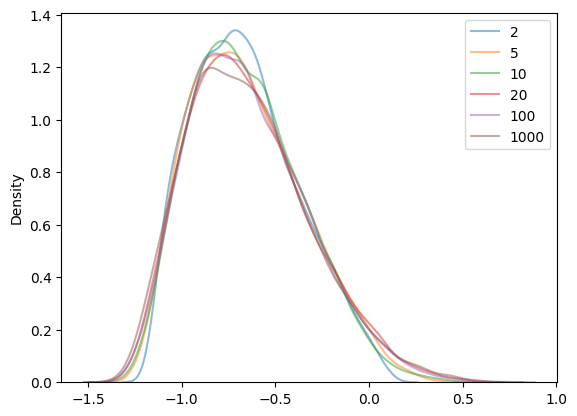

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

N = 10000
alpha = np.random.randn()
beta = np.random.randn(1000)
for p in [2,5,10,20,100,1000]:
    X = np.random.rand(N*p).reshape((N,p))
    # eta = X.dot(beta[:p]) + alpha
    eta = 2*(X-0.5).dot(beta[:p])/np.sqrt(p) + alpha
    k = 4
    z = 3 * stats.logistic.cdf(eta) - 1.5
    sns.kdeplot(z, alpha=0.5, label=p)
plt.legend();

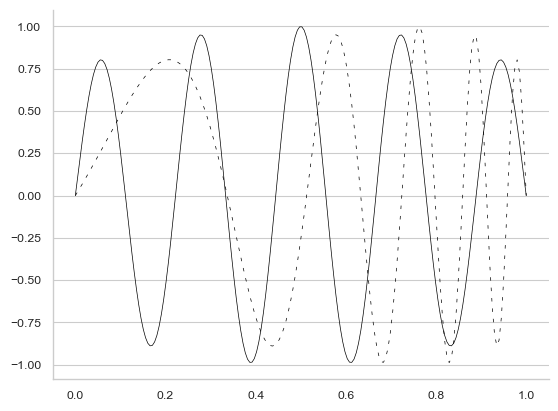

In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

np.random.seed(43)

N = 10000
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

t = np.linspace(0,1,1000)
def m(x):
    eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
    k = 4
    a = 3 * stats.logistic.cdf(eta) - 1.5
    gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)
    # return gam_t

# for i in range(15):
#     sns.lineplot(x=t, y=m(np.random.randn(p)), color='black', alpha=1, linewidth=0.5)

t = np.linspace(0,1,200)
template = (1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t)
plt.plot(t, template, color='black', linewidth=0.5)

plt.plot(t, m(np.random.rand(p)), color='black', linestyle=(0, (5, 10)), linewidth=0.5)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.grid(axis='x')
plt.savefig('plots/sample_phase.pdf')

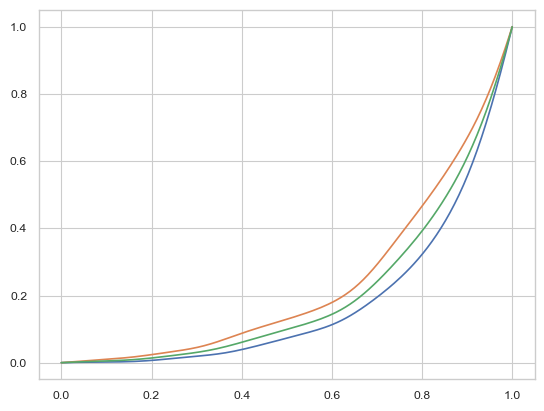

In [250]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product




N = 2
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

x, y, mx = gen_data(N,p,alpha,beta)

fig = skfda.FDataGrid(y.data, y.M.grid).plot();
skfda.FDataGrid(y.frechet_mean(), y.M.grid).plot(fig=fig);


[1.00000606]
[1.00000537]


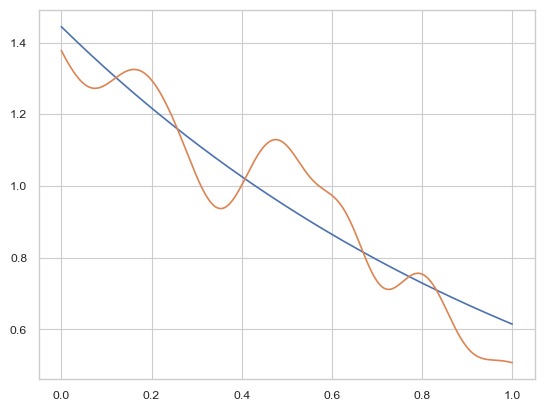

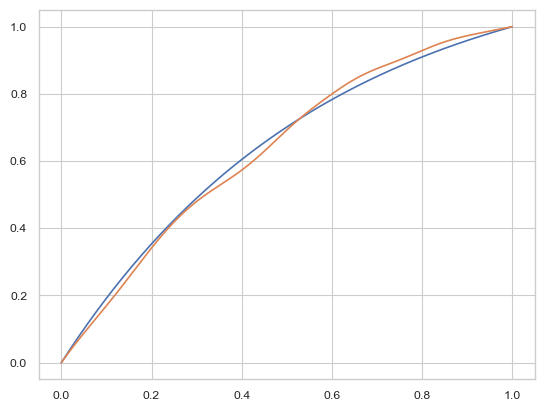

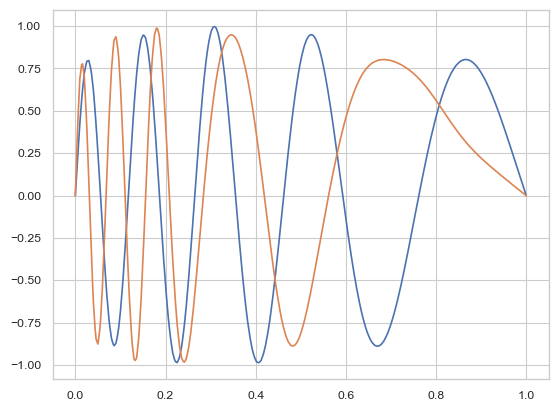

In [229]:
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

# np.random.seed(5)
template = skfda.FDataGrid((1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t), t)

mx = m(np.random.randn(p))

eps = 0.1
t = np.linspace(0,1,200)

x = np.random.randn(p)
eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
k = 4
a = 3 * stats.logistic.cdf(eta) - 1.5
gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
mx = (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)

y = skfda.FDataGrid(mx, t)
gam_y = skfda.FDataGrid(gam_t, t)


srsf = SRSF()
psi = srsf.fit_transform(gam_y)

v = skfda.FDataGrid(gp(t, kernel), t)
vx = v - inner_product(psi, v) * psi
nvx = skfda.misc.metrics.LpNorm(2)(vx)

psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
gam_pv = srsf.inverse_transform(psi_pv)

y_pv = y.compose(gam_pv)

print(skfda.misc.metrics.LpNorm(2)(psi))
print(skfda.misc.metrics.LpNorm(2)(psi_pv))

# template.plot();
# y.plot();
# plt.plot(t, gam_t);
# y.plot()
# q.plot()

fig=psi.plot()
psi_pv.plot(fig=fig)

fig=gam_y.plot()
gam_pv.plot(fig=fig);

fig=y.plot()
y_pv.plot(fig=fig);

# qpv.plot();

# skfda.misc.metrics.LpNorm(2)(q)

In [7]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

OUT_FILE = 'results/result_phase_cross_est_new_dgp_3.json'

def gen_data(N, p, alpha, beta):
    M = FisherRaoPhase(np.linspace(0,1,100))
    t = M.grid

    def m(x):
        eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
        k = 4
        a = 3 * stats.logistic.cdf(eta) - 1.5
        return (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    
    def add_noise(gam, eps = 0.1):
        k = lambda x1, x2: np.exp(-100 * np.subtract.outer(x1, x2)**2)
        gp = lambda t: np.random.multivariate_normal(mean=np.zeros(len(t)), cov=k(t,t))
        
        # map to psi = srsf of gamma which lies on the sphere
        srsf = SRSF()
        gam = skfda.FDataGrid(gam, t)
        psi = srsf.fit_transform(gam)

        # sample a random tangent vector
        v = skfda.FDataGrid(gp(t), t)
        vx = v - inner_product(psi, v) * psi
        nvx = skfda.misc.metrics.LpNorm(2)(vx)

        # apply it to psi and transform back to gamma space
        psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
        return srsf.inverse_transform(psi_pv).data_matrix[0,...,0]

    x = np.random.rand(N*p).reshape((N,p))
    mx = np.array([ m(x[i,:]) for i in range(N)])
    y = np.array([ add_noise(mx[i,:]) for i in range(N)])
    return x, MetricData(M, y), MetricData(M, mx)

bench(
    gen_data,
    OUT_FILE,
    ps=[2, 5, 10, 20],
    Ns=[50,100,200,400],
    replicas=20
)

[2023-06-14 00:54:13.280274] Progress: N=50	p=2	i=0
[2023-06-14 00:54:13.854559] Distances for cart_2means
[2023-06-14 00:54:13.854672] dt = 0
[2023-06-14 00:54:13.854699] Fitting for cart_2means
[2023-06-14 00:54:15.670801] dt = 1.816241979598999
[2023-06-14 00:54:15.670883] MSE for cart_2means
[2023-06-14 00:54:18.025012] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    2.8s finished


[2023-06-14 00:54:20.839077] dt = 2.8139970302581787
[2023-06-14 00:54:20.839155] Fitting for medoid_greedy
[2023-06-14 00:54:20.845589] dt = 0.006579875946044922
[2023-06-14 00:54:20.845599] MSE for medoid_greedy
[2023-06-14 00:54:23.136141] Progress: N=50	p=2	i=1
[2023-06-14 00:54:23.709261] Distances for cart_2means
[2023-06-14 00:54:23.709326] dt = 0
[2023-06-14 00:54:23.709332] Fitting for cart_2means
[2023-06-14 00:54:25.436214] dt = 1.7269530296325684
[2023-06-14 00:54:25.436292] MSE for cart_2means
[2023-06-14 00:54:27.852698] Distances for medoid_greedy
[2023-06-14 00:54:27.888408] dt = 0.03564310073852539
[2023-06-14 00:54:27.888421] Fitting for medoid_greedy
[2023-06-14 00:54:27.894140] dt = 0.005799770355224609
[2023-06-14 00:54:27.894148] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:54:29.910477] Progress: N=50	p=2	i=2
[2023-06-14 00:54:30.556047] Distances for cart_2means
[2023-06-14 00:54:30.556161] dt = 0
[2023-06-14 00:54:30.556183] Fitting for cart_2means
[2023-06-14 00:54:32.308323] dt = 1.7522759437561035
[2023-06-14 00:54:32.308401] MSE for cart_2means
[2023-06-14 00:54:35.227419] Distances for medoid_greedy
[2023-06-14 00:54:35.267740] dt = 0.04024386405944824
[2023-06-14 00:54:35.267757] Fitting for medoid_greedy
[2023-06-14 00:54:35.273825] dt = 0.006162881851196289
[2023-06-14 00:54:35.273832] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:54:37.578888] Progress: N=50	p=2	i=3
[2023-06-14 00:54:38.139149] Distances for cart_2means
[2023-06-14 00:54:38.139317] dt = 0
[2023-06-14 00:54:38.139336] Fitting for cart_2means
[2023-06-14 00:54:39.750538] dt = 1.6113879680633545
[2023-06-14 00:54:39.750609] MSE for cart_2means
[2023-06-14 00:54:43.311904] Distances for medoid_greedy
[2023-06-14 00:54:43.363822] dt = 0.051856279373168945
[2023-06-14 00:54:43.363846] Fitting for medoid_greedy
[2023-06-14 00:54:43.369809] dt = 0.006048679351806641
[2023-06-14 00:54:43.369815] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.1s finished


[2023-06-14 00:54:45.230716] Progress: N=50	p=2	i=4
[2023-06-14 00:54:45.824838] Distances for cart_2means
[2023-06-14 00:54:45.824930] dt = 0
[2023-06-14 00:54:45.824949] Fitting for cart_2means
[2023-06-14 00:54:47.524766] dt = 1.6999266147613525
[2023-06-14 00:54:47.524843] MSE for cart_2means
[2023-06-14 00:54:51.179557] Distances for medoid_greedy
[2023-06-14 00:54:51.221184] dt = 0.04156017303466797
[2023-06-14 00:54:51.221201] Fitting for medoid_greedy
[2023-06-14 00:54:51.227227] dt = 0.006110668182373047
[2023-06-14 00:54:51.227235] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:54:53.574223] Progress: N=50	p=2	i=5
[2023-06-14 00:54:54.135735] Distances for cart_2means
[2023-06-14 00:54:54.135852] dt = 0
[2023-06-14 00:54:54.135869] Fitting for cart_2means
[2023-06-14 00:54:55.304972] dt = 1.1692368984222412
[2023-06-14 00:54:55.305045] MSE for cart_2means
[2023-06-14 00:54:57.665996] Distances for medoid_greedy
[2023-06-14 00:54:57.708819] dt = 0.04275798797607422
[2023-06-14 00:54:57.708831] Fitting for medoid_greedy
[2023-06-14 00:54:57.715666] dt = 0.006910800933837891
[2023-06-14 00:54:57.715684] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:54:59.788417] Progress: N=50	p=2	i=6
[2023-06-14 00:55:00.419344] Distances for cart_2means
[2023-06-14 00:55:00.419459] dt = 0
[2023-06-14 00:55:00.419481] Fitting for cart_2means
[2023-06-14 00:55:02.138677] dt = 1.7193329334259033
[2023-06-14 00:55:02.138915] MSE for cart_2means
[2023-06-14 00:55:05.036019] Distances for medoid_greedy
[2023-06-14 00:55:05.071211] dt = 0.03511977195739746
[2023-06-14 00:55:05.071224] Fitting for medoid_greedy
[2023-06-14 00:55:05.077191] dt = 0.006052255630493164
[2023-06-14 00:55:05.077198] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:08.295231] Progress: N=50	p=2	i=7
[2023-06-14 00:55:09.062729] Distances for cart_2means
[2023-06-14 00:55:09.062843] dt = 0
[2023-06-14 00:55:09.062866] Fitting for cart_2means
[2023-06-14 00:55:10.491866] dt = 1.4291372299194336
[2023-06-14 00:55:10.491946] MSE for cart_2means
[2023-06-14 00:55:13.026647] Distances for medoid_greedy
[2023-06-14 00:55:13.065876] dt = 0.03915596008300781
[2023-06-14 00:55:13.065898] Fitting for medoid_greedy
[2023-06-14 00:55:13.072336] dt = 0.006534099578857422
[2023-06-14 00:55:13.072343] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:15.353523] Progress: N=50	p=2	i=8
[2023-06-14 00:55:15.969374] Distances for cart_2means
[2023-06-14 00:55:15.969564] dt = 0
[2023-06-14 00:55:15.969585] Fitting for cart_2means
[2023-06-14 00:55:17.841752] dt = 1.8723769187927246
[2023-06-14 00:55:17.841834] MSE for cart_2means
[2023-06-14 00:55:20.754575] Distances for medoid_greedy
[2023-06-14 00:55:20.794954] dt = 0.04030895233154297
[2023-06-14 00:55:20.794968] Fitting for medoid_greedy
[2023-06-14 00:55:20.801093] dt = 0.006209135055541992
[2023-06-14 00:55:20.801099] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:22.862405] Progress: N=50	p=2	i=9
[2023-06-14 00:55:23.489721] Distances for cart_2means
[2023-06-14 00:55:23.489821] dt = 0
[2023-06-14 00:55:23.489840] Fitting for cart_2means
[2023-06-14 00:55:25.410607] dt = 1.9208848476409912
[2023-06-14 00:55:25.410687] MSE for cart_2means
[2023-06-14 00:55:28.097879] Distances for medoid_greedy
[2023-06-14 00:55:28.138274] dt = 0.040329933166503906
[2023-06-14 00:55:28.138297] Fitting for medoid_greedy
[2023-06-14 00:55:28.143944] dt = 0.005736112594604492
[2023-06-14 00:55:28.143951] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:30.466618] Progress: N=50	p=2	i=10
[2023-06-14 00:55:31.088156] Distances for cart_2means
[2023-06-14 00:55:31.088267] dt = 0
[2023-06-14 00:55:31.088278] Fitting for cart_2means
[2023-06-14 00:55:32.989344] dt = 1.901188850402832
[2023-06-14 00:55:32.989433] MSE for cart_2means
[2023-06-14 00:55:36.229834] Distances for medoid_greedy
[2023-06-14 00:55:36.266727] dt = 0.03681468963623047
[2023-06-14 00:55:36.266740] Fitting for medoid_greedy
[2023-06-14 00:55:36.272344] dt = 0.005697488784790039
[2023-06-14 00:55:36.272351] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:39.348038] Progress: N=50	p=2	i=11
[2023-06-14 00:55:39.941433] Distances for cart_2means
[2023-06-14 00:55:39.941545] dt = 0
[2023-06-14 00:55:39.941569] Fitting for cart_2means
[2023-06-14 00:55:41.721091] dt = 1.7796571254730225
[2023-06-14 00:55:41.721171] MSE for cart_2means
[2023-06-14 00:55:45.497601] Distances for medoid_greedy
[2023-06-14 00:55:45.535067] dt = 0.0373990535736084
[2023-06-14 00:55:45.535079] Fitting for medoid_greedy
[2023-06-14 00:55:45.541298] dt = 0.00629878044128418
[2023-06-14 00:55:45.541305] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:47.943248] Progress: N=50	p=2	i=12
[2023-06-14 00:55:48.605490] Distances for cart_2means
[2023-06-14 00:55:48.610281] dt = 0
[2023-06-14 00:55:48.610288] Fitting for cart_2means
[2023-06-14 00:55:50.375524] dt = 1.770033359527588
[2023-06-14 00:55:50.375595] MSE for cart_2means
[2023-06-14 00:55:52.940491] Distances for medoid_greedy
[2023-06-14 00:55:52.982441] dt = 0.04187273979187012
[2023-06-14 00:55:52.982457] Fitting for medoid_greedy
[2023-06-14 00:55:52.988172] dt = 0.005809307098388672
[2023-06-14 00:55:52.988178] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:55:55.441833] Progress: N=50	p=2	i=13
[2023-06-14 00:55:56.025315] Distances for cart_2means
[2023-06-14 00:55:56.025420] dt = 0
[2023-06-14 00:55:56.025442] Fitting for cart_2means
[2023-06-14 00:55:57.920703] dt = 1.8953869342803955
[2023-06-14 00:55:57.920776] MSE for cart_2means
[2023-06-14 00:56:00.801584] Distances for medoid_greedy
[2023-06-14 00:56:00.846090] dt = 0.04443979263305664
[2023-06-14 00:56:00.846105] Fitting for medoid_greedy
[2023-06-14 00:56:00.854354] dt = 0.008331060409545898
[2023-06-14 00:56:00.854361] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:04.040023] Progress: N=50	p=2	i=14
[2023-06-14 00:56:04.705481] Distances for cart_2means
[2023-06-14 00:56:04.705604] dt = 0
[2023-06-14 00:56:04.705626] Fitting for cart_2means
[2023-06-14 00:56:06.494338] dt = 1.7888569831848145
[2023-06-14 00:56:06.494436] MSE for cart_2means
[2023-06-14 00:56:09.043340] Distances for medoid_greedy
[2023-06-14 00:56:09.085893] dt = 0.04248499870300293
[2023-06-14 00:56:09.085906] Fitting for medoid_greedy
[2023-06-14 00:56:09.092333] dt = 0.0065081119537353516
[2023-06-14 00:56:09.092340] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:11.588016] Progress: N=50	p=2	i=15
[2023-06-14 00:56:12.180402] Distances for cart_2means
[2023-06-14 00:56:12.180506] dt = 0
[2023-06-14 00:56:12.180528] Fitting for cart_2means
[2023-06-14 00:56:13.959470] dt = 1.7790682315826416
[2023-06-14 00:56:13.959554] MSE for cart_2means
[2023-06-14 00:56:16.862181] Distances for medoid_greedy
[2023-06-14 00:56:16.910331] dt = 0.04808306694030762
[2023-06-14 00:56:16.910347] Fitting for medoid_greedy
[2023-06-14 00:56:16.916165] dt = 0.005903005599975586
[2023-06-14 00:56:16.916172] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:18.738186] Progress: N=50	p=2	i=16
[2023-06-14 00:56:19.371785] Distances for cart_2means
[2023-06-14 00:56:19.371894] dt = 0
[2023-06-14 00:56:19.371907] Fitting for cart_2means
[2023-06-14 00:56:21.047697] dt = 1.6759121417999268
[2023-06-14 00:56:21.047779] MSE for cart_2means
[2023-06-14 00:56:24.311818] Distances for medoid_greedy
[2023-06-14 00:56:24.351627] dt = 0.03972983360290527
[2023-06-14 00:56:24.351640] Fitting for medoid_greedy
[2023-06-14 00:56:24.357205] dt = 0.005658149719238281
[2023-06-14 00:56:24.357212] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:26.211304] Progress: N=50	p=2	i=17
[2023-06-14 00:56:26.789116] Distances for cart_2means
[2023-06-14 00:56:26.789215] dt = 0
[2023-06-14 00:56:26.789233] Fitting for cart_2means
[2023-06-14 00:56:27.942614] dt = 1.1534960269927979
[2023-06-14 00:56:27.942782] MSE for cart_2means
[2023-06-14 00:56:31.720077] Distances for medoid_greedy
[2023-06-14 00:56:31.762308] dt = 0.04216122627258301
[2023-06-14 00:56:31.762321] Fitting for medoid_greedy
[2023-06-14 00:56:31.768329] dt = 0.006090641021728516
[2023-06-14 00:56:31.768336] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:33.836671] Progress: N=50	p=2	i=18
[2023-06-14 00:56:34.420221] Distances for cart_2means
[2023-06-14 00:56:34.420331] dt = 0
[2023-06-14 00:56:34.420350] Fitting for cart_2means
[2023-06-14 00:56:36.296811] dt = 1.8765900135040283
[2023-06-14 00:56:36.296891] MSE for cart_2means
[2023-06-14 00:56:38.851000] Distances for medoid_greedy
[2023-06-14 00:56:38.891183] dt = 0.04011130332946777
[2023-06-14 00:56:38.891196] Fitting for medoid_greedy
[2023-06-14 00:56:38.897134] dt = 0.00602269172668457
[2023-06-14 00:56:38.897145] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:40.892780] Progress: N=50	p=2	i=19
[2023-06-14 00:56:41.729347] Distances for cart_2means
[2023-06-14 00:56:41.729705] dt = 0
[2023-06-14 00:56:41.729729] Fitting for cart_2means
[2023-06-14 00:56:43.568466] dt = 1.8391189575195312
[2023-06-14 00:56:43.568544] MSE for cart_2means
[2023-06-14 00:56:46.551273] Distances for medoid_greedy
[2023-06-14 00:56:46.592179] dt = 0.040837764739990234
[2023-06-14 00:56:46.592192] Fitting for medoid_greedy
[2023-06-14 00:56:46.598063] dt = 0.005952358245849609
[2023-06-14 00:56:46.598070] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:48.578243] Progress: N=50	p=5	i=0
[2023-06-14 00:56:49.231404] Distances for cart_2means
[2023-06-14 00:56:49.231778] dt = 0
[2023-06-14 00:56:49.231790] Fitting for cart_2means
[2023-06-14 00:56:53.503964] dt = 4.272561073303223
[2023-06-14 00:56:53.504042] MSE for cart_2means
[2023-06-14 00:56:56.643887] Distances for medoid_greedy
[2023-06-14 00:56:56.685142] dt = 0.04118609428405762
[2023-06-14 00:56:56.685155] Fitting for medoid_greedy
[2023-06-14 00:56:56.699078] dt = 0.014004945755004883
[2023-06-14 00:56:56.699086] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:56:58.560627] Progress: N=50	p=5	i=1
[2023-06-14 00:56:59.214605] Distances for cart_2means
[2023-06-14 00:56:59.214713] dt = 0
[2023-06-14 00:56:59.214735] Fitting for cart_2means
[2023-06-14 00:57:03.587496] dt = 4.3728907108306885
[2023-06-14 00:57:03.587569] MSE for cart_2means
[2023-06-14 00:57:06.120558] Distances for medoid_greedy
[2023-06-14 00:57:06.163359] dt = 0.04273200035095215
[2023-06-14 00:57:06.163373] Fitting for medoid_greedy
[2023-06-14 00:57:06.178868] dt = 0.01557779312133789
[2023-06-14 00:57:06.178876] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:57:09.314375] Progress: N=50	p=5	i=2
[2023-06-14 00:57:09.895951] Distances for cart_2means
[2023-06-14 00:57:09.896062] dt = 0
[2023-06-14 00:57:09.896085] Fitting for cart_2means
[2023-06-14 00:57:14.176890] dt = 4.280939102172852
[2023-06-14 00:57:14.176967] MSE for cart_2means
[2023-06-14 00:57:17.796252] Distances for medoid_greedy
[2023-06-14 00:57:17.840564] dt = 0.04423403739929199
[2023-06-14 00:57:17.840579] Fitting for medoid_greedy
[2023-06-14 00:57:17.857803] dt = 0.017318248748779297
[2023-06-14 00:57:17.857815] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:57:20.479407] Progress: N=50	p=5	i=3
[2023-06-14 00:57:21.172376] Distances for cart_2means
[2023-06-14 00:57:21.172473] dt = 0
[2023-06-14 00:57:21.172496] Fitting for cart_2means
[2023-06-14 00:57:25.435020] dt = 4.262644052505493
[2023-06-14 00:57:25.435102] MSE for cart_2means
[2023-06-14 00:57:28.137380] Distances for medoid_greedy
[2023-06-14 00:57:28.181382] dt = 0.04392814636230469
[2023-06-14 00:57:28.181395] Fitting for medoid_greedy
[2023-06-14 00:57:28.195705] dt = 0.01439666748046875
[2023-06-14 00:57:28.195713] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:57:30.912527] Progress: N=50	p=5	i=4
[2023-06-14 00:57:31.405450] Distances for cart_2means
[2023-06-14 00:57:31.405518] dt = 0
[2023-06-14 00:57:31.405523] Fitting for cart_2means
[2023-06-14 00:57:35.399866] dt = 3.9944162368774414
[2023-06-14 00:57:35.399944] MSE for cart_2means
[2023-06-14 00:57:38.923948] Distances for medoid_greedy
[2023-06-14 00:57:38.970247] dt = 0.046234846115112305
[2023-06-14 00:57:38.970260] Fitting for medoid_greedy
[2023-06-14 00:57:38.986100] dt = 0.015917062759399414
[2023-06-14 00:57:38.986118] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:57:42.179997] Progress: N=50	p=5	i=5
[2023-06-14 00:57:42.716186] Distances for cart_2means
[2023-06-14 00:57:42.716310] dt = 0
[2023-06-14 00:57:42.716332] Fitting for cart_2means
[2023-06-14 00:57:46.929550] dt = 4.213363885879517
[2023-06-14 00:57:46.929628] MSE for cart_2means
[2023-06-14 00:57:50.022272] Distances for medoid_greedy
[2023-06-14 00:57:50.061470] dt = 0.039125919342041016
[2023-06-14 00:57:50.061483] Fitting for medoid_greedy
[2023-06-14 00:57:50.075442] dt = 0.014044046401977539
[2023-06-14 00:57:50.075451] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:57:53.198953] Progress: N=50	p=5	i=6
[2023-06-14 00:57:53.876459] Distances for cart_2means
[2023-06-14 00:57:53.876570] dt = 0
[2023-06-14 00:57:53.876593] Fitting for cart_2means
[2023-06-14 00:57:58.268605] dt = 4.392145872116089
[2023-06-14 00:57:58.268675] MSE for cart_2means
[2023-06-14 00:58:01.155190] Distances for medoid_greedy
[2023-06-14 00:58:01.194888] dt = 0.039628028869628906
[2023-06-14 00:58:01.194902] Fitting for medoid_greedy
[2023-06-14 00:58:01.208836] dt = 0.014019012451171875
[2023-06-14 00:58:01.208845] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:04.272028] Progress: N=50	p=5	i=7
[2023-06-14 00:58:04.844676] Distances for cart_2means
[2023-06-14 00:58:04.844800] dt = 0
[2023-06-14 00:58:04.844816] Fitting for cart_2means
[2023-06-14 00:58:09.252848] dt = 4.408171892166138
[2023-06-14 00:58:09.252935] MSE for cart_2means
[2023-06-14 00:58:11.358921] Distances for medoid_greedy
[2023-06-14 00:58:11.400483] dt = 0.04149484634399414
[2023-06-14 00:58:11.400497] Fitting for medoid_greedy
[2023-06-14 00:58:11.419426] dt = 0.019010305404663086
[2023-06-14 00:58:11.419435] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:14.143556] Progress: N=50	p=5	i=8
[2023-06-14 00:58:14.875418] Distances for cart_2means
[2023-06-14 00:58:14.876152] dt = 0
[2023-06-14 00:58:14.876175] Fitting for cart_2means
[2023-06-14 00:58:18.269984] dt = 3.394566059112549
[2023-06-14 00:58:18.270095] MSE for cart_2means
[2023-06-14 00:58:20.537602] Distances for medoid_greedy
[2023-06-14 00:58:20.586822] dt = 0.04915022850036621
[2023-06-14 00:58:20.586835] Fitting for medoid_greedy
[2023-06-14 00:58:20.603121] dt = 0.016368865966796875
[2023-06-14 00:58:20.603130] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:22.009143] Progress: N=50	p=5	i=9
[2023-06-14 00:58:22.743073] Distances for cart_2means
[2023-06-14 00:58:22.743365] dt = 0
[2023-06-14 00:58:22.743385] Fitting for cart_2means
[2023-06-14 00:58:26.779737] dt = 4.0366621017456055
[2023-06-14 00:58:26.779861] MSE for cart_2means
[2023-06-14 00:58:29.064822] Distances for medoid_greedy
[2023-06-14 00:58:29.112204] dt = 0.04731178283691406
[2023-06-14 00:58:29.112217] Fitting for medoid_greedy
[2023-06-14 00:58:29.127692] dt = 0.015558242797851562
[2023-06-14 00:58:29.127701] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:31.228115] Progress: N=50	p=5	i=10
[2023-06-14 00:58:31.840804] Distances for cart_2means
[2023-06-14 00:58:31.841530] dt = 0
[2023-06-14 00:58:31.841553] Fitting for cart_2means
[2023-06-14 00:58:35.432767] dt = 3.5919628143310547
[2023-06-14 00:58:35.432847] MSE for cart_2means
[2023-06-14 00:58:37.630674] Distances for medoid_greedy
[2023-06-14 00:58:37.672760] dt = 0.04201698303222656
[2023-06-14 00:58:37.672773] Fitting for medoid_greedy
[2023-06-14 00:58:37.690071] dt = 0.017380952835083008
[2023-06-14 00:58:37.690081] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:39.728715] Progress: N=50	p=5	i=11
[2023-06-14 00:58:40.340727] Distances for cart_2means
[2023-06-14 00:58:40.340832] dt = 0
[2023-06-14 00:58:40.340855] Fitting for cart_2means
[2023-06-14 00:58:44.534543] dt = 4.193816184997559
[2023-06-14 00:58:44.534618] MSE for cart_2means
[2023-06-14 00:58:47.276403] Distances for medoid_greedy
[2023-06-14 00:58:47.318993] dt = 0.042520761489868164
[2023-06-14 00:58:47.319011] Fitting for medoid_greedy
[2023-06-14 00:58:47.332205] dt = 0.013282299041748047
[2023-06-14 00:58:47.332213] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:58:49.859595] Progress: N=50	p=5	i=12
[2023-06-14 00:58:50.530433] Distances for cart_2means
[2023-06-14 00:58:50.530541] dt = 0
[2023-06-14 00:58:50.530564] Fitting for cart_2means
[2023-06-14 00:58:54.790994] dt = 4.260560989379883
[2023-06-14 00:58:54.791070] MSE for cart_2means
[2023-06-14 00:58:57.672803] Distances for medoid_greedy
[2023-06-14 00:58:57.717395] dt = 0.04451894760131836
[2023-06-14 00:58:57.717409] Fitting for medoid_greedy
[2023-06-14 00:58:57.731464] dt = 0.014142036437988281
[2023-06-14 00:58:57.731473] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:00.431633] Progress: N=50	p=5	i=13
[2023-06-14 00:59:01.076844] Distances for cart_2means
[2023-06-14 00:59:01.077091] dt = 0
[2023-06-14 00:59:01.077112] Fitting for cart_2means
[2023-06-14 00:59:05.848626] dt = 4.771782875061035
[2023-06-14 00:59:05.848706] MSE for cart_2means
[2023-06-14 00:59:09.213600] Distances for medoid_greedy
[2023-06-14 00:59:09.257270] dt = 0.04359793663024902
[2023-06-14 00:59:09.257283] Fitting for medoid_greedy
[2023-06-14 00:59:09.272707] dt = 0.015510082244873047
[2023-06-14 00:59:09.272718] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:12.400657] Progress: N=50	p=5	i=14
[2023-06-14 00:59:12.982731] Distances for cart_2means
[2023-06-14 00:59:12.982834] dt = 0
[2023-06-14 00:59:12.982859] Fitting for cart_2means
[2023-06-14 00:59:16.622492] dt = 3.639760971069336
[2023-06-14 00:59:16.622566] MSE for cart_2means
[2023-06-14 00:59:19.350588] Distances for medoid_greedy
[2023-06-14 00:59:19.395179] dt = 0.04452013969421387
[2023-06-14 00:59:19.395192] Fitting for medoid_greedy
[2023-06-14 00:59:19.410127] dt = 0.015017986297607422
[2023-06-14 00:59:19.410136] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:21.701974] Progress: N=50	p=5	i=15
[2023-06-14 00:59:22.277455] Distances for cart_2means
[2023-06-14 00:59:22.278410] dt = 0
[2023-06-14 00:59:22.278433] Fitting for cart_2means
[2023-06-14 00:59:26.949323] dt = 4.671867847442627
[2023-06-14 00:59:26.949399] MSE for cart_2means
[2023-06-14 00:59:29.870105] Distances for medoid_greedy
[2023-06-14 00:59:29.912171] dt = 0.042000770568847656
[2023-06-14 00:59:29.912188] Fitting for medoid_greedy
[2023-06-14 00:59:29.927075] dt = 0.014969110488891602
[2023-06-14 00:59:29.927083] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:32.742911] Progress: N=50	p=5	i=16
[2023-06-14 00:59:33.310563] Distances for cart_2means
[2023-06-14 00:59:33.310736] dt = 0
[2023-06-14 00:59:33.310756] Fitting for cart_2means
[2023-06-14 00:59:37.619162] dt = 4.30859899520874
[2023-06-14 00:59:37.619246] MSE for cart_2means
[2023-06-14 00:59:40.713177] Distances for medoid_greedy
[2023-06-14 00:59:40.754856] dt = 0.041610002517700195
[2023-06-14 00:59:40.754870] Fitting for medoid_greedy
[2023-06-14 00:59:40.770319] dt = 0.01553201675415039
[2023-06-14 00:59:40.770328] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:42.077506] Progress: N=50	p=5	i=17
[2023-06-14 00:59:42.676356] Distances for cart_2means
[2023-06-14 00:59:42.676463] dt = 0
[2023-06-14 00:59:42.676487] Fitting for cart_2means
[2023-06-14 00:59:46.983256] dt = 4.306898832321167
[2023-06-14 00:59:46.983328] MSE for cart_2means
[2023-06-14 00:59:49.237530] Distances for medoid_greedy
[2023-06-14 00:59:49.272906] dt = 0.035307884216308594
[2023-06-14 00:59:49.272920] Fitting for medoid_greedy
[2023-06-14 00:59:49.288917] dt = 0.01607799530029297
[2023-06-14 00:59:49.288936] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 00:59:51.925159] Progress: N=50	p=5	i=18
[2023-06-14 00:59:52.480436] Distances for cart_2means
[2023-06-14 00:59:52.480542] dt = 0
[2023-06-14 00:59:52.480565] Fitting for cart_2means
[2023-06-14 00:59:56.782622] dt = 4.302186012268066
[2023-06-14 00:59:56.782701] MSE for cart_2means
[2023-06-14 00:59:59.505614] Distances for medoid_greedy
[2023-06-14 00:59:59.555561] dt = 0.04987382888793945
[2023-06-14 00:59:59.555574] Fitting for medoid_greedy
[2023-06-14 00:59:59.569382] dt = 0.013894319534301758
[2023-06-14 00:59:59.569390] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:00:02.134462] Progress: N=50	p=5	i=19
[2023-06-14 01:00:02.724003] Distances for cart_2means
[2023-06-14 01:00:02.724107] dt = 0
[2023-06-14 01:00:02.724132] Fitting for cart_2means
[2023-06-14 01:00:06.990726] dt = 4.266722917556763
[2023-06-14 01:00:06.990804] MSE for cart_2means
[2023-06-14 01:00:09.899254] Distances for medoid_greedy
[2023-06-14 01:00:09.939865] dt = 0.04053521156311035
[2023-06-14 01:00:09.939878] Fitting for medoid_greedy
[2023-06-14 01:00:09.953157] dt = 0.013367891311645508
[2023-06-14 01:00:09.953164] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:00:12.641452] Progress: N=50	p=10	i=0
[2023-06-14 01:00:13.269779] Distances for cart_2means
[2023-06-14 01:00:13.270214] dt = 0
[2023-06-14 01:00:13.270236] Fitting for cart_2means
[2023-06-14 01:00:22.126231] dt = 8.856451988220215
[2023-06-14 01:00:22.126305] MSE for cart_2means
[2023-06-14 01:00:24.997978] Distances for medoid_greedy
[2023-06-14 01:00:25.034866] dt = 0.0368189811706543
[2023-06-14 01:00:25.034879] Fitting for medoid_greedy
[2023-06-14 01:00:25.063017] dt = 0.02822089195251465
[2023-06-14 01:00:25.063027] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:00:27.674417] Progress: N=50	p=10	i=1
[2023-06-14 01:00:28.278966] Distances for cart_2means
[2023-06-14 01:00:28.279074] dt = 0
[2023-06-14 01:00:28.279096] Fitting for cart_2means
[2023-06-14 01:00:36.975692] dt = 8.696724891662598
[2023-06-14 01:00:36.975770] MSE for cart_2means
[2023-06-14 01:00:39.476303] Distances for medoid_greedy
[2023-06-14 01:00:39.518924] dt = 0.04254484176635742
[2023-06-14 01:00:39.518938] Fitting for medoid_greedy
[2023-06-14 01:00:39.545282] dt = 0.026433944702148438
[2023-06-14 01:00:39.545290] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:00:41.402332] Progress: N=50	p=10	i=2
[2023-06-14 01:00:42.047441] Distances for cart_2means
[2023-06-14 01:00:42.049253] dt = 0
[2023-06-14 01:00:42.049273] Fitting for cart_2means
[2023-06-14 01:00:50.730506] dt = 8.683064937591553
[2023-06-14 01:00:50.730579] MSE for cart_2means
[2023-06-14 01:00:52.934180] Distances for medoid_greedy
[2023-06-14 01:00:52.971460] dt = 0.03720808029174805
[2023-06-14 01:00:52.971473] Fitting for medoid_greedy
[2023-06-14 01:00:53.005989] dt = 0.03460097312927246
[2023-06-14 01:00:53.006001] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:00:55.251532] Progress: N=50	p=10	i=3
[2023-06-14 01:00:55.811035] Distances for cart_2means
[2023-06-14 01:00:55.811134] dt = 0
[2023-06-14 01:00:55.811154] Fitting for cart_2means
[2023-06-14 01:01:04.691323] dt = 8.880286931991577
[2023-06-14 01:01:04.691399] MSE for cart_2means
[2023-06-14 01:01:06.823501] Distances for medoid_greedy
[2023-06-14 01:01:06.858848] dt = 0.03528285026550293
[2023-06-14 01:01:06.858865] Fitting for medoid_greedy
[2023-06-14 01:01:06.897313] dt = 0.03852725028991699
[2023-06-14 01:01:06.897337] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:01:09.470032] Progress: N=50	p=10	i=4
[2023-06-14 01:01:09.999600] Distances for cart_2means
[2023-06-14 01:01:09.999883] dt = 0
[2023-06-14 01:01:09.999888] Fitting for cart_2means
[2023-06-14 01:01:19.603212] dt = 9.603609800338745
[2023-06-14 01:01:19.603336] MSE for cart_2means
[2023-06-14 01:01:22.625981] Distances for medoid_greedy
[2023-06-14 01:01:22.666993] dt = 0.04094409942626953
[2023-06-14 01:01:22.667007] Fitting for medoid_greedy
[2023-06-14 01:01:22.700161] dt = 0.033236026763916016
[2023-06-14 01:01:22.700172] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:01:25.674645] Progress: N=50	p=10	i=5
[2023-06-14 01:01:26.295139] Distances for cart_2means
[2023-06-14 01:01:26.295702] dt = 0
[2023-06-14 01:01:26.295715] Fitting for cart_2means
[2023-06-14 01:01:32.709691] dt = 6.414552211761475
[2023-06-14 01:01:32.709772] MSE for cart_2means
[2023-06-14 01:01:34.317634] Distances for medoid_greedy
[2023-06-14 01:01:34.362319] dt = 0.04461216926574707
[2023-06-14 01:01:34.362333] Fitting for medoid_greedy
[2023-06-14 01:01:34.400892] dt = 0.038646697998046875
[2023-06-14 01:01:34.400911] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:01:36.213741] Progress: N=50	p=10	i=6
[2023-06-14 01:01:36.875847] Distances for cart_2means
[2023-06-14 01:01:36.875971] dt = 0
[2023-06-14 01:01:36.875991] Fitting for cart_2means
[2023-06-14 01:01:44.996445] dt = 8.120598077774048
[2023-06-14 01:01:44.996519] MSE for cart_2means
[2023-06-14 01:01:47.310392] Distances for medoid_greedy
[2023-06-14 01:01:47.352712] dt = 0.0422511100769043
[2023-06-14 01:01:47.352724] Fitting for medoid_greedy
[2023-06-14 01:01:47.387239] dt = 0.034596920013427734
[2023-06-14 01:01:47.387250] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:01:49.763941] Progress: N=50	p=10	i=7
[2023-06-14 01:01:50.404418] Distances for cart_2means
[2023-06-14 01:01:50.404528] dt = 0
[2023-06-14 01:01:50.404551] Fitting for cart_2means
[2023-06-14 01:01:58.708375] dt = 8.303956985473633
[2023-06-14 01:01:58.708455] MSE for cart_2means
[2023-06-14 01:02:01.611933] Distances for medoid_greedy
[2023-06-14 01:02:01.657231] dt = 0.04523110389709473
[2023-06-14 01:02:01.657243] Fitting for medoid_greedy
[2023-06-14 01:02:01.690144] dt = 0.03297996520996094
[2023-06-14 01:02:01.690165] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:02:04.604973] Progress: N=50	p=10	i=8
[2023-06-14 01:02:05.233936] Distances for cart_2means
[2023-06-14 01:02:05.234053] dt = 0
[2023-06-14 01:02:05.234078] Fitting for cart_2means
[2023-06-14 01:02:14.433534] dt = 9.199597835540771
[2023-06-14 01:02:14.433618] MSE for cart_2means
[2023-06-14 01:02:17.122308] Distances for medoid_greedy
[2023-06-14 01:02:17.170070] dt = 0.04769110679626465
[2023-06-14 01:02:17.170083] Fitting for medoid_greedy
[2023-06-14 01:02:17.198243] dt = 0.0282437801361084
[2023-06-14 01:02:17.198256] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:02:20.587090] Progress: N=50	p=10	i=9
[2023-06-14 01:02:21.304420] Distances for cart_2means
[2023-06-14 01:02:21.304523] dt = 0
[2023-06-14 01:02:21.304543] Fitting for cart_2means
[2023-06-14 01:02:30.969051] dt = 9.664629936218262
[2023-06-14 01:02:30.969135] MSE for cart_2means
[2023-06-14 01:02:34.451717] Distances for medoid_greedy
[2023-06-14 01:02:34.490348] dt = 0.03856301307678223
[2023-06-14 01:02:34.490362] Fitting for medoid_greedy
[2023-06-14 01:02:34.519103] dt = 0.028822660446166992
[2023-06-14 01:02:34.519114] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:02:37.211075] Progress: N=50	p=10	i=10
[2023-06-14 01:02:37.861178] Distances for cart_2means
[2023-06-14 01:02:37.861574] dt = 0
[2023-06-14 01:02:37.861595] Fitting for cart_2means
[2023-06-14 01:02:45.832358] dt = 7.971179962158203
[2023-06-14 01:02:45.832437] MSE for cart_2means
[2023-06-14 01:02:48.333861] Distances for medoid_greedy
[2023-06-14 01:02:48.377424] dt = 0.043494224548339844
[2023-06-14 01:02:48.377447] Fitting for medoid_greedy
[2023-06-14 01:02:48.405899] dt = 0.028543710708618164
[2023-06-14 01:02:48.405922] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:02:51.033997] Progress: N=50	p=10	i=11
[2023-06-14 01:02:51.724856] Distances for cart_2means
[2023-06-14 01:02:51.725157] dt = 0
[2023-06-14 01:02:51.725178] Fitting for cart_2means
[2023-06-14 01:03:00.372292] dt = 8.647435188293457
[2023-06-14 01:03:00.372368] MSE for cart_2means
[2023-06-14 01:03:02.787611] Distances for medoid_greedy
[2023-06-14 01:03:02.832067] dt = 0.04438924789428711
[2023-06-14 01:03:02.832081] Fitting for medoid_greedy
[2023-06-14 01:03:02.860100] dt = 0.02810072898864746
[2023-06-14 01:03:02.860110] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:03:05.153607] Progress: N=50	p=10	i=12
[2023-06-14 01:03:05.794080] Distances for cart_2means
[2023-06-14 01:03:05.794189] dt = 0
[2023-06-14 01:03:05.794215] Fitting for cart_2means
[2023-06-14 01:03:15.543567] dt = 9.749486923217773
[2023-06-14 01:03:15.543643] MSE for cart_2means
[2023-06-14 01:03:18.674454] Distances for medoid_greedy
[2023-06-14 01:03:18.710312] dt = 0.03577089309692383
[2023-06-14 01:03:18.710325] Fitting for medoid_greedy
[2023-06-14 01:03:18.742085] dt = 0.031861066818237305
[2023-06-14 01:03:18.742098] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:03:20.916694] Progress: N=50	p=10	i=13
[2023-06-14 01:03:21.621129] Distances for cart_2means
[2023-06-14 01:03:21.621416] dt = 0
[2023-06-14 01:03:21.621436] Fitting for cart_2means
[2023-06-14 01:03:28.946529] dt = 7.325401067733765
[2023-06-14 01:03:28.946613] MSE for cart_2means
[2023-06-14 01:03:31.427091] Distances for medoid_greedy
[2023-06-14 01:03:31.480410] dt = 0.053246259689331055
[2023-06-14 01:03:31.480431] Fitting for medoid_greedy
[2023-06-14 01:03:31.509574] dt = 0.029237747192382812
[2023-06-14 01:03:31.509583] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.1s finished


[2023-06-14 01:03:33.994275] Progress: N=50	p=10	i=14
[2023-06-14 01:03:34.623486] Distances for cart_2means
[2023-06-14 01:03:34.623631] dt = 0
[2023-06-14 01:03:34.623655] Fitting for cart_2means
[2023-06-14 01:03:42.859964] dt = 8.236477375030518
[2023-06-14 01:03:42.860044] MSE for cart_2means
[2023-06-14 01:03:45.565770] Distances for medoid_greedy
[2023-06-14 01:03:45.613282] dt = 0.04744291305541992
[2023-06-14 01:03:45.613306] Fitting for medoid_greedy
[2023-06-14 01:03:45.643229] dt = 0.03001713752746582
[2023-06-14 01:03:45.643242] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:03:48.645792] Progress: N=50	p=10	i=15
[2023-06-14 01:03:49.324964] Distances for cart_2means
[2023-06-14 01:03:49.325367] dt = 0
[2023-06-14 01:03:49.325389] Fitting for cart_2means
[2023-06-14 01:03:58.221408] dt = 8.89644193649292
[2023-06-14 01:03:58.221530] MSE for cart_2means
[2023-06-14 01:04:01.131838] Distances for medoid_greedy
[2023-06-14 01:04:01.172224] dt = 0.040322065353393555
[2023-06-14 01:04:01.172238] Fitting for medoid_greedy
[2023-06-14 01:04:01.200761] dt = 0.028602123260498047
[2023-06-14 01:04:01.200770] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:04:03.302512] Progress: N=50	p=10	i=16
[2023-06-14 01:04:03.877981] Distances for cart_2means
[2023-06-14 01:04:03.878084] dt = 0
[2023-06-14 01:04:03.878107] Fitting for cart_2means
[2023-06-14 01:04:12.929653] dt = 9.051671028137207
[2023-06-14 01:04:12.929736] MSE for cart_2means
[2023-06-14 01:04:15.767103] Distances for medoid_greedy
[2023-06-14 01:04:15.812058] dt = 0.044886112213134766
[2023-06-14 01:04:15.812075] Fitting for medoid_greedy
[2023-06-14 01:04:15.842499] dt = 0.03050994873046875
[2023-06-14 01:04:15.842509] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:04:18.406243] Progress: N=50	p=10	i=17
[2023-06-14 01:04:19.141648] Distances for cart_2means
[2023-06-14 01:04:19.143811] dt = 0
[2023-06-14 01:04:19.143816] Fitting for cart_2means
[2023-06-14 01:04:28.834179] dt = 9.692529916763306
[2023-06-14 01:04:28.834262] MSE for cart_2means
[2023-06-14 01:04:31.891753] Distances for medoid_greedy
[2023-06-14 01:04:31.934612] dt = 0.042787790298461914
[2023-06-14 01:04:31.934625] Fitting for medoid_greedy
[2023-06-14 01:04:31.962297] dt = 0.02775740623474121
[2023-06-14 01:04:31.962306] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:04:34.517728] Progress: N=50	p=10	i=18
[2023-06-14 01:04:35.216477] Distances for cart_2means
[2023-06-14 01:04:35.216670] dt = 0
[2023-06-14 01:04:35.216683] Fitting for cart_2means
[2023-06-14 01:04:43.453217] dt = 8.236740827560425
[2023-06-14 01:04:43.453304] MSE for cart_2means
[2023-06-14 01:04:45.927686] Distances for medoid_greedy
[2023-06-14 01:04:45.967028] dt = 0.03926515579223633
[2023-06-14 01:04:45.967042] Fitting for medoid_greedy
[2023-06-14 01:04:45.995570] dt = 0.028619766235351562
[2023-06-14 01:04:45.995582] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:04:49.243151] Progress: N=50	p=10	i=19
[2023-06-14 01:04:49.825904] Distances for cart_2means
[2023-06-14 01:04:49.826016] dt = 0
[2023-06-14 01:04:49.826034] Fitting for cart_2means
[2023-06-14 01:04:58.914020] dt = 9.088114976882935
[2023-06-14 01:04:58.914149] MSE for cart_2means
[2023-06-14 01:05:01.779452] Distances for medoid_greedy
[2023-06-14 01:05:01.821842] dt = 0.04231667518615723
[2023-06-14 01:05:01.821855] Fitting for medoid_greedy
[2023-06-14 01:05:01.851489] dt = 0.02972126007080078
[2023-06-14 01:05:01.851499] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:05:04.514253] Progress: N=50	p=20	i=0
[2023-06-14 01:05:05.166416] Distances for cart_2means
[2023-06-14 01:05:05.166525] dt = 0
[2023-06-14 01:05:05.166547] Fitting for cart_2means
[2023-06-14 01:05:24.450632] dt = 19.284215688705444
[2023-06-14 01:05:24.450718] MSE for cart_2means
[2023-06-14 01:05:27.314925] Distances for medoid_greedy
[2023-06-14 01:05:27.356947] dt = 0.041954994201660156
[2023-06-14 01:05:27.356963] Fitting for medoid_greedy
[2023-06-14 01:05:27.429611] dt = 0.07273006439208984
[2023-06-14 01:05:27.429644] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:05:29.969038] Progress: N=50	p=20	i=1
[2023-06-14 01:05:30.888824] Distances for cart_2means
[2023-06-14 01:05:30.888943] dt = 0
[2023-06-14 01:05:30.888955] Fitting for cart_2means
[2023-06-14 01:05:49.927225] dt = 19.03840208053589
[2023-06-14 01:05:49.927301] MSE for cart_2means
[2023-06-14 01:05:52.598558] Distances for medoid_greedy
[2023-06-14 01:05:52.641343] dt = 0.04271268844604492
[2023-06-14 01:05:52.641357] Fitting for medoid_greedy
[2023-06-14 01:05:52.710541] dt = 0.06927037239074707
[2023-06-14 01:05:52.710563] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:05:54.630026] Progress: N=50	p=20	i=2
[2023-06-14 01:05:55.284323] Distances for cart_2means
[2023-06-14 01:05:55.284545] dt = 0
[2023-06-14 01:05:55.284567] Fitting for cart_2means
[2023-06-14 01:06:13.449485] dt = 18.16516089439392
[2023-06-14 01:06:13.449569] MSE for cart_2means
[2023-06-14 01:06:15.880996] Distances for medoid_greedy
[2023-06-14 01:06:15.929007] dt = 0.04794597625732422
[2023-06-14 01:06:15.929021] Fitting for medoid_greedy
[2023-06-14 01:06:15.990794] dt = 0.06185293197631836
[2023-06-14 01:06:15.990807] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:06:18.839884] Progress: N=50	p=20	i=3
[2023-06-14 01:06:19.521525] Distances for cart_2means
[2023-06-14 01:06:19.521631] dt = 0
[2023-06-14 01:06:19.521654] Fitting for cart_2means
[2023-06-14 01:06:30.782706] dt = 11.261180877685547
[2023-06-14 01:06:30.782791] MSE for cart_2means
[2023-06-14 01:06:32.482887] Distances for medoid_greedy
[2023-06-14 01:06:32.524404] dt = 0.041441917419433594
[2023-06-14 01:06:32.524419] Fitting for medoid_greedy
[2023-06-14 01:06:32.618310] dt = 0.09398126602172852
[2023-06-14 01:06:32.618332] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:06:34.706562] Progress: N=50	p=20	i=4
[2023-06-14 01:06:35.297754] Distances for cart_2means
[2023-06-14 01:06:35.298004] dt = 0
[2023-06-14 01:06:35.298019] Fitting for cart_2means
[2023-06-14 01:06:54.155772] dt = 18.85801863670349
[2023-06-14 01:06:54.155861] MSE for cart_2means
[2023-06-14 01:06:57.362753] Distances for medoid_greedy
[2023-06-14 01:06:57.406179] dt = 0.04335618019104004
[2023-06-14 01:06:57.406194] Fitting for medoid_greedy
[2023-06-14 01:06:57.474935] dt = 0.06882476806640625
[2023-06-14 01:06:57.474959] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:07:00.770743] Progress: N=50	p=20	i=5
[2023-06-14 01:07:01.450487] Distances for cart_2means
[2023-06-14 01:07:01.452132] dt = 0
[2023-06-14 01:07:01.452156] Fitting for cart_2means
[2023-06-14 01:07:21.564806] dt = 20.114318132400513
[2023-06-14 01:07:21.564892] MSE for cart_2means
[2023-06-14 01:07:25.033534] Distances for medoid_greedy
[2023-06-14 01:07:25.072461] dt = 0.03885006904602051
[2023-06-14 01:07:25.072478] Fitting for medoid_greedy
[2023-06-14 01:07:25.135094] dt = 0.06271004676818848
[2023-06-14 01:07:25.135110] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:07:27.502143] Progress: N=50	p=20	i=6
[2023-06-14 01:07:28.187322] Distances for cart_2means
[2023-06-14 01:07:28.187545] dt = 0
[2023-06-14 01:07:28.187568] Fitting for cart_2means
[2023-06-14 01:07:46.102650] dt = 17.91532802581787
[2023-06-14 01:07:46.102733] MSE for cart_2means
[2023-06-14 01:07:48.588565] Distances for medoid_greedy
[2023-06-14 01:07:48.633662] dt = 0.045018911361694336
[2023-06-14 01:07:48.633676] Fitting for medoid_greedy
[2023-06-14 01:07:48.695107] dt = 0.06152224540710449
[2023-06-14 01:07:48.695130] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:07:51.635970] Progress: N=50	p=20	i=7
[2023-06-14 01:07:52.291370] Distances for cart_2means
[2023-06-14 01:07:52.291587] dt = 0
[2023-06-14 01:07:52.291602] Fitting for cart_2means
[2023-06-14 01:08:11.296610] dt = 19.00524091720581
[2023-06-14 01:08:11.296699] MSE for cart_2means
[2023-06-14 01:08:13.773625] Distances for medoid_greedy
[2023-06-14 01:08:13.825581] dt = 0.05189085006713867
[2023-06-14 01:08:13.825606] Fitting for medoid_greedy
[2023-06-14 01:08:13.883920] dt = 0.05840301513671875
[2023-06-14 01:08:13.883932] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.1s finished


[2023-06-14 01:08:16.679482] Progress: N=50	p=20	i=8
[2023-06-14 01:08:17.428888] Distances for cart_2means
[2023-06-14 01:08:17.429118] dt = 0
[2023-06-14 01:08:17.429140] Fitting for cart_2means
[2023-06-14 01:08:34.746518] dt = 17.317628860473633
[2023-06-14 01:08:34.746619] MSE for cart_2means
[2023-06-14 01:08:37.581092] Distances for medoid_greedy
[2023-06-14 01:08:37.625797] dt = 0.04463005065917969
[2023-06-14 01:08:37.625811] Fitting for medoid_greedy
[2023-06-14 01:08:37.703196] dt = 0.07747364044189453
[2023-06-14 01:08:37.703218] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:08:40.695121] Progress: N=50	p=20	i=9
[2023-06-14 01:08:41.305056] Distances for cart_2means
[2023-06-14 01:08:41.305174] dt = 0
[2023-06-14 01:08:41.305198] Fitting for cart_2means
[2023-06-14 01:09:01.108334] dt = 19.803279161453247
[2023-06-14 01:09:01.108408] MSE for cart_2means
[2023-06-14 01:09:04.057772] Distances for medoid_greedy
[2023-06-14 01:09:04.103161] dt = 0.04531526565551758
[2023-06-14 01:09:04.103175] Fitting for medoid_greedy
[2023-06-14 01:09:04.161754] dt = 0.058667898178100586
[2023-06-14 01:09:04.161768] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:09:07.599507] Progress: N=50	p=20	i=10
[2023-06-14 01:09:08.248017] Distances for cart_2means
[2023-06-14 01:09:08.248131] dt = 0
[2023-06-14 01:09:08.248154] Fitting for cart_2means
[2023-06-14 01:09:29.187176] dt = 20.93915891647339
[2023-06-14 01:09:29.187253] MSE for cart_2means
[2023-06-14 01:09:32.376407] Distances for medoid_greedy
[2023-06-14 01:09:32.415694] dt = 0.03921818733215332
[2023-06-14 01:09:32.415709] Fitting for medoid_greedy
[2023-06-14 01:09:32.498688] dt = 0.08306288719177246
[2023-06-14 01:09:32.498711] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:09:34.779087] Progress: N=50	p=20	i=11
[2023-06-14 01:09:35.489045] Distances for cart_2means
[2023-06-14 01:09:35.489209] dt = 0
[2023-06-14 01:09:35.489235] Fitting for cart_2means
[2023-06-14 01:09:54.548913] dt = 19.05986714363098
[2023-06-14 01:09:54.548993] MSE for cart_2means
[2023-06-14 01:09:57.113495] Distances for medoid_greedy
[2023-06-14 01:09:57.165035] dt = 0.05147290229797363
[2023-06-14 01:09:57.165048] Fitting for medoid_greedy
[2023-06-14 01:09:57.225867] dt = 0.06089925765991211
[2023-06-14 01:09:57.225890] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.1s finished


[2023-06-14 01:09:59.488164] Progress: N=50	p=20	i=12
[2023-06-14 01:10:00.166656] Distances for cart_2means
[2023-06-14 01:10:00.166854] dt = 0
[2023-06-14 01:10:00.166860] Fitting for cart_2means
[2023-06-14 01:10:18.788431] dt = 18.621774911880493
[2023-06-14 01:10:18.788517] MSE for cart_2means
[2023-06-14 01:10:21.242991] Distances for medoid_greedy
[2023-06-14 01:10:21.291168] dt = 0.048107147216796875
[2023-06-14 01:10:21.291185] Fitting for medoid_greedy
[2023-06-14 01:10:21.350339] dt = 0.05924201011657715
[2023-06-14 01:10:21.350355] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:10:23.883606] Progress: N=50	p=20	i=13
[2023-06-14 01:10:24.571587] Distances for cart_2means
[2023-06-14 01:10:24.571699] dt = 0
[2023-06-14 01:10:24.571727] Fitting for cart_2means
[2023-06-14 01:10:42.610775] dt = 18.039185762405396
[2023-06-14 01:10:42.610903] MSE for cart_2means
[2023-06-14 01:10:45.254675] Distances for medoid_greedy
[2023-06-14 01:10:45.301752] dt = 0.04700803756713867
[2023-06-14 01:10:45.301766] Fitting for medoid_greedy
[2023-06-14 01:10:45.369454] dt = 0.06777095794677734
[2023-06-14 01:10:45.369475] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:10:47.754360] Progress: N=50	p=20	i=14
[2023-06-14 01:10:48.384996] Distances for cart_2means
[2023-06-14 01:10:48.385340] dt = 0
[2023-06-14 01:10:48.385364] Fitting for cart_2means
[2023-06-14 01:11:07.472054] dt = 19.087056875228882
[2023-06-14 01:11:07.472147] MSE for cart_2means
[2023-06-14 01:11:09.774900] Distances for medoid_greedy
[2023-06-14 01:11:09.816989] dt = 0.0420079231262207
[2023-06-14 01:11:09.817004] Fitting for medoid_greedy
[2023-06-14 01:11:09.885932] dt = 0.06902313232421875
[2023-06-14 01:11:09.885955] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:11:12.942191] Progress: N=50	p=20	i=15
[2023-06-14 01:11:13.613374] Distances for cart_2means
[2023-06-14 01:11:13.613580] dt = 0
[2023-06-14 01:11:13.613602] Fitting for cart_2means
[2023-06-14 01:11:33.981613] dt = 20.368238925933838
[2023-06-14 01:11:33.981696] MSE for cart_2means
[2023-06-14 01:11:37.429337] Distances for medoid_greedy
[2023-06-14 01:11:37.470776] dt = 0.041371822357177734
[2023-06-14 01:11:37.470799] Fitting for medoid_greedy
[2023-06-14 01:11:37.545563] dt = 0.07485413551330566
[2023-06-14 01:11:37.545583] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:11:40.967456] Progress: N=50	p=20	i=16
[2023-06-14 01:11:41.591537] Distances for cart_2means
[2023-06-14 01:11:41.591688] dt = 0
[2023-06-14 01:11:41.591710] Fitting for cart_2means
[2023-06-14 01:12:00.650265] dt = 19.058727979660034
[2023-06-14 01:12:00.650348] MSE for cart_2means
[2023-06-14 01:12:03.301955] Distances for medoid_greedy
[2023-06-14 01:12:03.345190] dt = 0.04316425323486328
[2023-06-14 01:12:03.345205] Fitting for medoid_greedy
[2023-06-14 01:12:03.404078] dt = 0.05895876884460449
[2023-06-14 01:12:03.404101] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:12:06.761610] Progress: N=50	p=20	i=17
[2023-06-14 01:12:07.416598] Distances for cart_2means
[2023-06-14 01:12:07.419157] dt = 0
[2023-06-14 01:12:07.419166] Fitting for cart_2means
[2023-06-14 01:12:26.909430] dt = 19.492830991744995
[2023-06-14 01:12:26.909524] MSE for cart_2means
[2023-06-14 01:12:29.515759] Distances for medoid_greedy
[2023-06-14 01:12:29.563198] dt = 0.047371864318847656
[2023-06-14 01:12:29.563212] Fitting for medoid_greedy
[2023-06-14 01:12:29.625116] dt = 0.06198596954345703
[2023-06-14 01:12:29.625130] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:12:31.920476] Progress: N=50	p=20	i=18
[2023-06-14 01:12:32.552435] Distances for cart_2means
[2023-06-14 01:12:32.552597] dt = 0
[2023-06-14 01:12:32.552618] Fitting for cart_2means
[2023-06-14 01:12:52.180919] dt = 19.62848401069641
[2023-06-14 01:12:52.181001] MSE for cart_2means
[2023-06-14 01:12:54.283222] Distances for medoid_greedy
[2023-06-14 01:12:54.326531] dt = 0.0432429313659668
[2023-06-14 01:12:54.326545] Fitting for medoid_greedy
[2023-06-14 01:12:54.390904] dt = 0.06443905830383301
[2023-06-14 01:12:54.390920] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:12:56.661605] Progress: N=50	p=20	i=19
[2023-06-14 01:12:57.346541] Distances for cart_2means
[2023-06-14 01:12:57.346655] dt = 0
[2023-06-14 01:12:57.346675] Fitting for cart_2means
[2023-06-14 01:13:15.259266] dt = 17.912721872329712
[2023-06-14 01:13:15.259395] MSE for cart_2means
[2023-06-14 01:13:18.266860] Distances for medoid_greedy
[2023-06-14 01:13:18.310592] dt = 0.043663978576660156
[2023-06-14 01:13:18.310606] Fitting for medoid_greedy
[2023-06-14 01:13:18.374647] dt = 0.06412196159362793
[2023-06-14 01:13:18.374669] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-14 01:13:20.894823] Progress: N=100	p=2	i=0
[2023-06-14 01:13:22.033989] Distances for cart_2means
[2023-06-14 01:13:22.034137] dt = 0
[2023-06-14 01:13:22.034159] Fitting for cart_2means
[2023-06-14 01:13:27.244238] dt = 5.210248947143555
[2023-06-14 01:13:27.244317] MSE for cart_2means
[2023-06-14 01:13:31.022814] Distances for medoid_greedy
[2023-06-14 01:13:31.147625] dt = 0.12474179267883301
[2023-06-14 01:13:31.147640] Fitting for medoid_greedy
[2023-06-14 01:13:31.171562] dt = 0.024005413055419922
[2023-06-14 01:13:31.171584] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:13:33.880647] Progress: N=100	p=2	i=1
[2023-06-14 01:13:35.087046] Distances for cart_2means
[2023-06-14 01:13:35.087233] dt = 0
[2023-06-14 01:13:35.087256] Fitting for cart_2means
[2023-06-14 01:13:39.951205] dt = 4.8641579151153564
[2023-06-14 01:13:39.951299] MSE for cart_2means
[2023-06-14 01:13:42.902741] Distances for medoid_greedy
[2023-06-14 01:13:43.020107] dt = 0.11728882789611816
[2023-06-14 01:13:43.020126] Fitting for medoid_greedy
[2023-06-14 01:13:43.043966] dt = 0.023936033248901367
[2023-06-14 01:13:43.043979] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:13:45.580782] Progress: N=100	p=2	i=2
[2023-06-14 01:13:46.477295] Distances for cart_2means
[2023-06-14 01:13:46.477363] dt = 0
[2023-06-14 01:13:46.477368] Fitting for cart_2means
[2023-06-14 01:13:51.350957] dt = 4.873661041259766
[2023-06-14 01:13:51.351033] MSE for cart_2means
[2023-06-14 01:13:54.270190] Distances for medoid_greedy
[2023-06-14 01:13:54.387585] dt = 0.1173250675201416
[2023-06-14 01:13:54.387601] Fitting for medoid_greedy
[2023-06-14 01:13:54.414053] dt = 0.02653789520263672
[2023-06-14 01:13:54.414069] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:13:56.629381] Progress: N=100	p=2	i=3
[2023-06-14 01:13:57.624029] Distances for cart_2means
[2023-06-14 01:13:57.624131] dt = 0
[2023-06-14 01:13:57.624151] Fitting for cart_2means
[2023-06-14 01:14:02.493869] dt = 4.8698389530181885
[2023-06-14 01:14:02.493960] MSE for cart_2means
[2023-06-14 01:14:04.662362] Distances for medoid_greedy
[2023-06-14 01:14:04.775466] dt = 0.11302781105041504
[2023-06-14 01:14:04.775484] Fitting for medoid_greedy
[2023-06-14 01:14:04.800018] dt = 0.024628877639770508
[2023-06-14 01:14:04.800030] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:14:07.306570] Progress: N=100	p=2	i=4
[2023-06-14 01:14:08.240036] Distances for cart_2means
[2023-06-14 01:14:08.240150] dt = 0
[2023-06-14 01:14:08.240175] Fitting for cart_2means
[2023-06-14 01:14:13.551022] dt = 5.310986042022705
[2023-06-14 01:14:13.551100] MSE for cart_2means
[2023-06-14 01:14:16.593891] Distances for medoid_greedy
[2023-06-14 01:14:16.704422] dt = 0.11046504974365234
[2023-06-14 01:14:16.704438] Fitting for medoid_greedy
[2023-06-14 01:14:16.732257] dt = 0.02790212631225586
[2023-06-14 01:14:16.732270] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:14:19.036508] Progress: N=100	p=2	i=5
[2023-06-14 01:14:20.035132] Distances for cart_2means
[2023-06-14 01:14:20.035245] dt = 0
[2023-06-14 01:14:20.035268] Fitting for cart_2means
[2023-06-14 01:14:25.270089] dt = 5.2349560260772705
[2023-06-14 01:14:25.270171] MSE for cart_2means
[2023-06-14 01:14:28.373755] Distances for medoid_greedy
[2023-06-14 01:14:28.485747] dt = 0.1119239330291748
[2023-06-14 01:14:28.485762] Fitting for medoid_greedy
[2023-06-14 01:14:28.511199] dt = 0.02552008628845215
[2023-06-14 01:14:28.511219] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:14:30.308961] Progress: N=100	p=2	i=6
[2023-06-14 01:14:31.300553] Distances for cart_2means
[2023-06-14 01:14:31.300672] dt = 0
[2023-06-14 01:14:31.300696] Fitting for cart_2means
[2023-06-14 01:14:36.404101] dt = 5.103548049926758
[2023-06-14 01:14:36.404177] MSE for cart_2means
[2023-06-14 01:14:39.239494] Distances for medoid_greedy
[2023-06-14 01:14:39.355457] dt = 0.1158909797668457
[2023-06-14 01:14:39.355473] Fitting for medoid_greedy
[2023-06-14 01:14:39.379352] dt = 0.023965835571289062
[2023-06-14 01:14:39.379364] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:14:41.965386] Progress: N=100	p=2	i=7
[2023-06-14 01:14:42.821392] Distances for cart_2means
[2023-06-14 01:14:42.821577] dt = 0
[2023-06-14 01:14:42.821590] Fitting for cart_2means
[2023-06-14 01:14:47.203782] dt = 4.3823912143707275
[2023-06-14 01:14:47.203862] MSE for cart_2means
[2023-06-14 01:14:49.306760] Distances for medoid_greedy
[2023-06-14 01:14:49.422710] dt = 0.11588001251220703
[2023-06-14 01:14:49.422726] Fitting for medoid_greedy
[2023-06-14 01:14:49.447404] dt = 0.024764060974121094
[2023-06-14 01:14:49.447418] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:14:51.976777] Progress: N=100	p=2	i=8
[2023-06-14 01:14:53.204273] Distances for cart_2means
[2023-06-14 01:14:53.204395] dt = 0
[2023-06-14 01:14:53.204422] Fitting for cart_2means
[2023-06-14 01:14:57.983519] dt = 4.779245853424072
[2023-06-14 01:14:57.983604] MSE for cart_2means
[2023-06-14 01:15:01.106595] Distances for medoid_greedy
[2023-06-14 01:15:01.222468] dt = 0.11580920219421387
[2023-06-14 01:15:01.222484] Fitting for medoid_greedy
[2023-06-14 01:15:01.247484] dt = 0.02507948875427246
[2023-06-14 01:15:01.247507] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:15:03.402991] Progress: N=100	p=2	i=9
[2023-06-14 01:15:04.600293] Distances for cart_2means
[2023-06-14 01:15:04.600436] dt = 0
[2023-06-14 01:15:04.600459] Fitting for cart_2means
[2023-06-14 01:15:10.025639] dt = 5.425346851348877
[2023-06-14 01:15:10.025713] MSE for cart_2means
[2023-06-14 01:15:12.643565] Distances for medoid_greedy
[2023-06-14 01:15:12.751759] dt = 0.10811710357666016
[2023-06-14 01:15:12.751775] Fitting for medoid_greedy
[2023-06-14 01:15:12.776778] dt = 0.025096893310546875
[2023-06-14 01:15:12.776794] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:15:15.550219] Progress: N=100	p=2	i=10
[2023-06-14 01:15:17.143375] Distances for cart_2means
[2023-06-14 01:15:17.144275] dt = 0
[2023-06-14 01:15:17.144283] Fitting for cart_2means
[2023-06-14 01:15:21.936898] dt = 4.793520927429199
[2023-06-14 01:15:21.937002] MSE for cart_2means
[2023-06-14 01:15:24.791612] Distances for medoid_greedy
[2023-06-14 01:15:24.908829] dt = 0.11714982986450195
[2023-06-14 01:15:24.908849] Fitting for medoid_greedy
[2023-06-14 01:15:24.933631] dt = 0.024869203567504883
[2023-06-14 01:15:24.933645] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:15:27.100202] Progress: N=100	p=2	i=11
[2023-06-14 01:15:28.137510] Distances for cart_2means
[2023-06-14 01:15:28.137737] dt = 0
[2023-06-14 01:15:28.137752] Fitting for cart_2means
[2023-06-14 01:15:33.364002] dt = 5.226491928100586
[2023-06-14 01:15:33.364085] MSE for cart_2means
[2023-06-14 01:15:36.914089] Distances for medoid_greedy
[2023-06-14 01:15:37.035715] dt = 0.12154889106750488
[2023-06-14 01:15:37.035734] Fitting for medoid_greedy
[2023-06-14 01:15:37.061984] dt = 0.02634596824645996
[2023-06-14 01:15:37.061996] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:15:40.403816] Progress: N=100	p=2	i=12
[2023-06-14 01:15:41.331409] Distances for cart_2means
[2023-06-14 01:15:41.331533] dt = 0
[2023-06-14 01:15:41.331556] Fitting for cart_2means
[2023-06-14 01:15:47.217688] dt = 5.886278867721558
[2023-06-14 01:15:47.217769] MSE for cart_2means
[2023-06-14 01:15:49.805613] Distances for medoid_greedy
[2023-06-14 01:15:49.912712] dt = 0.10702705383300781
[2023-06-14 01:15:49.912727] Fitting for medoid_greedy
[2023-06-14 01:15:49.936826] dt = 0.024185895919799805
[2023-06-14 01:15:49.936839] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:15:52.592658] Progress: N=100	p=2	i=13
[2023-06-14 01:15:53.639119] Distances for cart_2means
[2023-06-14 01:15:53.639351] dt = 0
[2023-06-14 01:15:53.639366] Fitting for cart_2means
[2023-06-14 01:15:57.927252] dt = 4.288133859634399
[2023-06-14 01:15:57.927328] MSE for cart_2means
[2023-06-14 01:16:00.675366] Distances for medoid_greedy
[2023-06-14 01:16:00.790796] dt = 0.11536002159118652
[2023-06-14 01:16:00.790811] Fitting for medoid_greedy
[2023-06-14 01:16:00.814723] dt = 0.023996829986572266
[2023-06-14 01:16:00.814733] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:03.390346] Progress: N=100	p=2	i=14
[2023-06-14 01:16:04.349979] Distances for cart_2means
[2023-06-14 01:16:04.350171] dt = 0
[2023-06-14 01:16:04.350193] Fitting for cart_2means
[2023-06-14 01:16:09.357819] dt = 5.00783896446228
[2023-06-14 01:16:09.357895] MSE for cart_2means
[2023-06-14 01:16:11.873272] Distances for medoid_greedy
[2023-06-14 01:16:11.994700] dt = 0.12135815620422363
[2023-06-14 01:16:11.994715] Fitting for medoid_greedy
[2023-06-14 01:16:12.021747] dt = 0.027116775512695312
[2023-06-14 01:16:12.021759] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:14.382471] Progress: N=100	p=2	i=15
[2023-06-14 01:16:15.338455] Distances for cart_2means
[2023-06-14 01:16:15.338640] dt = 0
[2023-06-14 01:16:15.338645] Fitting for cart_2means
[2023-06-14 01:16:20.364769] dt = 5.02631402015686
[2023-06-14 01:16:20.364855] MSE for cart_2means
[2023-06-14 01:16:23.240073] Distances for medoid_greedy
[2023-06-14 01:16:23.353315] dt = 0.1131742000579834
[2023-06-14 01:16:23.353332] Fitting for medoid_greedy
[2023-06-14 01:16:23.378174] dt = 0.02492666244506836
[2023-06-14 01:16:23.378196] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:26.239352] Progress: N=100	p=2	i=16
[2023-06-14 01:16:27.191714] Distances for cart_2means
[2023-06-14 01:16:27.192030] dt = 0
[2023-06-14 01:16:27.192042] Fitting for cart_2means
[2023-06-14 01:16:31.776847] dt = 4.585133075714111
[2023-06-14 01:16:31.776932] MSE for cart_2means
[2023-06-14 01:16:34.038526] Distances for medoid_greedy
[2023-06-14 01:16:34.159134] dt = 0.12053418159484863
[2023-06-14 01:16:34.159149] Fitting for medoid_greedy
[2023-06-14 01:16:34.186068] dt = 0.027009963989257812
[2023-06-14 01:16:34.186082] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:36.608797] Progress: N=100	p=2	i=17
[2023-06-14 01:16:37.614423] Distances for cart_2means
[2023-06-14 01:16:37.614531] dt = 0
[2023-06-14 01:16:37.614543] Fitting for cart_2means
[2023-06-14 01:16:41.997574] dt = 4.383153200149536
[2023-06-14 01:16:41.997658] MSE for cart_2means
[2023-06-14 01:16:45.526579] Distances for medoid_greedy
[2023-06-14 01:16:45.672281] dt = 0.14563512802124023
[2023-06-14 01:16:45.672301] Fitting for medoid_greedy
[2023-06-14 01:16:45.697743] dt = 0.025528907775878906
[2023-06-14 01:16:45.697764] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:47.817925] Progress: N=100	p=2	i=18
[2023-06-14 01:16:48.888191] Distances for cart_2means
[2023-06-14 01:16:48.891529] dt = 0
[2023-06-14 01:16:48.891534] Fitting for cart_2means
[2023-06-14 01:16:53.978184] dt = 5.089991807937622
[2023-06-14 01:16:53.978259] MSE for cart_2means
[2023-06-14 01:16:57.327923] Distances for medoid_greedy
[2023-06-14 01:16:57.442363] dt = 0.11437106132507324
[2023-06-14 01:16:57.442379] Fitting for medoid_greedy
[2023-06-14 01:16:57.469100] dt = 0.026807069778442383
[2023-06-14 01:16:57.469112] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:16:59.659768] Progress: N=100	p=2	i=19
[2023-06-14 01:17:00.674913] Distances for cart_2means
[2023-06-14 01:17:00.675023] dt = 0
[2023-06-14 01:17:00.675046] Fitting for cart_2means
[2023-06-14 01:17:06.056986] dt = 5.382073163986206
[2023-06-14 01:17:06.057064] MSE for cart_2means
[2023-06-14 01:17:08.865150] Distances for medoid_greedy
[2023-06-14 01:17:08.978549] dt = 0.1133279800415039
[2023-06-14 01:17:08.978564] Fitting for medoid_greedy
[2023-06-14 01:17:09.005385] dt = 0.02690601348876953
[2023-06-14 01:17:09.005400] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:17:11.143448] Progress: N=100	p=5	i=0
[2023-06-14 01:17:12.229376] Distances for cart_2means
[2023-06-14 01:17:12.229545] dt = 0
[2023-06-14 01:17:12.229559] Fitting for cart_2means
[2023-06-14 01:17:25.251726] dt = 13.022351026535034
[2023-06-14 01:17:25.251804] MSE for cart_2means
[2023-06-14 01:17:27.863796] Distances for medoid_greedy
[2023-06-14 01:17:27.985088] dt = 0.12121701240539551
[2023-06-14 01:17:27.985107] Fitting for medoid_greedy
[2023-06-14 01:17:28.046033] dt = 0.061018943786621094
[2023-06-14 01:17:28.046050] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:17:30.642487] Progress: N=100	p=5	i=1
[2023-06-14 01:17:31.596398] Distances for cart_2means
[2023-06-14 01:17:31.596666] dt = 0
[2023-06-14 01:17:31.596681] Fitting for cart_2means
[2023-06-14 01:17:43.984564] dt = 12.38816499710083
[2023-06-14 01:17:43.984685] MSE for cart_2means
[2023-06-14 01:17:46.593304] Distances for medoid_greedy
[2023-06-14 01:17:46.726158] dt = 0.13279104232788086
[2023-06-14 01:17:46.726178] Fitting for medoid_greedy
[2023-06-14 01:17:46.789450] dt = 0.0633540153503418
[2023-06-14 01:17:46.789469] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:17:49.296585] Progress: N=100	p=5	i=2
[2023-06-14 01:17:50.283208] Distances for cart_2means
[2023-06-14 01:17:50.283426] dt = 0
[2023-06-14 01:17:50.283439] Fitting for cart_2means
[2023-06-14 01:18:03.374430] dt = 13.091223001480103
[2023-06-14 01:18:03.374515] MSE for cart_2means
[2023-06-14 01:18:06.399051] Distances for medoid_greedy
[2023-06-14 01:18:06.510975] dt = 0.11185884475708008
[2023-06-14 01:18:06.510991] Fitting for medoid_greedy
[2023-06-14 01:18:06.575575] dt = 0.06466507911682129
[2023-06-14 01:18:06.575612] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:18:09.531713] Progress: N=100	p=5	i=3
[2023-06-14 01:18:10.489870] Distances for cart_2means
[2023-06-14 01:18:10.490424] dt = 0
[2023-06-14 01:18:10.490452] Fitting for cart_2means
[2023-06-14 01:18:22.115921] dt = 11.626051187515259
[2023-06-14 01:18:22.115999] MSE for cart_2means
[2023-06-14 01:18:24.555568] Distances for medoid_greedy
[2023-06-14 01:18:24.666426] dt = 0.11078381538391113
[2023-06-14 01:18:24.666442] Fitting for medoid_greedy
[2023-06-14 01:18:24.731521] dt = 0.06516909599304199
[2023-06-14 01:18:24.731545] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:18:27.315809] Progress: N=100	p=5	i=4
[2023-06-14 01:18:28.332838] Distances for cart_2means
[2023-06-14 01:18:28.332950] dt = 0
[2023-06-14 01:18:28.332962] Fitting for cart_2means
[2023-06-14 01:18:41.862639] dt = 13.529802083969116
[2023-06-14 01:18:41.862716] MSE for cart_2means
[2023-06-14 01:18:44.220814] Distances for medoid_greedy
[2023-06-14 01:18:44.352769] dt = 0.13188791275024414
[2023-06-14 01:18:44.352785] Fitting for medoid_greedy
[2023-06-14 01:18:44.413829] dt = 0.0611271858215332
[2023-06-14 01:18:44.413843] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:18:47.099896] Progress: N=100	p=5	i=5
[2023-06-14 01:18:48.104565] Distances for cart_2means
[2023-06-14 01:18:48.104679] dt = 0
[2023-06-14 01:18:48.104703] Fitting for cart_2means
[2023-06-14 01:19:00.634852] dt = 12.530286073684692
[2023-06-14 01:19:00.634929] MSE for cart_2means
[2023-06-14 01:19:03.154385] Distances for medoid_greedy
[2023-06-14 01:19:03.281065] dt = 0.12661099433898926
[2023-06-14 01:19:03.281081] Fitting for medoid_greedy
[2023-06-14 01:19:03.338123] dt = 0.057128190994262695
[2023-06-14 01:19:03.338138] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:19:06.333282] Progress: N=100	p=5	i=6
[2023-06-14 01:19:07.408825] Distances for cart_2means
[2023-06-14 01:19:07.408941] dt = 0
[2023-06-14 01:19:07.408964] Fitting for cart_2means
[2023-06-14 01:19:20.459100] dt = 13.050274133682251
[2023-06-14 01:19:20.459178] MSE for cart_2means
[2023-06-14 01:19:23.506399] Distances for medoid_greedy
[2023-06-14 01:19:23.624720] dt = 0.11823511123657227
[2023-06-14 01:19:23.624738] Fitting for medoid_greedy
[2023-06-14 01:19:23.683431] dt = 0.05879688262939453
[2023-06-14 01:19:23.683443] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:19:26.287244] Progress: N=100	p=5	i=7
[2023-06-14 01:19:27.281976] Distances for cart_2means
[2023-06-14 01:19:27.282178] dt = 0
[2023-06-14 01:19:27.282192] Fitting for cart_2means
[2023-06-14 01:19:39.501229] dt = 12.219252824783325
[2023-06-14 01:19:39.501314] MSE for cart_2means
[2023-06-14 01:19:42.140904] Distances for medoid_greedy
[2023-06-14 01:19:42.254364] dt = 0.11339068412780762
[2023-06-14 01:19:42.254381] Fitting for medoid_greedy
[2023-06-14 01:19:42.317541] dt = 0.06324529647827148
[2023-06-14 01:19:42.317566] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:19:45.475464] Progress: N=100	p=5	i=8
[2023-06-14 01:19:46.441511] Distances for cart_2means
[2023-06-14 01:19:46.441646] dt = 0
[2023-06-14 01:19:46.441662] Fitting for cart_2means
[2023-06-14 01:19:59.849404] dt = 13.407893180847168
[2023-06-14 01:19:59.849507] MSE for cart_2means
[2023-06-14 01:20:02.848664] Distances for medoid_greedy
[2023-06-14 01:20:02.968124] dt = 0.11939120292663574
[2023-06-14 01:20:02.968140] Fitting for medoid_greedy
[2023-06-14 01:20:03.026900] dt = 0.05884361267089844
[2023-06-14 01:20:03.026915] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:20:05.776491] Progress: N=100	p=5	i=9
[2023-06-14 01:20:06.759548] Distances for cart_2means
[2023-06-14 01:20:06.759674] dt = 0
[2023-06-14 01:20:06.759685] Fitting for cart_2means
[2023-06-14 01:20:18.402817] dt = 11.64327096939087
[2023-06-14 01:20:18.402903] MSE for cart_2means
[2023-06-14 01:20:21.351507] Distances for medoid_greedy
[2023-06-14 01:20:21.470046] dt = 0.11847686767578125
[2023-06-14 01:20:21.470065] Fitting for medoid_greedy
[2023-06-14 01:20:21.537771] dt = 0.06778621673583984
[2023-06-14 01:20:21.537795] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:20:23.399446] Progress: N=100	p=5	i=10
[2023-06-14 01:20:24.358331] Distances for cart_2means
[2023-06-14 01:20:24.358509] dt = 0
[2023-06-14 01:20:24.358521] Fitting for cart_2means
[2023-06-14 01:20:37.051394] dt = 12.693063974380493
[2023-06-14 01:20:37.051479] MSE for cart_2means
[2023-06-14 01:20:40.104418] Distances for medoid_greedy
[2023-06-14 01:20:40.221890] dt = 0.11740398406982422
[2023-06-14 01:20:40.221906] Fitting for medoid_greedy
[2023-06-14 01:20:40.281137] dt = 0.05931401252746582
[2023-06-14 01:20:40.281158] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:20:43.388079] Progress: N=100	p=5	i=11
[2023-06-14 01:20:44.353591] Distances for cart_2means
[2023-06-14 01:20:44.353710] dt = 0
[2023-06-14 01:20:44.353737] Fitting for cart_2means
[2023-06-14 01:20:57.104842] dt = 12.75125002861023
[2023-06-14 01:20:57.104920] MSE for cart_2means
[2023-06-14 01:21:00.492774] Distances for medoid_greedy
[2023-06-14 01:21:00.602766] dt = 0.1099240779876709
[2023-06-14 01:21:00.602782] Fitting for medoid_greedy
[2023-06-14 01:21:00.665884] dt = 0.0631856918334961
[2023-06-14 01:21:00.665901] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:21:03.523571] Progress: N=100	p=5	i=12
[2023-06-14 01:21:04.594381] Distances for cart_2means
[2023-06-14 01:21:04.594983] dt = 0
[2023-06-14 01:21:04.594998] Fitting for cart_2means
[2023-06-14 01:21:17.023244] dt = 12.428864002227783
[2023-06-14 01:21:17.023325] MSE for cart_2means
[2023-06-14 01:21:19.751452] Distances for medoid_greedy
[2023-06-14 01:21:19.874498] dt = 0.12298011779785156
[2023-06-14 01:21:19.874515] Fitting for medoid_greedy
[2023-06-14 01:21:19.935861] dt = 0.061428070068359375
[2023-06-14 01:21:19.935883] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:21:22.417394] Progress: N=100	p=5	i=13
[2023-06-14 01:21:23.473911] Distances for cart_2means
[2023-06-14 01:21:23.474029] dt = 0
[2023-06-14 01:21:23.474053] Fitting for cart_2means
[2023-06-14 01:21:36.627140] dt = 13.153228044509888
[2023-06-14 01:21:36.627216] MSE for cart_2means
[2023-06-14 01:21:39.035108] Distances for medoid_greedy
[2023-06-14 01:21:39.162075] dt = 0.1268930435180664
[2023-06-14 01:21:39.162095] Fitting for medoid_greedy
[2023-06-14 01:21:39.227532] dt = 0.06553077697753906
[2023-06-14 01:21:39.227547] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:21:42.126524] Progress: N=100	p=5	i=14
[2023-06-14 01:21:43.153534] Distances for cart_2means
[2023-06-14 01:21:43.153659] dt = 0
[2023-06-14 01:21:43.153685] Fitting for cart_2means
[2023-06-14 01:21:55.348814] dt = 12.195280075073242
[2023-06-14 01:21:55.348890] MSE for cart_2means
[2023-06-14 01:21:59.007889] Distances for medoid_greedy
[2023-06-14 01:21:59.125444] dt = 0.11748909950256348
[2023-06-14 01:21:59.125460] Fitting for medoid_greedy
[2023-06-14 01:21:59.185980] dt = 0.060601234436035156
[2023-06-14 01:21:59.186005] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:22:01.508617] Progress: N=100	p=5	i=15
[2023-06-14 01:22:02.480617] Distances for cart_2means
[2023-06-14 01:22:02.480741] dt = 0
[2023-06-14 01:22:02.480756] Fitting for cart_2means
[2023-06-14 01:22:14.665543] dt = 12.184926986694336
[2023-06-14 01:22:14.665632] MSE for cart_2means
[2023-06-14 01:22:17.901455] Distances for medoid_greedy
[2023-06-14 01:22:18.013482] dt = 0.11195707321166992
[2023-06-14 01:22:18.013501] Fitting for medoid_greedy
[2023-06-14 01:22:18.074089] dt = 0.06067681312561035
[2023-06-14 01:22:18.074103] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:22:20.491759] Progress: N=100	p=5	i=16
[2023-06-14 01:22:21.562240] Distances for cart_2means
[2023-06-14 01:22:21.562356] dt = 0
[2023-06-14 01:22:21.562368] Fitting for cart_2means
[2023-06-14 01:22:32.616074] dt = 11.053834915161133
[2023-06-14 01:22:32.616168] MSE for cart_2means
[2023-06-14 01:22:34.652637] Distances for medoid_greedy
[2023-06-14 01:22:34.778283] dt = 0.12557387351989746
[2023-06-14 01:22:34.778299] Fitting for medoid_greedy
[2023-06-14 01:22:34.842047] dt = 0.06383633613586426
[2023-06-14 01:22:34.842068] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:22:37.512378] Progress: N=100	p=5	i=17
[2023-06-14 01:22:38.568984] Distances for cart_2means
[2023-06-14 01:22:38.569094] dt = 0
[2023-06-14 01:22:38.569106] Fitting for cart_2means
[2023-06-14 01:22:52.065628] dt = 13.49664306640625
[2023-06-14 01:22:52.065742] MSE for cart_2means
[2023-06-14 01:22:55.411753] Distances for medoid_greedy
[2023-06-14 01:22:55.531173] dt = 0.11935305595397949
[2023-06-14 01:22:55.531189] Fitting for medoid_greedy
[2023-06-14 01:22:55.591126] dt = 0.06001996994018555
[2023-06-14 01:22:55.591141] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:22:57.943437] Progress: N=100	p=5	i=18
[2023-06-14 01:22:58.967844] Distances for cart_2means
[2023-06-14 01:22:58.967953] dt = 0
[2023-06-14 01:22:58.967964] Fitting for cart_2means
[2023-06-14 01:23:12.345757] dt = 13.377914905548096
[2023-06-14 01:23:12.345839] MSE for cart_2means
[2023-06-14 01:23:14.877644] Distances for medoid_greedy
[2023-06-14 01:23:14.996495] dt = 0.11877918243408203
[2023-06-14 01:23:14.996512] Fitting for medoid_greedy
[2023-06-14 01:23:15.063759] dt = 0.06733584403991699
[2023-06-14 01:23:15.063775] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:23:17.714249] Progress: N=100	p=5	i=19
[2023-06-14 01:23:18.719859] Distances for cart_2means
[2023-06-14 01:23:18.720025] dt = 0
[2023-06-14 01:23:18.720047] Fitting for cart_2means
[2023-06-14 01:23:32.099623] dt = 13.379763841629028
[2023-06-14 01:23:32.099702] MSE for cart_2means
[2023-06-14 01:23:34.595024] Distances for medoid_greedy
[2023-06-14 01:23:34.711115] dt = 0.11602091789245605
[2023-06-14 01:23:34.711131] Fitting for medoid_greedy
[2023-06-14 01:23:34.772193] dt = 0.06114792823791504
[2023-06-14 01:23:34.772214] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:23:36.746980] Progress: N=100	p=10	i=0
[2023-06-14 01:23:37.745437] Distances for cart_2means
[2023-06-14 01:23:37.745554] dt = 0
[2023-06-14 01:23:37.745573] Fitting for cart_2means
[2023-06-14 01:24:04.679231] dt = 26.933794021606445
[2023-06-14 01:24:04.679312] MSE for cart_2means
[2023-06-14 01:24:07.724315] Distances for medoid_greedy
[2023-06-14 01:24:07.842960] dt = 0.11856889724731445
[2023-06-14 01:24:07.842976] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:24:07.964473] dt = 0.12158799171447754
[2023-06-14 01:24:07.964547] MSE for medoid_greedy
[2023-06-14 01:24:11.316612] Progress: N=100	p=10	i=1
[2023-06-14 01:24:12.345288] Distances for cart_2means
[2023-06-14 01:24:12.345408] dt = 0
[2023-06-14 01:24:12.345420] Fitting for cart_2means
[2023-06-14 01:24:37.912790] dt = 25.567502737045288
[2023-06-14 01:24:37.912881] MSE for cart_2means
[2023-06-14 01:24:41.259232] Distances for medoid_greedy
[2023-06-14 01:24:41.378997] dt = 0.11969208717346191
[2023-06-14 01:24:41.379012] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:24:41.511060] dt = 0.13213467597961426
[2023-06-14 01:24:41.511134] MSE for medoid_greedy
[2023-06-14 01:24:43.904428] Progress: N=100	p=10	i=2
[2023-06-14 01:24:44.849266] Distances for cart_2means
[2023-06-14 01:24:44.849349] dt = 0
[2023-06-14 01:24:44.849355] Fitting for cart_2means
[2023-06-14 01:25:13.226776] dt = 28.37750816345215
[2023-06-14 01:25:13.226905] MSE for cart_2means
[2023-06-14 01:25:16.048308] Distances for medoid_greedy
[2023-06-14 01:25:16.171222] dt = 0.1228489875793457
[2023-06-14 01:25:16.171242] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:25:16.294258] dt = 0.12310099601745605
[2023-06-14 01:25:16.294334] MSE for medoid_greedy
[2023-06-14 01:25:19.515535] Progress: N=100	p=10	i=3
[2023-06-14 01:25:20.505015] Distances for cart_2means
[2023-06-14 01:25:20.506037] dt = 0
[2023-06-14 01:25:20.506044] Fitting for cart_2means
[2023-06-14 01:25:45.138681] dt = 24.633666038513184
[2023-06-14 01:25:45.138759] MSE for cart_2means
[2023-06-14 01:25:46.963903] Distances for medoid_greedy
[2023-06-14 01:25:47.079990] dt = 0.11601781845092773
[2023-06-14 01:25:47.080007] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:25:47.244126] dt = 0.16420412063598633
[2023-06-14 01:25:47.244221] MSE for medoid_greedy
[2023-06-14 01:25:50.043955] Progress: N=100	p=10	i=4
[2023-06-14 01:25:50.972615] Distances for cart_2means
[2023-06-14 01:25:50.972781] dt = 0
[2023-06-14 01:25:50.972798] Fitting for cart_2means
[2023-06-14 01:26:16.143988] dt = 25.171372175216675
[2023-06-14 01:26:16.144081] MSE for cart_2means
[2023-06-14 01:26:19.411211] Distances for medoid_greedy
[2023-06-14 01:26:19.531320] dt = 0.12003421783447266
[2023-06-14 01:26:19.531336] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:26:19.665314] dt = 0.13406777381896973
[2023-06-14 01:26:19.665395] MSE for medoid_greedy
[2023-06-14 01:26:22.217577] Progress: N=100	p=10	i=5
[2023-06-14 01:26:23.312266] Distances for cart_2means
[2023-06-14 01:26:23.312384] dt = 0
[2023-06-14 01:26:23.312405] Fitting for cart_2means
[2023-06-14 01:26:47.884155] dt = 24.571888208389282
[2023-06-14 01:26:47.884241] MSE for cart_2means
[2023-06-14 01:26:50.697481] Distances for medoid_greedy
[2023-06-14 01:26:50.823068] dt = 0.12551403045654297
[2023-06-14 01:26:50.823087] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:26:50.942955] dt = 0.11995887756347656
[2023-06-14 01:26:50.943029] MSE for medoid_greedy
[2023-06-14 01:26:53.731454] Progress: N=100	p=10	i=6
[2023-06-14 01:26:54.717547] Distances for cart_2means
[2023-06-14 01:26:54.717855] dt = 0
[2023-06-14 01:26:54.717880] Fitting for cart_2means
[2023-06-14 01:27:20.748739] dt = 26.031189918518066
[2023-06-14 01:27:20.748871] MSE for cart_2means
[2023-06-14 01:27:23.246335] Distances for medoid_greedy
[2023-06-14 01:27:23.370395] dt = 0.12398505210876465
[2023-06-14 01:27:23.370410] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:27:23.500659] dt = 0.13033723831176758
[2023-06-14 01:27:23.500737] MSE for medoid_greedy
[2023-06-14 01:27:25.993674] Progress: N=100	p=10	i=7
[2023-06-14 01:27:27.023378] Distances for cart_2means
[2023-06-14 01:27:27.023499] dt = 0
[2023-06-14 01:27:27.023521] Fitting for cart_2means
[2023-06-14 01:27:53.275401] dt = 26.252022981643677
[2023-06-14 01:27:53.275492] MSE for cart_2means
[2023-06-14 01:27:56.281052] Distances for medoid_greedy
[2023-06-14 01:27:56.402910] dt = 0.12178778648376465
[2023-06-14 01:27:56.402926] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:27:56.520938] dt = 0.11809802055358887
[2023-06-14 01:27:56.521016] MSE for medoid_greedy
[2023-06-14 01:27:59.635761] Progress: N=100	p=10	i=8
[2023-06-14 01:28:00.664391] Distances for cart_2means
[2023-06-14 01:28:00.664687] dt = 0
[2023-06-14 01:28:00.664710] Fitting for cart_2means
[2023-06-14 01:28:26.938396] dt = 26.27400493621826
[2023-06-14 01:28:26.938482] MSE for cart_2means
[2023-06-14 01:28:29.899199] Distances for medoid_greedy
[2023-06-14 01:28:30.012483] dt = 0.11320996284484863
[2023-06-14 01:28:30.012499] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:28:30.134217] dt = 0.12180590629577637
[2023-06-14 01:28:30.134298] MSE for medoid_greedy
[2023-06-14 01:28:32.902420] Progress: N=100	p=10	i=9
[2023-06-14 01:28:33.770493] Distances for cart_2means
[2023-06-14 01:28:33.770599] dt = 0
[2023-06-14 01:28:33.770619] Fitting for cart_2means
[2023-06-14 01:28:58.898174] dt = 25.127679109573364
[2023-06-14 01:28:58.898299] MSE for cart_2means
[2023-06-14 01:29:01.320273] Distances for medoid_greedy
[2023-06-14 01:29:01.438488] dt = 0.11814713478088379
[2023-06-14 01:29:01.438505] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:29:01.558010] dt = 0.11958694458007812
[2023-06-14 01:29:01.558283] MSE for medoid_greedy
[2023-06-14 01:29:05.067905] Progress: N=100	p=10	i=10
[2023-06-14 01:29:06.098497] Distances for cart_2means
[2023-06-14 01:29:06.098765] dt = 0
[2023-06-14 01:29:06.098786] Fitting for cart_2means
[2023-06-14 01:29:34.255002] dt = 28.15650510787964
[2023-06-14 01:29:34.255092] MSE for cart_2means
[2023-06-14 01:29:37.275782] Distances for medoid_greedy
[2023-06-14 01:29:37.398733] dt = 0.12288093566894531
[2023-06-14 01:29:37.398748] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:29:37.526715] dt = 0.1280529499053955
[2023-06-14 01:29:37.526797] MSE for medoid_greedy
[2023-06-14 01:29:40.867683] Progress: N=100	p=10	i=11
[2023-06-14 01:29:41.862762] Distances for cart_2means
[2023-06-14 01:29:41.862884] dt = 0
[2023-06-14 01:29:41.862911] Fitting for cart_2means
[2023-06-14 01:30:06.610956] dt = 24.7481951713562
[2023-06-14 01:30:06.611043] MSE for cart_2means
[2023-06-14 01:30:09.327170] Distances for medoid_greedy
[2023-06-14 01:30:09.444141] dt = 0.11689496040344238
[2023-06-14 01:30:09.444157] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:30:09.560986] dt = 0.11691904067993164
[2023-06-14 01:30:09.561065] MSE for medoid_greedy
[2023-06-14 01:30:12.638974] Progress: N=100	p=10	i=12
[2023-06-14 01:30:13.647397] Distances for cart_2means
[2023-06-14 01:30:13.647843] dt = 0
[2023-06-14 01:30:13.647857] Fitting for cart_2means
[2023-06-14 01:30:40.559257] dt = 26.91185998916626
[2023-06-14 01:30:40.559342] MSE for cart_2means
[2023-06-14 01:30:43.573078] Distances for medoid_greedy
[2023-06-14 01:30:43.697235] dt = 0.12408900260925293
[2023-06-14 01:30:43.697255] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:30:43.819615] dt = 0.12244796752929688
[2023-06-14 01:30:43.819695] MSE for medoid_greedy
[2023-06-14 01:30:46.370995] Progress: N=100	p=10	i=13
[2023-06-14 01:30:47.455279] Distances for cart_2means
[2023-06-14 01:30:47.455390] dt = 0
[2023-06-14 01:30:47.455498] Fitting for cart_2means
[2023-06-14 01:31:13.237464] dt = 25.78218388557434
[2023-06-14 01:31:13.237542] MSE for cart_2means
[2023-06-14 01:31:16.238599] Distances for medoid_greedy
[2023-06-14 01:31:16.354728] dt = 0.11605525016784668
[2023-06-14 01:31:16.354745] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:31:16.476238] dt = 0.1215829849243164
[2023-06-14 01:31:16.476314] MSE for medoid_greedy
[2023-06-14 01:31:18.751900] Progress: N=100	p=10	i=14
[2023-06-14 01:31:19.698841] Distances for cart_2means
[2023-06-14 01:31:19.699202] dt = 0
[2023-06-14 01:31:19.699225] Fitting for cart_2means
[2023-06-14 01:31:45.597156] dt = 25.898313999176025
[2023-06-14 01:31:45.597246] MSE for cart_2means
[2023-06-14 01:31:48.440462] Distances for medoid_greedy
[2023-06-14 01:31:48.560651] dt = 0.12012267112731934
[2023-06-14 01:31:48.560668] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:31:48.689894] dt = 0.12930917739868164
[2023-06-14 01:31:48.689969] MSE for medoid_greedy
[2023-06-14 01:31:51.371830] Progress: N=100	p=10	i=15
[2023-06-14 01:31:52.307666] Distances for cart_2means
[2023-06-14 01:31:52.309121] dt = 0
[2023-06-14 01:31:52.309126] Fitting for cart_2means
[2023-06-14 01:32:18.603043] dt = 26.29537606239319
[2023-06-14 01:32:18.603128] MSE for cart_2means
[2023-06-14 01:32:21.341247] Distances for medoid_greedy
[2023-06-14 01:32:21.456800] dt = 0.11547994613647461
[2023-06-14 01:32:21.456820] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:32:21.614387] dt = 0.15765833854675293
[2023-06-14 01:32:21.614462] MSE for medoid_greedy
[2023-06-14 01:32:23.938906] Progress: N=100	p=10	i=16
[2023-06-14 01:32:24.919580] Distances for cart_2means
[2023-06-14 01:32:24.919716] dt = 0
[2023-06-14 01:32:24.919731] Fitting for cart_2means
[2023-06-14 01:32:53.070075] dt = 28.150495052337646
[2023-06-14 01:32:53.070160] MSE for cart_2means
[2023-06-14 01:32:56.293191] Distances for medoid_greedy
[2023-06-14 01:32:56.409806] dt = 0.11654305458068848
[2023-06-14 01:32:56.409823] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:32:56.530337] dt = 0.12060284614562988
[2023-06-14 01:32:56.530415] MSE for medoid_greedy
[2023-06-14 01:32:59.410900] Progress: N=100	p=10	i=17
[2023-06-14 01:33:00.400195] Distances for cart_2means
[2023-06-14 01:33:00.400326] dt = 0
[2023-06-14 01:33:00.400352] Fitting for cart_2means
[2023-06-14 01:33:27.728064] dt = 27.327868938446045
[2023-06-14 01:33:27.728150] MSE for cart_2means
[2023-06-14 01:33:30.898428] Distances for medoid_greedy
[2023-06-14 01:33:31.009926] dt = 0.11142706871032715
[2023-06-14 01:33:31.009943] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:33:31.127297] dt = 0.11744117736816406
[2023-06-14 01:33:31.127376] MSE for medoid_greedy
[2023-06-14 01:33:34.287214] Progress: N=100	p=10	i=18
[2023-06-14 01:33:35.280196] Distances for cart_2means
[2023-06-14 01:33:35.280317] dt = 0
[2023-06-14 01:33:35.280329] Fitting for cart_2means
[2023-06-14 01:34:02.704972] dt = 27.424777030944824
[2023-06-14 01:34:02.705078] MSE for cart_2means
[2023-06-14 01:34:05.370771] Distances for medoid_greedy
[2023-06-14 01:34:05.489804] dt = 0.11896085739135742
[2023-06-14 01:34:05.489822] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:34:05.614374] dt = 0.12463927268981934
[2023-06-14 01:34:05.614535] MSE for medoid_greedy
[2023-06-14 01:34:08.004550] Progress: N=100	p=10	i=19
[2023-06-14 01:34:08.986634] Distances for cart_2means
[2023-06-14 01:34:08.986759] dt = 0
[2023-06-14 01:34:08.986783] Fitting for cart_2means
[2023-06-14 01:34:35.097600] dt = 26.110965967178345
[2023-06-14 01:34:35.097696] MSE for cart_2means
[2023-06-14 01:34:37.809896] Distances for medoid_greedy
[2023-06-14 01:34:37.924206] dt = 0.11423110961914062
[2023-06-14 01:34:37.924227] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:34:38.045004] dt = 0.12087607383728027
[2023-06-14 01:34:38.045087] MSE for medoid_greedy
[2023-06-14 01:34:40.477150] Progress: N=100	p=20	i=0
[2023-06-14 01:34:41.457961] Distances for cart_2means
[2023-06-14 01:34:41.458085] dt = 0
[2023-06-14 01:34:41.458108] Fitting for cart_2means
[2023-06-14 01:35:32.939221] dt = 51.48126006126404
[2023-06-14 01:35:32.939321] MSE for cart_2means
[2023-06-14 01:35:35.712370] Distances for medoid_greedy
[2023-06-14 01:35:35.840513] dt = 0.12807297706604004
[2023-06-14 01:35:35.840529] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:35:36.137134] dt = 0.2966899871826172
[2023-06-14 01:35:36.137214] MSE for medoid_greedy
[2023-06-14 01:35:38.565589] Progress: N=100	p=20	i=1
[2023-06-14 01:35:39.695861] Distances for cart_2means
[2023-06-14 01:35:39.696226] dt = 0
[2023-06-14 01:35:39.696247] Fitting for cart_2means
[2023-06-14 01:36:37.738168] dt = 58.04230809211731
[2023-06-14 01:36:37.738261] MSE for cart_2means
[2023-06-14 01:36:40.533345] Distances for medoid_greedy
[2023-06-14 01:36:40.649284] dt = 0.11586999893188477
[2023-06-14 01:36:40.649299] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:36:40.918239] dt = 0.26902294158935547
[2023-06-14 01:36:40.918315] MSE for medoid_greedy
[2023-06-14 01:36:44.071894] Progress: N=100	p=20	i=2
[2023-06-14 01:36:45.193865] Distances for cart_2means
[2023-06-14 01:36:45.194020] dt = 0
[2023-06-14 01:36:45.194036] Fitting for cart_2means
[2023-06-14 01:37:46.713880] dt = 61.52001714706421
[2023-06-14 01:37:46.713984] MSE for cart_2means
[2023-06-14 01:37:48.797192] Distances for medoid_greedy
[2023-06-14 01:37:48.913850] dt = 0.11659431457519531
[2023-06-14 01:37:48.913867] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:37:49.197426] dt = 0.28363895416259766
[2023-06-14 01:37:49.197498] MSE for medoid_greedy
[2023-06-14 01:37:51.671401] Progress: N=100	p=20	i=3
[2023-06-14 01:37:52.859121] Distances for cart_2means
[2023-06-14 01:37:52.859527] dt = 0
[2023-06-14 01:37:52.859548] Fitting for cart_2means
[2023-06-14 01:38:48.565326] dt = 55.70620393753052
[2023-06-14 01:38:48.565450] MSE for cart_2means
[2023-06-14 01:38:51.418219] Distances for medoid_greedy
[2023-06-14 01:38:51.535055] dt = 0.11676192283630371
[2023-06-14 01:38:51.535072] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:38:51.766427] dt = 0.2314453125
[2023-06-14 01:38:51.766502] MSE for medoid_greedy
[2023-06-14 01:38:54.154739] Progress: N=100	p=20	i=4
[2023-06-14 01:38:55.598939] Distances for cart_2means
[2023-06-14 01:38:55.599412] dt = 0
[2023-06-14 01:38:55.599427] Fitting for cart_2means
[2023-06-14 01:39:51.680096] dt = 56.081156730651855
[2023-06-14 01:39:51.680226] MSE for cart_2means
[2023-06-14 01:39:54.089183] Distances for medoid_greedy
[2023-06-14 01:39:54.236974] dt = 0.1476609706878662
[2023-06-14 01:39:54.236995] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:39:54.542710] dt = 0.305866003036499
[2023-06-14 01:39:54.542789] MSE for medoid_greedy
[2023-06-14 01:39:57.326759] Progress: N=100	p=20	i=5
[2023-06-14 01:39:58.747594] Distances for cart_2means
[2023-06-14 01:39:58.747719] dt = 0
[2023-06-14 01:39:58.747731] Fitting for cart_2means
[2023-06-14 01:40:58.046264] dt = 59.29867196083069
[2023-06-14 01:40:58.046361] MSE for cart_2means
[2023-06-14 01:41:01.188490] Distances for medoid_greedy
[2023-06-14 01:41:01.305332] dt = 0.11676502227783203
[2023-06-14 01:41:01.305349] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:41:01.544567] dt = 0.23931288719177246
[2023-06-14 01:41:01.544647] MSE for medoid_greedy
[2023-06-14 01:41:04.389084] Progress: N=100	p=20	i=6
[2023-06-14 01:41:05.625481] Distances for cart_2means
[2023-06-14 01:41:05.625915] dt = 0
[2023-06-14 01:41:05.625935] Fitting for cart_2means
[2023-06-14 01:42:05.442986] dt = 59.8175048828125
[2023-06-14 01:42:05.443076] MSE for cart_2means
[2023-06-14 01:42:08.597290] Distances for medoid_greedy
[2023-06-14 01:42:08.708834] dt = 0.11147189140319824
[2023-06-14 01:42:08.708850] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:42:08.957591] dt = 0.2488269805908203
[2023-06-14 01:42:08.957668] MSE for medoid_greedy
[2023-06-14 01:42:11.541881] Progress: N=100	p=20	i=7
[2023-06-14 01:42:13.127024] Distances for cart_2means
[2023-06-14 01:42:13.127174] dt = 0
[2023-06-14 01:42:13.127187] Fitting for cart_2means
[2023-06-14 01:43:15.461570] dt = 62.33454704284668
[2023-06-14 01:43:15.461669] MSE for cart_2means
[2023-06-14 01:43:18.596830] Distances for medoid_greedy
[2023-06-14 01:43:18.708739] dt = 0.11184310913085938
[2023-06-14 01:43:18.708755] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:43:18.977822] dt = 0.2691478729248047
[2023-06-14 01:43:18.977903] MSE for medoid_greedy
[2023-06-14 01:43:21.185229] Progress: N=100	p=20	i=8
[2023-06-14 01:43:22.326084] Distances for cart_2means
[2023-06-14 01:43:22.326226] dt = 0
[2023-06-14 01:43:22.326253] Fitting for cart_2means
[2023-06-14 01:44:19.528058] dt = 57.20197415351868
[2023-06-14 01:44:19.528146] MSE for cart_2means
[2023-06-14 01:44:21.909256] Distances for medoid_greedy
[2023-06-14 01:44:22.026352] dt = 0.11701607704162598
[2023-06-14 01:44:22.026368] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:44:22.336714] dt = 0.3104398250579834
[2023-06-14 01:44:22.336803] MSE for medoid_greedy
[2023-06-14 01:44:24.207075] Progress: N=100	p=20	i=9
[2023-06-14 01:44:25.491840] Distances for cart_2means
[2023-06-14 01:44:25.492290] dt = 0
[2023-06-14 01:44:25.492307] Fitting for cart_2means
[2023-06-14 01:45:26.830068] dt = 61.33822798728943
[2023-06-14 01:45:26.830171] MSE for cart_2means
[2023-06-14 01:45:29.144917] Distances for medoid_greedy
[2023-06-14 01:45:29.260971] dt = 0.11598587036132812
[2023-06-14 01:45:29.260986] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:45:29.584358] dt = 0.3234550952911377
[2023-06-14 01:45:29.584435] MSE for medoid_greedy
[2023-06-14 01:45:31.967626] Progress: N=100	p=20	i=10
[2023-06-14 01:45:33.339015] Distances for cart_2means
[2023-06-14 01:45:33.339163] dt = 0
[2023-06-14 01:45:33.339189] Fitting for cart_2means
[2023-06-14 01:46:35.750021] dt = 62.41100525856018
[2023-06-14 01:46:35.750110] MSE for cart_2means
[2023-06-14 01:46:38.357870] Distances for medoid_greedy
[2023-06-14 01:46:38.474716] dt = 0.11677813529968262
[2023-06-14 01:46:38.474732] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:46:38.750877] dt = 0.2762277126312256
[2023-06-14 01:46:38.750957] MSE for medoid_greedy
[2023-06-14 01:46:40.993710] Progress: N=100	p=20	i=11
[2023-06-14 01:46:42.582615] Distances for cart_2means
[2023-06-14 01:46:42.584787] dt = 0
[2023-06-14 01:46:42.584808] Fitting for cart_2means
[2023-06-14 01:47:43.469620] dt = 60.88700580596924
[2023-06-14 01:47:43.469719] MSE for cart_2means
[2023-06-14 01:47:46.008693] Distances for medoid_greedy
[2023-06-14 01:47:46.128008] dt = 0.11924886703491211
[2023-06-14 01:47:46.128025] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:47:46.409723] dt = 0.2817802429199219
[2023-06-14 01:47:46.409802] MSE for medoid_greedy
[2023-06-14 01:47:48.858100] Progress: N=100	p=20	i=12
[2023-06-14 01:47:50.235593] Distances for cart_2means
[2023-06-14 01:47:50.235711] dt = 0
[2023-06-14 01:47:50.235732] Fitting for cart_2means
[2023-06-14 01:48:49.189796] dt = 58.9542031288147
[2023-06-14 01:48:49.189891] MSE for cart_2means
[2023-06-14 01:48:51.977904] Distances for medoid_greedy
[2023-06-14 01:48:52.123683] dt = 0.14569902420043945
[2023-06-14 01:48:52.123704] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:48:52.406050] dt = 0.28244471549987793
[2023-06-14 01:48:52.406131] MSE for medoid_greedy
[2023-06-14 01:48:55.370422] Progress: N=100	p=20	i=13
[2023-06-14 01:48:56.524263] Distances for cart_2means
[2023-06-14 01:48:56.525101] dt = 0
[2023-06-14 01:48:56.525124] Fitting for cart_2means
[2023-06-14 01:49:59.865289] dt = 63.341026067733765
[2023-06-14 01:49:59.865386] MSE for cart_2means
[2023-06-14 01:50:02.403743] Distances for medoid_greedy
[2023-06-14 01:50:02.511165] dt = 0.10735297203063965
[2023-06-14 01:50:02.511179] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:50:02.732304] dt = 0.2212073802947998
[2023-06-14 01:50:02.732378] MSE for medoid_greedy
[2023-06-14 01:50:05.516904] Progress: N=100	p=20	i=14
[2023-06-14 01:50:06.627622] Distances for cart_2means
[2023-06-14 01:50:06.627752] dt = 0
[2023-06-14 01:50:06.627777] Fitting for cart_2means
[2023-06-14 01:51:11.723140] dt = 65.09551692008972
[2023-06-14 01:51:11.723241] MSE for cart_2means
[2023-06-14 01:51:14.883602] Distances for medoid_greedy
[2023-06-14 01:51:14.992360] dt = 0.1086878776550293
[2023-06-14 01:51:14.992377] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:51:15.254869] dt = 0.26257920265197754
[2023-06-14 01:51:15.254962] MSE for medoid_greedy
[2023-06-14 01:51:18.138445] Progress: N=100	p=20	i=15
[2023-06-14 01:51:19.581757] Distances for cart_2means
[2023-06-14 01:51:19.584389] dt = 0
[2023-06-14 01:51:19.584411] Fitting for cart_2means
[2023-06-14 01:52:22.662930] dt = 63.081172943115234
[2023-06-14 01:52:22.663030] MSE for cart_2means
[2023-06-14 01:52:25.749840] Distances for medoid_greedy
[2023-06-14 01:52:25.869877] dt = 0.11996793746948242
[2023-06-14 01:52:25.869894] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:52:26.128480] dt = 0.25867199897766113
[2023-06-14 01:52:26.128562] MSE for medoid_greedy
[2023-06-14 01:52:29.151904] Progress: N=100	p=20	i=16
[2023-06-14 01:52:30.367184] Distances for cart_2means
[2023-06-14 01:52:30.368653] dt = 0
[2023-06-14 01:52:30.368676] Fitting for cart_2means
[2023-06-14 01:53:32.649766] dt = 62.28258299827576
[2023-06-14 01:53:32.649874] MSE for cart_2means
[2023-06-14 01:53:35.465705] Distances for medoid_greedy
[2023-06-14 01:53:35.572180] dt = 0.10640478134155273
[2023-06-14 01:53:35.572196] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:53:35.809539] dt = 0.2374281883239746
[2023-06-14 01:53:35.809618] MSE for medoid_greedy
[2023-06-14 01:53:38.591469] Progress: N=100	p=20	i=17
[2023-06-14 01:53:40.005820] Distances for cart_2means
[2023-06-14 01:53:40.005949] dt = 0
[2023-06-14 01:53:40.005977] Fitting for cart_2means
[2023-06-14 01:54:39.307242] dt = 59.30142116546631
[2023-06-14 01:54:39.307333] MSE for cart_2means
[2023-06-14 01:54:41.939687] Distances for medoid_greedy
[2023-06-14 01:54:42.054803] dt = 0.11504292488098145
[2023-06-14 01:54:42.054822] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:54:42.439902] dt = 0.38517212867736816
[2023-06-14 01:54:42.439982] MSE for medoid_greedy
[2023-06-14 01:54:44.887848] Progress: N=100	p=20	i=18
[2023-06-14 01:54:46.460263] Distances for cart_2means
[2023-06-14 01:54:46.460392] dt = 0
[2023-06-14 01:54:46.460465] Fitting for cart_2means
[2023-06-14 01:55:46.215044] dt = 59.754780292510986
[2023-06-14 01:55:46.215131] MSE for cart_2means
[2023-06-14 01:55:48.890915] Distances for medoid_greedy
[2023-06-14 01:55:49.007660] dt = 0.11667680740356445
[2023-06-14 01:55:49.007678] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:55:49.253005] dt = 0.24541234970092773
[2023-06-14 01:55:49.253081] MSE for medoid_greedy
[2023-06-14 01:55:52.286891] Progress: N=100	p=20	i=19
[2023-06-14 01:55:53.934497] Distances for cart_2means
[2023-06-14 01:55:53.935064] dt = 0
[2023-06-14 01:55:53.935087] Fitting for cart_2means
[2023-06-14 01:56:53.026233] dt = 59.09173607826233
[2023-06-14 01:56:53.026331] MSE for cart_2means
[2023-06-14 01:56:55.988036] Distances for medoid_greedy
[2023-06-14 01:56:56.094676] dt = 0.10657095909118652
[2023-06-14 01:56:56.094692] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-14 01:56:56.350206] dt = 0.2555980682373047
[2023-06-14 01:56:56.350287] MSE for medoid_greedy
[2023-06-14 01:56:59.466433] Progress: N=200	p=2	i=0
[2023-06-14 01:57:01.846348] Distances for cart_2means
[2023-06-14 01:57:01.846430] dt = 0
[2023-06-14 01:57:01.846437] Fitting for cart_2means
[2023-06-14 01:57:16.372632] dt = 14.526284217834473
[2023-06-14 01:57:16.372737] MSE for cart_2means
[2023-06-14 01:57:19.059329] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:57:19.562252] dt = 0.5028538703918457
[2023-06-14 01:57:19.562334] Fitting for medoid_greedy
[2023-06-14 01:57:19.788747] dt = 0.2265629768371582
[2023-06-14 01:57:19.788880] MSE for medoid_greedy
[2023-06-14 01:57:22.470692] Progress: N=200	p=2	i=1
[2023-06-14 01:57:24.869505] Distances for cart_2means
[2023-06-14 01:57:24.871462] dt = 0
[2023-06-14 01:57:24.871472] Fitting for cart_2means
[2023-06-14 01:57:37.241567] dt = 12.372061967849731
[2023-06-14 01:57:37.241673] MSE for cart_2means
[2023-06-14 01:57:40.632307] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:57:41.125910] dt = 0.4935328960418701
[2023-06-14 01:57:41.126004] Fitting for medoid_greedy
[2023-06-14 01:57:41.367732] dt = 0.24189114570617676
[2023-06-14 01:57:41.367866] MSE for medoid_greedy
[2023-06-14 01:57:44.149288] Progress: N=200	p=2	i=2
[2023-06-14 01:57:46.387938] Distances for cart_2means
[2023-06-14 01:57:46.388082] dt = 0
[2023-06-14 01:57:46.388104] Fitting for cart_2means
[2023-06-14 01:58:00.148667] dt = 13.76072907447815
[2023-06-14 01:58:00.148766] MSE for cart_2means
[2023-06-14 01:58:03.241527] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:58:03.748792] dt = 0.507195234298706
[2023-06-14 01:58:03.748875] Fitting for medoid_greedy
[2023-06-14 01:58:03.984530] dt = 0.23580574989318848
[2023-06-14 01:58:03.984754] MSE for medoid_greedy
[2023-06-14 01:58:06.516121] Progress: N=200	p=2	i=3
[2023-06-14 01:58:08.931772] Distances for cart_2means
[2023-06-14 01:58:08.933875] dt = 0
[2023-06-14 01:58:08.933884] Fitting for cart_2means
[2023-06-14 01:58:22.605784] dt = 13.674011945724487
[2023-06-14 01:58:22.605885] MSE for cart_2means
[2023-06-14 01:58:26.186079] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:58:26.682348] dt = 0.4961998462677002
[2023-06-14 01:58:26.682437] Fitting for medoid_greedy
[2023-06-14 01:58:26.894842] dt = 0.21256136894226074
[2023-06-14 01:58:26.895063] MSE for medoid_greedy
[2023-06-14 01:58:29.596106] Progress: N=200	p=2	i=4
[2023-06-14 01:58:31.817912] Distances for cart_2means
[2023-06-14 01:58:31.818094] dt = 0
[2023-06-14 01:58:31.818109] Fitting for cart_2means
[2023-06-14 01:58:45.305986] dt = 13.488075017929077
[2023-06-14 01:58:45.306083] MSE for cart_2means
[2023-06-14 01:58:48.255411] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:58:48.757257] dt = 0.5017738342285156
[2023-06-14 01:58:48.757360] Fitting for medoid_greedy
[2023-06-14 01:58:49.047145] dt = 0.28995418548583984
[2023-06-14 01:58:49.052272] MSE for medoid_greedy
[2023-06-14 01:58:51.486894] Progress: N=200	p=2	i=5
[2023-06-14 01:58:53.496509] Distances for cart_2means
[2023-06-14 01:58:53.496634] dt = 0
[2023-06-14 01:58:53.496657] Fitting for cart_2means
[2023-06-14 01:59:07.443020] dt = 13.946511030197144
[2023-06-14 01:59:07.443110] MSE for cart_2means
[2023-06-14 01:59:10.310251] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:59:10.843308] dt = 0.5329852104187012
[2023-06-14 01:59:10.843392] Fitting for medoid_greedy
[2023-06-14 01:59:11.101893] dt = 0.2586538791656494
[2023-06-14 01:59:11.102032] MSE for medoid_greedy
[2023-06-14 01:59:13.595980] Progress: N=200	p=2	i=6
[2023-06-14 01:59:15.914379] Distances for cart_2means
[2023-06-14 01:59:15.914499] dt = 0
[2023-06-14 01:59:15.914510] Fitting for cart_2means
[2023-06-14 01:59:30.186103] dt = 14.271723985671997
[2023-06-14 01:59:30.186216] MSE for cart_2means
[2023-06-14 01:59:32.923243] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:59:33.414759] dt = 0.49144792556762695
[2023-06-14 01:59:33.414840] Fitting for medoid_greedy
[2023-06-14 01:59:33.680293] dt = 0.26559996604919434
[2023-06-14 01:59:33.680420] MSE for medoid_greedy
[2023-06-14 01:59:36.316393] Progress: N=200	p=2	i=7
[2023-06-14 01:59:38.458392] Distances for cart_2means
[2023-06-14 01:59:38.458529] dt = 0
[2023-06-14 01:59:38.458556] Fitting for cart_2means
[2023-06-14 01:59:52.956702] dt = 14.498309850692749
[2023-06-14 01:59:52.956810] MSE for cart_2means
[2023-06-14 01:59:56.086345] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 01:59:56.592230] dt = 0.5058190822601318
[2023-06-14 01:59:56.592313] Fitting for medoid_greedy
[2023-06-14 01:59:56.870665] dt = 0.278501033782959
[2023-06-14 01:59:56.870914] MSE for medoid_greedy
[2023-06-14 01:59:59.171568] Progress: N=200	p=2	i=8
[2023-06-14 02:00:01.488201] Distances for cart_2means
[2023-06-14 02:00:01.488634] dt = 0
[2023-06-14 02:00:01.488658] Fitting for cart_2means
[2023-06-14 02:00:15.820303] dt = 14.332102060317993
[2023-06-14 02:00:15.820404] MSE for cart_2means
[2023-06-14 02:00:18.690224] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:00:19.187883] dt = 0.4975869655609131
[2023-06-14 02:00:19.187968] Fitting for medoid_greedy
[2023-06-14 02:00:19.634845] dt = 0.4470326900482178
[2023-06-14 02:00:19.634993] MSE for medoid_greedy
[2023-06-14 02:00:22.377882] Progress: N=200	p=2	i=9
[2023-06-14 02:00:24.600597] Distances for cart_2means
[2023-06-14 02:00:24.601007] dt = 0
[2023-06-14 02:00:24.601030] Fitting for cart_2means
[2023-06-14 02:00:36.310524] dt = 11.709926843643188
[2023-06-14 02:00:36.310624] MSE for cart_2means
[2023-06-14 02:00:38.998197] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:00:39.480951] dt = 0.4826810359954834
[2023-06-14 02:00:39.481038] Fitting for medoid_greedy
[2023-06-14 02:00:39.775958] dt = 0.29507899284362793
[2023-06-14 02:00:39.777701] MSE for medoid_greedy
[2023-06-14 02:00:42.709880] Progress: N=200	p=2	i=10
[2023-06-14 02:00:44.779011] Distances for cart_2means
[2023-06-14 02:00:44.779148] dt = 0
[2023-06-14 02:00:44.779172] Fitting for cart_2means
[2023-06-14 02:00:57.675783] dt = 12.896771907806396
[2023-06-14 02:00:57.675882] MSE for cart_2means
[2023-06-14 02:01:00.738845] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:01:01.243789] dt = 0.5048739910125732
[2023-06-14 02:01:01.243871] Fitting for medoid_greedy
[2023-06-14 02:01:01.543636] dt = 0.29991602897644043
[2023-06-14 02:01:01.543772] MSE for medoid_greedy
[2023-06-14 02:01:03.602016] Progress: N=200	p=2	i=11
[2023-06-14 02:01:05.606125] Distances for cart_2means
[2023-06-14 02:01:05.606303] dt = 0
[2023-06-14 02:01:05.606328] Fitting for cart_2means
[2023-06-14 02:01:19.657631] dt = 14.051505088806152
[2023-06-14 02:01:19.657723] MSE for cart_2means
[2023-06-14 02:01:22.798137] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:01:23.295633] dt = 0.49742627143859863
[2023-06-14 02:01:23.295721] Fitting for medoid_greedy
[2023-06-14 02:01:23.579083] dt = 0.28351759910583496
[2023-06-14 02:01:23.579213] MSE for medoid_greedy
[2023-06-14 02:01:26.315547] Progress: N=200	p=2	i=12
[2023-06-14 02:01:28.394108] Distances for cart_2means
[2023-06-14 02:01:28.394893] dt = 0
[2023-06-14 02:01:28.394909] Fitting for cart_2means
[2023-06-14 02:01:42.686743] dt = 14.292635917663574
[2023-06-14 02:01:42.686837] MSE for cart_2means
[2023-06-14 02:01:45.784956] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:01:46.279086] dt = 0.49403905868530273
[2023-06-14 02:01:46.279174] Fitting for medoid_greedy
[2023-06-14 02:01:46.533032] dt = 0.2539808750152588
[2023-06-14 02:01:46.533247] MSE for medoid_greedy
[2023-06-14 02:01:49.328681] Progress: N=200	p=2	i=13
[2023-06-14 02:01:51.614459] Distances for cart_2means
[2023-06-14 02:01:51.614586] dt = 0
[2023-06-14 02:01:51.614611] Fitting for cart_2means
[2023-06-14 02:02:03.803742] dt = 12.189282655715942
[2023-06-14 02:02:03.803832] MSE for cart_2means
[2023-06-14 02:02:06.933696] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:02:07.438508] dt = 0.5047411918640137
[2023-06-14 02:02:07.438591] Fitting for medoid_greedy
[2023-06-14 02:02:07.755244] dt = 0.3168056011199951
[2023-06-14 02:02:07.759521] MSE for medoid_greedy
[2023-06-14 02:02:10.231899] Progress: N=200	p=2	i=14
[2023-06-14 02:02:12.430484] Distances for cart_2means
[2023-06-14 02:02:12.432196] dt = 0
[2023-06-14 02:02:12.432219] Fitting for cart_2means
[2023-06-14 02:02:26.157039] dt = 13.726554155349731
[2023-06-14 02:02:26.157139] MSE for cart_2means
[2023-06-14 02:02:29.356621] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:02:29.862821] dt = 0.5061330795288086
[2023-06-14 02:02:29.862923] Fitting for medoid_greedy
[2023-06-14 02:02:30.116877] dt = 0.2541208267211914
[2023-06-14 02:02:30.117084] MSE for medoid_greedy
[2023-06-14 02:02:32.616237] Progress: N=200	p=2	i=15
[2023-06-14 02:02:35.103311] Distances for cart_2means
[2023-06-14 02:02:35.103433] dt = 0
[2023-06-14 02:02:35.103445] Fitting for cart_2means
[2023-06-14 02:02:50.706622] dt = 15.603311777114868
[2023-06-14 02:02:50.706723] MSE for cart_2means
[2023-06-14 02:02:53.483643] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:02:53.975653] dt = 0.49193811416625977
[2023-06-14 02:02:53.975736] Fitting for medoid_greedy
[2023-06-14 02:02:54.238037] dt = 0.2624537944793701
[2023-06-14 02:02:54.239879] MSE for medoid_greedy
[2023-06-14 02:02:57.195803] Progress: N=200	p=2	i=16
[2023-06-14 02:02:59.315981] Distances for cart_2means
[2023-06-14 02:02:59.316152] dt = 0
[2023-06-14 02:02:59.316167] Fitting for cart_2means
[2023-06-14 02:03:14.025908] dt = 14.7099289894104
[2023-06-14 02:03:14.026009] MSE for cart_2means
[2023-06-14 02:03:16.563046] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:03:17.062313] dt = 0.4992027282714844
[2023-06-14 02:03:17.062396] Fitting for medoid_greedy
[2023-06-14 02:03:17.313608] dt = 0.2513580322265625
[2023-06-14 02:03:17.313746] MSE for medoid_greedy
[2023-06-14 02:03:19.639623] Progress: N=200	p=2	i=17
[2023-06-14 02:03:21.965367] Distances for cart_2means
[2023-06-14 02:03:21.965557] dt = 0
[2023-06-14 02:03:21.965578] Fitting for cart_2means
[2023-06-14 02:03:37.640660] dt = 15.67529296875
[2023-06-14 02:03:37.640765] MSE for cart_2means
[2023-06-14 02:03:40.882245] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:03:41.378683] dt = 0.49636411666870117
[2023-06-14 02:03:41.378764] Fitting for medoid_greedy
[2023-06-14 02:03:41.630378] dt = 0.2517666816711426
[2023-06-14 02:03:41.630632] MSE for medoid_greedy
[2023-06-14 02:03:44.294735] Progress: N=200	p=2	i=18
[2023-06-14 02:03:46.610239] Distances for cart_2means
[2023-06-14 02:03:46.610490] dt = 0
[2023-06-14 02:03:46.610522] Fitting for cart_2means
[2023-06-14 02:04:01.484937] dt = 14.874698877334595
[2023-06-14 02:04:01.485028] MSE for cart_2means
[2023-06-14 02:04:04.303597] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:04:04.897610] dt = 0.5939421653747559
[2023-06-14 02:04:04.897661] Fitting for medoid_greedy
[2023-06-14 02:04:05.131820] dt = 0.23427987098693848
[2023-06-14 02:04:05.132009] MSE for medoid_greedy
[2023-06-14 02:04:08.158909] Progress: N=200	p=2	i=19
[2023-06-14 02:04:10.447409] Distances for cart_2means
[2023-06-14 02:04:10.449838] dt = 0
[2023-06-14 02:04:10.449860] Fitting for cart_2means
[2023-06-14 02:04:24.176347] dt = 13.728939056396484
[2023-06-14 02:04:24.176464] MSE for cart_2means
[2023-06-14 02:04:27.675990] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:04:28.184503] dt = 0.5084421634674072
[2023-06-14 02:04:28.184590] Fitting for medoid_greedy
[2023-06-14 02:04:28.504270] dt = 0.3198368549346924
[2023-06-14 02:04:28.511592] MSE for medoid_greedy
[2023-06-14 02:04:30.942077] Progress: N=200	p=5	i=0
[2023-06-14 02:04:33.347297] Distances for cart_2means
[2023-06-14 02:04:33.347744] dt = 0
[2023-06-14 02:04:33.347762] Fitting for cart_2means
[2023-06-14 02:05:10.403925] dt = 37.05662679672241
[2023-06-14 02:05:10.404066] MSE for cart_2means
[2023-06-14 02:05:12.982372] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:05:13.483400] dt = 0.500960111618042
[2023-06-14 02:05:13.483491] Fitting for medoid_greedy
[2023-06-14 02:05:14.110390] dt = 0.6270577907562256
[2023-06-14 02:05:14.110507] MSE for medoid_greedy
[2023-06-14 02:05:16.758075] Progress: N=200	p=5	i=1
[2023-06-14 02:05:19.086468] Distances for cart_2means
[2023-06-14 02:05:19.086607] dt = 0
[2023-06-14 02:05:19.086623] Fitting for cart_2means
[2023-06-14 02:05:52.883533] dt = 33.797064781188965
[2023-06-14 02:05:52.883681] MSE for cart_2means
[2023-06-14 02:05:55.990215] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:05:56.498388] dt = 0.5081079006195068
[2023-06-14 02:05:56.498482] Fitting for medoid_greedy
[2023-06-14 02:05:57.110724] dt = 0.6123993396759033
[2023-06-14 02:05:57.110824] MSE for medoid_greedy
[2023-06-14 02:06:00.076010] Progress: N=200	p=5	i=2
[2023-06-14 02:06:02.434714] Distances for cart_2means
[2023-06-14 02:06:02.434841] dt = 0
[2023-06-14 02:06:02.434857] Fitting for cart_2means
[2023-06-14 02:06:34.128234] dt = 31.69352102279663
[2023-06-14 02:06:34.128340] MSE for cart_2means
[2023-06-14 02:06:36.831040] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:06:37.331546] dt = 0.5004310607910156
[2023-06-14 02:06:37.331629] Fitting for medoid_greedy
[2023-06-14 02:06:38.012129] dt = 0.6806559562683105
[2023-06-14 02:06:38.012262] MSE for medoid_greedy
[2023-06-14 02:06:40.498922] Progress: N=200	p=5	i=3
[2023-06-14 02:06:42.843403] Distances for cart_2means
[2023-06-14 02:06:42.844023] dt = 0
[2023-06-14 02:06:42.844046] Fitting for cart_2means
[2023-06-14 02:07:19.645967] dt = 36.80256414413452
[2023-06-14 02:07:19.646066] MSE for cart_2means
[2023-06-14 02:07:22.803975] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:07:23.319472] dt = 0.5154249668121338
[2023-06-14 02:07:23.319562] Fitting for medoid_greedy
[2023-06-14 02:07:24.029942] dt = 0.7105400562286377
[2023-06-14 02:07:24.030461] MSE for medoid_greedy
[2023-06-14 02:07:26.269011] Progress: N=200	p=5	i=4
[2023-06-14 02:07:28.489952] Distances for cart_2means
[2023-06-14 02:07:28.490257] dt = 0
[2023-06-14 02:07:28.490280] Fitting for cart_2means
[2023-06-14 02:08:05.675445] dt = 37.18549394607544
[2023-06-14 02:08:05.675540] MSE for cart_2means
[2023-06-14 02:08:08.345142] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:08:08.854679] dt = 0.5094709396362305
[2023-06-14 02:08:08.854765] Fitting for medoid_greedy
[2023-06-14 02:08:09.579207] dt = 0.7245931625366211
[2023-06-14 02:08:09.579696] MSE for medoid_greedy
[2023-06-14 02:08:11.971009] Progress: N=200	p=5	i=5
[2023-06-14 02:08:14.439677] Distances for cart_2means
[2023-06-14 02:08:14.439821] dt = 0
[2023-06-14 02:08:14.439832] Fitting for cart_2means
[2023-06-14 02:08:49.879220] dt = 35.43954372406006
[2023-06-14 02:08:49.879320] MSE for cart_2means
[2023-06-14 02:08:52.566894] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:08:53.096936] dt = 0.5299687385559082
[2023-06-14 02:08:53.097021] Fitting for medoid_greedy
[2023-06-14 02:08:53.740763] dt = 0.6438992023468018
[2023-06-14 02:08:53.741658] MSE for medoid_greedy
[2023-06-14 02:08:56.269049] Progress: N=200	p=5	i=6
[2023-06-14 02:08:58.562389] Distances for cart_2means
[2023-06-14 02:08:58.562630] dt = 0
[2023-06-14 02:08:58.562658] Fitting for cart_2means
[2023-06-14 02:09:32.896794] dt = 34.334405183792114
[2023-06-14 02:09:32.896894] MSE for cart_2means
[2023-06-14 02:09:35.264573] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:09:35.794486] dt = 0.529843807220459
[2023-06-14 02:09:35.794571] Fitting for medoid_greedy
[2023-06-14 02:09:36.505074] dt = 0.7106542587280273
[2023-06-14 02:09:36.505215] MSE for medoid_greedy
[2023-06-14 02:09:39.129655] Progress: N=200	p=5	i=7
[2023-06-14 02:09:41.439386] Distances for cart_2means
[2023-06-14 02:09:41.441082] dt = 0
[2023-06-14 02:09:41.441105] Fitting for cart_2means
[2023-06-14 02:10:18.050344] dt = 36.610957860946655
[2023-06-14 02:10:18.050446] MSE for cart_2means
[2023-06-14 02:10:20.761278] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:10:21.267917] dt = 0.5065670013427734
[2023-06-14 02:10:21.267999] Fitting for medoid_greedy
[2023-06-14 02:10:21.872806] dt = 0.6049611568450928
[2023-06-14 02:10:21.872948] MSE for medoid_greedy
[2023-06-14 02:10:24.908226] Progress: N=200	p=5	i=8
[2023-06-14 02:10:27.175144] Distances for cart_2means
[2023-06-14 02:10:27.175396] dt = 0
[2023-06-14 02:10:27.175411] Fitting for cart_2means
[2023-06-14 02:11:03.689225] dt = 36.51408100128174
[2023-06-14 02:11:03.689324] MSE for cart_2means
[2023-06-14 02:11:06.633983] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:11:07.128101] dt = 0.4940500259399414
[2023-06-14 02:11:07.128187] Fitting for medoid_greedy
[2023-06-14 02:11:07.730975] dt = 0.6029398441314697
[2023-06-14 02:11:07.731124] MSE for medoid_greedy
[2023-06-14 02:11:10.310199] Progress: N=200	p=5	i=9
[2023-06-14 02:11:12.620172] Distances for cart_2means
[2023-06-14 02:11:12.620482] dt = 0
[2023-06-14 02:11:12.620504] Fitting for cart_2means
[2023-06-14 02:11:51.205850] dt = 38.58567810058594
[2023-06-14 02:11:51.205939] MSE for cart_2means
[2023-06-14 02:11:54.243843] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:11:54.788185] dt = 0.5442678928375244
[2023-06-14 02:11:54.788268] Fitting for medoid_greedy
[2023-06-14 02:11:55.396256] dt = 0.6081428527832031
[2023-06-14 02:11:55.396394] MSE for medoid_greedy
[2023-06-14 02:11:58.511310] Progress: N=200	p=5	i=10
[2023-06-14 02:12:00.597221] Distances for cart_2means
[2023-06-14 02:12:00.597356] dt = 0
[2023-06-14 02:12:00.597380] Fitting for cart_2means
[2023-06-14 02:12:36.680722] dt = 36.08350086212158
[2023-06-14 02:12:36.680818] MSE for cart_2means
[2023-06-14 02:12:39.500181] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:12:40.002874] dt = 0.5026211738586426
[2023-06-14 02:12:40.002960] Fitting for medoid_greedy
[2023-06-14 02:12:40.789784] dt = 0.7869808673858643
[2023-06-14 02:12:40.789884] MSE for medoid_greedy
[2023-06-14 02:12:43.138162] Progress: N=200	p=5	i=11
[2023-06-14 02:12:45.347066] Distances for cart_2means
[2023-06-14 02:12:45.347192] dt = 0
[2023-06-14 02:12:45.347216] Fitting for cart_2means
[2023-06-14 02:13:22.647612] dt = 37.30054521560669
[2023-06-14 02:13:22.647713] MSE for cart_2means
[2023-06-14 02:13:25.560412] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:13:26.088647] dt = 0.5281662940979004
[2023-06-14 02:13:26.088747] Fitting for medoid_greedy
[2023-06-14 02:13:26.717108] dt = 0.6285285949707031
[2023-06-14 02:13:26.717251] MSE for medoid_greedy
[2023-06-14 02:13:29.581549] Progress: N=200	p=5	i=12
[2023-06-14 02:13:31.757092] Distances for cart_2means
[2023-06-14 02:13:31.757740] dt = 0
[2023-06-14 02:13:31.757752] Fitting for cart_2means
[2023-06-14 02:14:09.773730] dt = 38.01663780212402
[2023-06-14 02:14:09.773818] MSE for cart_2means
[2023-06-14 02:14:12.489113] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:14:12.989913] dt = 0.5007312297821045
[2023-06-14 02:14:12.990031] Fitting for medoid_greedy
[2023-06-14 02:14:13.632736] dt = 0.6428897380828857
[2023-06-14 02:14:13.632887] MSE for medoid_greedy
[2023-06-14 02:14:16.201645] Progress: N=200	p=5	i=13
[2023-06-14 02:14:18.723351] Distances for cart_2means
[2023-06-14 02:14:18.723543] dt = 0
[2023-06-14 02:14:18.723556] Fitting for cart_2means
[2023-06-14 02:14:56.309066] dt = 37.585716009140015
[2023-06-14 02:14:56.309155] MSE for cart_2means
[2023-06-14 02:14:59.242066] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:14:59.757726] dt = 0.5155887603759766
[2023-06-14 02:14:59.757808] Fitting for medoid_greedy
[2023-06-14 02:15:00.418108] dt = 0.6604526042938232
[2023-06-14 02:15:00.418238] MSE for medoid_greedy
[2023-06-14 02:15:03.164011] Progress: N=200	p=5	i=14
[2023-06-14 02:15:05.330965] Distances for cart_2means
[2023-06-14 02:15:05.331083] dt = 0
[2023-06-14 02:15:05.331105] Fitting for cart_2means
[2023-06-14 02:15:40.325030] dt = 34.99406433105469
[2023-06-14 02:15:40.325125] MSE for cart_2means
[2023-06-14 02:15:43.182036] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:15:43.700722] dt = 0.5186219215393066
[2023-06-14 02:15:43.700809] Fitting for medoid_greedy
[2023-06-14 02:15:44.347242] dt = 0.6465840339660645
[2023-06-14 02:15:44.347335] MSE for medoid_greedy
[2023-06-14 02:15:46.918584] Progress: N=200	p=5	i=15
[2023-06-14 02:15:49.475864] Distances for cart_2means
[2023-06-14 02:15:49.476094] dt = 0
[2023-06-14 02:15:49.476119] Fitting for cart_2means
[2023-06-14 02:16:28.603400] dt = 39.12753486633301
[2023-06-14 02:16:28.603494] MSE for cart_2means
[2023-06-14 02:16:31.907617] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:16:32.478656] dt = 0.5708668231964111
[2023-06-14 02:16:32.478715] Fitting for medoid_greedy
[2023-06-14 02:16:33.095880] dt = 0.6173923015594482
[2023-06-14 02:16:33.096007] MSE for medoid_greedy
[2023-06-14 02:16:36.288111] Progress: N=200	p=5	i=16
[2023-06-14 02:16:38.462153] Distances for cart_2means
[2023-06-14 02:16:38.462360] dt = 0
[2023-06-14 02:16:38.462381] Fitting for cart_2means
[2023-06-14 02:17:13.886497] dt = 35.424344062805176
[2023-06-14 02:17:13.886600] MSE for cart_2means
[2023-06-14 02:17:16.754622] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:17:17.252123] dt = 0.4974241256713867
[2023-06-14 02:17:17.252205] Fitting for medoid_greedy
[2023-06-14 02:17:17.903359] dt = 0.6513106822967529
[2023-06-14 02:17:17.904279] MSE for medoid_greedy
[2023-06-14 02:17:20.316483] Progress: N=200	p=5	i=17
[2023-06-14 02:17:22.600058] Distances for cart_2means
[2023-06-14 02:17:22.600391] dt = 0
[2023-06-14 02:17:22.600414] Fitting for cart_2means
[2023-06-14 02:18:00.275937] dt = 37.675877809524536
[2023-06-14 02:18:00.276072] MSE for cart_2means
[2023-06-14 02:18:03.145435] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:18:03.712420] dt = 0.566918134689331
[2023-06-14 02:18:03.712461] Fitting for medoid_greedy
[2023-06-14 02:18:04.364188] dt = 0.6518337726593018
[2023-06-14 02:18:04.366338] MSE for medoid_greedy
[2023-06-14 02:18:06.956307] Progress: N=200	p=5	i=18
[2023-06-14 02:18:09.191898] Distances for cart_2means
[2023-06-14 02:18:09.192015] dt = 0
[2023-06-14 02:18:09.192036] Fitting for cart_2means
[2023-06-14 02:18:44.969512] dt = 35.77761268615723
[2023-06-14 02:18:44.969610] MSE for cart_2means
[2023-06-14 02:18:47.678659] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:18:48.174175] dt = 0.49544787406921387
[2023-06-14 02:18:48.174265] Fitting for medoid_greedy
[2023-06-14 02:18:48.878291] dt = 0.7041831016540527
[2023-06-14 02:18:48.878419] MSE for medoid_greedy
[2023-06-14 02:18:51.310627] Progress: N=200	p=5	i=19
[2023-06-14 02:18:53.803602] Distances for cart_2means
[2023-06-14 02:18:53.803737] dt = 0
[2023-06-14 02:18:53.803760] Fitting for cart_2means
[2023-06-14 02:19:29.029266] dt = 35.22566509246826
[2023-06-14 02:19:29.029375] MSE for cart_2means
[2023-06-14 02:19:32.459777] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:19:32.958761] dt = 0.498913049697876
[2023-06-14 02:19:32.958849] Fitting for medoid_greedy
[2023-06-14 02:19:33.558862] dt = 0.6001689434051514
[2023-06-14 02:19:33.558999] MSE for medoid_greedy
[2023-06-14 02:19:36.223934] Progress: N=200	p=10	i=0
[2023-06-14 02:19:38.523775] Distances for cart_2means
[2023-06-14 02:19:38.523905] dt = 0
[2023-06-14 02:19:38.523922] Fitting for cart_2means
[2023-06-14 02:20:53.984854] dt = 75.46107912063599
[2023-06-14 02:20:53.984955] MSE for cart_2means
[2023-06-14 02:20:56.966166] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:20:57.473829] dt = 0.5075929164886475
[2023-06-14 02:20:57.473911] Fitting for medoid_greedy
[2023-06-14 02:20:58.621748] dt = 1.1479878425598145
[2023-06-14 02:20:58.621885] MSE for medoid_greedy
[2023-06-14 02:21:01.212128] Progress: N=200	p=10	i=1
[2023-06-14 02:21:03.391643] Distances for cart_2means
[2023-06-14 02:21:03.392250] dt = 0
[2023-06-14 02:21:03.392273] Fitting for cart_2means
[2023-06-14 02:22:14.606711] dt = 71.21506881713867
[2023-06-14 02:22:14.606808] MSE for cart_2means
[2023-06-14 02:22:17.624987] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:22:18.143797] dt = 0.5187468528747559
[2023-06-14 02:22:18.143883] Fitting for medoid_greedy
[2023-06-14 02:22:19.501599] dt = 1.357862949371338
[2023-06-14 02:22:19.501697] MSE for medoid_greedy
[2023-06-14 02:22:21.863032] Progress: N=200	p=10	i=2
[2023-06-14 02:22:24.650448] Distances for cart_2means
[2023-06-14 02:22:24.650757] dt = 0
[2023-06-14 02:22:24.650780] Fitting for cart_2means
[2023-06-14 02:23:40.540856] dt = 75.89040875434875
[2023-06-14 02:23:40.540950] MSE for cart_2means
[2023-06-14 02:23:43.658599] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:23:44.150687] dt = 0.4920177459716797
[2023-06-14 02:23:44.150769] Fitting for medoid_greedy
[2023-06-14 02:23:45.291214] dt = 1.1405951976776123
[2023-06-14 02:23:45.291309] MSE for medoid_greedy
[2023-06-14 02:23:48.436915] Progress: N=200	p=10	i=3
[2023-06-14 02:23:50.805274] Distances for cart_2means
[2023-06-14 02:23:50.805640] dt = 0
[2023-06-14 02:23:50.805655] Fitting for cart_2means
[2023-06-14 02:25:06.475713] dt = 75.67043781280518
[2023-06-14 02:25:06.475850] MSE for cart_2means
[2023-06-14 02:25:09.631406] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:25:10.141213] dt = 0.5097386837005615
[2023-06-14 02:25:10.141303] Fitting for medoid_greedy
[2023-06-14 02:25:11.400593] dt = 1.2594473361968994
[2023-06-14 02:25:11.400688] MSE for medoid_greedy
[2023-06-14 02:25:14.168951] Progress: N=200	p=10	i=4
[2023-06-14 02:25:16.492737] Distances for cart_2means
[2023-06-14 02:25:16.492861] dt = 0
[2023-06-14 02:25:16.492883] Fitting for cart_2means
[2023-06-14 02:26:32.578237] dt = 76.0855028629303
[2023-06-14 02:26:32.578328] MSE for cart_2means
[2023-06-14 02:26:35.010811] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:26:35.588654] dt = 0.5777761936187744
[2023-06-14 02:26:35.588693] Fitting for medoid_greedy
[2023-06-14 02:26:36.760454] dt = 1.1718647480010986
[2023-06-14 02:26:36.760559] MSE for medoid_greedy
[2023-06-14 02:26:39.797188] Progress: N=200	p=10	i=5
[2023-06-14 02:26:42.472444] Distances for cart_2means
[2023-06-14 02:26:42.472844] dt = 0
[2023-06-14 02:26:42.472859] Fitting for cart_2means
[2023-06-14 02:27:56.239137] dt = 73.76669383049011
[2023-06-14 02:27:56.239230] MSE for cart_2means
[2023-06-14 02:27:58.535843] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:27:59.112004] dt = 0.5760922431945801
[2023-06-14 02:27:59.112046] Fitting for medoid_greedy
[2023-06-14 02:28:00.968592] dt = 1.8566558361053467
[2023-06-14 02:28:00.968696] MSE for medoid_greedy
[2023-06-14 02:28:03.275563] Progress: N=200	p=10	i=6
[2023-06-14 02:28:05.724612] Distances for cart_2means
[2023-06-14 02:28:05.725675] dt = 0
[2023-06-14 02:28:05.725686] Fitting for cart_2means
[2023-06-14 02:29:20.603916] dt = 74.87930393218994
[2023-06-14 02:29:20.604017] MSE for cart_2means
[2023-06-14 02:29:23.663321] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:29:24.219687] dt = 0.5562899112701416
[2023-06-14 02:29:24.219772] Fitting for medoid_greedy
[2023-06-14 02:29:25.422762] dt = 1.2031500339508057
[2023-06-14 02:29:25.422852] MSE for medoid_greedy
[2023-06-14 02:29:28.018012] Progress: N=200	p=10	i=7
[2023-06-14 02:29:30.485913] Distances for cart_2means
[2023-06-14 02:29:30.486082] dt = 0
[2023-06-14 02:29:30.486129] Fitting for cart_2means
[2023-06-14 02:30:41.859515] dt = 71.37360191345215
[2023-06-14 02:30:41.859604] MSE for cart_2means
[2023-06-14 02:30:44.970005] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:30:45.469495] dt = 0.4994239807128906
[2023-06-14 02:30:45.469579] Fitting for medoid_greedy
[2023-06-14 02:30:46.614614] dt = 1.145183801651001
[2023-06-14 02:30:46.614709] MSE for medoid_greedy
[2023-06-14 02:30:48.981323] Progress: N=200	p=10	i=8
[2023-06-14 02:30:51.104813] Distances for cart_2means
[2023-06-14 02:30:51.105310] dt = 0
[2023-06-14 02:30:51.105332] Fitting for cart_2means
[2023-06-14 02:32:06.537927] dt = 75.43311500549316
[2023-06-14 02:32:06.538021] MSE for cart_2means
[2023-06-14 02:32:09.680057] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:32:10.211104] dt = 0.5309720039367676
[2023-06-14 02:32:10.211186] Fitting for medoid_greedy
[2023-06-14 02:32:11.397401] dt = 1.1863698959350586
[2023-06-14 02:32:11.397506] MSE for medoid_greedy
[2023-06-14 02:32:14.114044] Progress: N=200	p=10	i=9
[2023-06-14 02:32:16.541713] Distances for cart_2means
[2023-06-14 02:32:16.541835] dt = 0
[2023-06-14 02:32:16.541851] Fitting for cart_2means
[2023-06-14 02:33:34.558667] dt = 78.01695394515991
[2023-06-14 02:33:34.558770] MSE for cart_2means
[2023-06-14 02:33:37.215913] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:33:37.727506] dt = 0.5115227699279785
[2023-06-14 02:33:37.727587] Fitting for medoid_greedy
[2023-06-14 02:33:38.930833] dt = 1.2033944129943848
[2023-06-14 02:33:38.930945] MSE for medoid_greedy
[2023-06-14 02:33:42.064392] Progress: N=200	p=10	i=10
[2023-06-14 02:33:44.355825] Distances for cart_2means
[2023-06-14 02:33:44.356066] dt = 0
[2023-06-14 02:33:44.356078] Fitting for cart_2means
[2023-06-14 02:35:03.020048] dt = 78.66422510147095
[2023-06-14 02:35:03.020151] MSE for cart_2means
[2023-06-14 02:35:05.812408] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:35:06.325332] dt = 0.5128531455993652
[2023-06-14 02:35:06.325431] Fitting for medoid_greedy
[2023-06-14 02:35:07.504329] dt = 1.1790657043457031
[2023-06-14 02:35:07.504429] MSE for medoid_greedy
[2023-06-14 02:35:10.281510] Progress: N=200	p=10	i=11
[2023-06-14 02:35:12.771552] Distances for cart_2means
[2023-06-14 02:35:12.771667] dt = 0
[2023-06-14 02:35:12.771687] Fitting for cart_2means
[2023-06-14 02:36:28.352724] dt = 75.58117294311523
[2023-06-14 02:36:28.352823] MSE for cart_2means
[2023-06-14 02:36:31.637192] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:36:32.242789] dt = 0.6055290699005127
[2023-06-14 02:36:32.242834] Fitting for medoid_greedy
[2023-06-14 02:36:33.590290] dt = 1.3475699424743652
[2023-06-14 02:36:33.590387] MSE for medoid_greedy
[2023-06-14 02:36:36.514237] Progress: N=200	p=10	i=12
[2023-06-14 02:36:38.676731] Distances for cart_2means
[2023-06-14 02:36:38.676923] dt = 0
[2023-06-14 02:36:38.676946] Fitting for cart_2means
[2023-06-14 02:37:55.339552] dt = 76.66281962394714
[2023-06-14 02:37:55.339691] MSE for cart_2means
[2023-06-14 02:37:58.243440] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:37:58.750064] dt = 0.506554126739502
[2023-06-14 02:37:58.750154] Fitting for medoid_greedy
[2023-06-14 02:38:00.289249] dt = 1.5392537117004395
[2023-06-14 02:38:00.289348] MSE for medoid_greedy
[2023-06-14 02:38:02.866862] Progress: N=200	p=10	i=13
[2023-06-14 02:38:04.988016] Distances for cart_2means
[2023-06-14 02:38:04.988153] dt = 0
[2023-06-14 02:38:04.988180] Fitting for cart_2means
[2023-06-14 02:39:22.283931] dt = 77.29591608047485
[2023-06-14 02:39:22.284034] MSE for cart_2means
[2023-06-14 02:39:25.270846] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:39:25.790695] dt = 0.5197758674621582
[2023-06-14 02:39:25.790778] Fitting for medoid_greedy
[2023-06-14 02:39:26.883844] dt = 1.0932202339172363
[2023-06-14 02:39:26.883950] MSE for medoid_greedy
[2023-06-14 02:39:29.639920] Progress: N=200	p=10	i=14
[2023-06-14 02:39:32.293898] Distances for cart_2means
[2023-06-14 02:39:32.297685] dt = 0
[2023-06-14 02:39:32.297709] Fitting for cart_2means
[2023-06-14 02:40:48.383591] dt = 76.08969306945801
[2023-06-14 02:40:48.383689] MSE for cart_2means
[2023-06-14 02:40:51.061485] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:40:51.571548] dt = 0.509984016418457
[2023-06-14 02:40:51.571638] Fitting for medoid_greedy
[2023-06-14 02:40:52.733224] dt = 1.161754846572876
[2023-06-14 02:40:52.733321] MSE for medoid_greedy
[2023-06-14 02:40:55.594099] Progress: N=200	p=10	i=15
[2023-06-14 02:40:57.711095] Distances for cart_2means
[2023-06-14 02:40:57.711331] dt = 0
[2023-06-14 02:40:57.711343] Fitting for cart_2means
[2023-06-14 02:42:12.947756] dt = 75.23666000366211
[2023-06-14 02:42:12.947891] MSE for cart_2means
[2023-06-14 02:42:15.937869] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:42:16.476099] dt = 0.5381591320037842
[2023-06-14 02:42:16.476197] Fitting for medoid_greedy
[2023-06-14 02:42:17.713947] dt = 1.2379167079925537
[2023-06-14 02:42:17.714043] MSE for medoid_greedy
[2023-06-14 02:42:20.862373] Progress: N=200	p=10	i=16
[2023-06-14 02:42:23.282479] Distances for cart_2means
[2023-06-14 02:42:23.282606] dt = 0
[2023-06-14 02:42:23.282619] Fitting for cart_2means
[2023-06-14 02:43:34.900539] dt = 71.61806106567383
[2023-06-14 02:43:34.900645] MSE for cart_2means
[2023-06-14 02:43:37.878638] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:43:38.386189] dt = 0.5074758529663086
[2023-06-14 02:43:38.386275] Fitting for medoid_greedy
[2023-06-14 02:43:39.613921] dt = 1.2278039455413818
[2023-06-14 02:43:39.614033] MSE for medoid_greedy
[2023-06-14 02:43:42.197320] Progress: N=200	p=10	i=17
[2023-06-14 02:43:44.543882] Distances for cart_2means
[2023-06-14 02:43:44.544139] dt = 0
[2023-06-14 02:43:44.544152] Fitting for cart_2means
[2023-06-14 02:44:57.522758] dt = 72.97887516021729
[2023-06-14 02:44:57.522901] MSE for cart_2means
[2023-06-14 02:45:00.395746] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:45:00.917635] dt = 0.5218229293823242
[2023-06-14 02:45:00.917727] Fitting for medoid_greedy
[2023-06-14 02:45:02.607603] dt = 1.690032958984375
[2023-06-14 02:45:02.608104] MSE for medoid_greedy
[2023-06-14 02:45:05.344847] Progress: N=200	p=10	i=18
[2023-06-14 02:45:07.754407] Distances for cart_2means
[2023-06-14 02:45:07.754554] dt = 0
[2023-06-14 02:45:07.754569] Fitting for cart_2means
[2023-06-14 02:46:17.849196] dt = 70.09478998184204
[2023-06-14 02:46:17.849287] MSE for cart_2means
[2023-06-14 02:46:20.425105] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:46:20.939613] dt = 0.5144228935241699
[2023-06-14 02:46:20.939695] Fitting for medoid_greedy
[2023-06-14 02:46:22.175042] dt = 1.2355117797851562
[2023-06-14 02:46:22.177598] MSE for medoid_greedy
[2023-06-14 02:46:24.479117] Progress: N=200	p=10	i=19
[2023-06-14 02:46:26.687230] Distances for cart_2means
[2023-06-14 02:46:26.687359] dt = 0
[2023-06-14 02:46:26.687384] Fitting for cart_2means
[2023-06-14 02:47:41.247378] dt = 74.56014895439148
[2023-06-14 02:47:41.247476] MSE for cart_2means
[2023-06-14 02:47:44.277236] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 02:47:44.882733] dt = 0.6054267883300781
[2023-06-14 02:47:44.882781] Fitting for medoid_greedy
[2023-06-14 02:47:46.024803] dt = 1.1421382427215576
[2023-06-14 02:47:46.024897] MSE for medoid_greedy
[2023-06-14 02:47:49.105536] Progress: N=200	p=20	i=0
[2023-06-14 02:47:51.467879] Distances for cart_2means
[2023-06-14 02:47:51.468003] dt = 0
[2023-06-14 02:47:51.468025] Fitting for cart_2means
[2023-06-14 02:50:13.763714] dt = 142.29583406448364
[2023-06-14 02:50:13.763827] MSE for cart_2means
[2023-06-14 02:50:16.720829] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:50:17.226240] dt = 0.5053379535675049
[2023-06-14 02:50:17.226328] Fitting for medoid_greedy
[2023-06-14 02:50:23.567912] dt = 6.3417441844940186
[2023-06-14 02:50:23.567996] MSE for medoid_greedy
[2023-06-14 02:50:25.891761] Progress: N=200	p=20	i=1
[2023-06-14 02:50:28.221824] Distances for cart_2means
[2023-06-14 02:50:28.226025] dt = 0
[2023-06-14 02:50:28.226038] Fitting for cart_2means
[2023-06-14 02:52:54.676188] dt = 146.4543640613556
[2023-06-14 02:52:54.676293] MSE for cart_2means
[2023-06-14 02:52:57.061822] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:52:57.592677] dt = 0.5307891368865967
[2023-06-14 02:52:57.592732] Fitting for medoid_greedy
[2023-06-14 02:52:59.958523] dt = 2.3659110069274902
[2023-06-14 02:52:59.958609] MSE for medoid_greedy
[2023-06-14 02:53:02.811736] Progress: N=200	p=20	i=2
[2023-06-14 02:53:05.488216] Distances for cart_2means
[2023-06-14 02:53:05.488383] dt = 0
[2023-06-14 02:53:05.488404] Fitting for cart_2means
[2023-06-14 02:55:30.682954] dt = 145.19473600387573
[2023-06-14 02:55:30.683084] MSE for cart_2means
[2023-06-14 02:55:33.819201] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:55:34.333699] dt = 0.5144250392913818
[2023-06-14 02:55:34.333796] Fitting for medoid_greedy
[2023-06-14 02:55:36.196786] dt = 1.863158941268921
[2023-06-14 02:55:36.196872] MSE for medoid_greedy
[2023-06-14 02:55:38.897890] Progress: N=200	p=20	i=3
[2023-06-14 02:55:41.234357] Distances for cart_2means
[2023-06-14 02:55:41.234509] dt = 0
[2023-06-14 02:55:41.234524] Fitting for cart_2means
[2023-06-14 02:58:12.763555] dt = 151.52919697761536
[2023-06-14 02:58:12.763696] MSE for cart_2means
[2023-06-14 02:58:15.915829] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 02:58:16.410413] dt = 0.49451708793640137
[2023-06-14 02:58:16.410507] Fitting for medoid_greedy
[2023-06-14 02:58:18.716001] dt = 2.305654764175415
[2023-06-14 02:58:18.716079] MSE for medoid_greedy
[2023-06-14 02:58:21.771489] Progress: N=200	p=20	i=4
[2023-06-14 02:58:23.939322] Distances for cart_2means
[2023-06-14 02:58:23.939452] dt = 0
[2023-06-14 02:58:23.939476] Fitting for cart_2means
[2023-06-14 03:00:51.665983] dt = 147.7266607284546
[2023-06-14 03:00:51.666079] MSE for cart_2means
[2023-06-14 03:00:54.421593] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:00:54.938672] dt = 0.5170111656188965
[2023-06-14 03:00:54.938765] Fitting for medoid_greedy
[2023-06-14 03:00:57.161003] dt = 2.222397804260254
[2023-06-14 03:00:57.161086] MSE for medoid_greedy
[2023-06-14 03:00:59.873093] Progress: N=200	p=20	i=5
[2023-06-14 03:01:02.384362] Distances for cart_2means
[2023-06-14 03:01:02.385300] dt = 0
[2023-06-14 03:01:02.385321] Fitting for cart_2means
[2023-06-14 03:03:30.364813] dt = 147.98045229911804
[2023-06-14 03:03:30.364921] MSE for cart_2means
[2023-06-14 03:03:33.548653] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:03:34.060920] dt = 0.512200117111206
[2023-06-14 03:03:34.061008] Fitting for medoid_greedy
[2023-06-14 03:03:36.104765] dt = 2.043911933898926
[2023-06-14 03:03:36.104849] MSE for medoid_greedy
[2023-06-14 03:03:38.441069] Progress: N=200	p=20	i=6
[2023-06-14 03:03:40.738962] Distances for cart_2means
[2023-06-14 03:03:40.739217] dt = 0
[2023-06-14 03:03:40.739230] Fitting for cart_2means
[2023-06-14 03:06:20.841558] dt = 160.10259628295898
[2023-06-14 03:06:20.841652] MSE for cart_2means
[2023-06-14 03:06:23.814397] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:06:24.329502] dt = 0.5150339603424072
[2023-06-14 03:06:24.329590] Fitting for medoid_greedy
[2023-06-14 03:06:26.725657] dt = 2.3962242603302
[2023-06-14 03:06:26.725746] MSE for medoid_greedy
[2023-06-14 03:06:29.620901] Progress: N=200	p=20	i=7
[2023-06-14 03:06:31.884800] Distances for cart_2means
[2023-06-14 03:06:31.884924] dt = 0
[2023-06-14 03:06:31.884937] Fitting for cart_2means
[2023-06-14 03:09:08.561284] dt = 156.6764862537384
[2023-06-14 03:09:08.561384] MSE for cart_2means
[2023-06-14 03:09:11.362460] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:09:11.893871] dt = 0.5313353538513184
[2023-06-14 03:09:11.893915] Fitting for medoid_greedy
[2023-06-14 03:09:14.458756] dt = 2.5649588108062744
[2023-06-14 03:09:14.458848] MSE for medoid_greedy
[2023-06-14 03:09:17.392779] Progress: N=200	p=20	i=8
[2023-06-14 03:09:19.846024] Distances for cart_2means
[2023-06-14 03:09:19.846385] dt = 0
[2023-06-14 03:09:19.846397] Fitting for cart_2means
[2023-06-14 03:11:43.530662] dt = 143.68463826179504
[2023-06-14 03:11:43.530749] MSE for cart_2means
[2023-06-14 03:11:45.938458] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:11:46.468236] dt = 0.5297110080718994
[2023-06-14 03:11:46.468331] Fitting for medoid_greedy
[2023-06-14 03:11:48.730659] dt = 2.262489080429077
[2023-06-14 03:11:48.730743] MSE for medoid_greedy
[2023-06-14 03:11:50.928513] Progress: N=200	p=20	i=9
[2023-06-14 03:11:53.049076] Distances for cart_2means
[2023-06-14 03:11:53.049346] dt = 0
[2023-06-14 03:11:53.049360] Fitting for cart_2means
[2023-06-14 03:14:24.632007] dt = 151.5829312801361
[2023-06-14 03:14:24.632097] MSE for cart_2means
[2023-06-14 03:14:27.193794] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:14:27.708622] dt = 0.5147590637207031
[2023-06-14 03:14:27.708728] Fitting for medoid_greedy
[2023-06-14 03:14:29.972437] dt = 2.2638838291168213
[2023-06-14 03:14:29.972535] MSE for medoid_greedy
[2023-06-14 03:14:32.629174] Progress: N=200	p=20	i=10
[2023-06-14 03:14:34.930595] Distances for cart_2means
[2023-06-14 03:14:34.930718] dt = 0
[2023-06-14 03:14:34.930733] Fitting for cart_2means
[2023-06-14 03:17:04.061708] dt = 149.13111400604248
[2023-06-14 03:17:04.061807] MSE for cart_2means
[2023-06-14 03:17:06.841818] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:17:07.371223] dt = 0.5293331146240234
[2023-06-14 03:17:07.371269] Fitting for medoid_greedy
[2023-06-14 03:17:10.036839] dt = 2.6656880378723145
[2023-06-14 03:17:10.036920] MSE for medoid_greedy
[2023-06-14 03:17:12.616966] Progress: N=200	p=20	i=11
[2023-06-14 03:17:14.977887] Distances for cart_2means
[2023-06-14 03:17:14.978023] dt = 0
[2023-06-14 03:17:14.978046] Fitting for cart_2means
[2023-06-14 03:19:54.365336] dt = 159.38744592666626
[2023-06-14 03:19:54.365465] MSE for cart_2means
[2023-06-14 03:19:57.029286] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:19:57.557095] dt = 0.5277402400970459
[2023-06-14 03:19:57.557193] Fitting for medoid_greedy
[2023-06-14 03:19:59.832499] dt = 2.275470733642578
[2023-06-14 03:19:59.832590] MSE for medoid_greedy
[2023-06-14 03:20:03.101845] Progress: N=200	p=20	i=12
[2023-06-14 03:20:05.388228] Distances for cart_2means
[2023-06-14 03:20:05.388443] dt = 0
[2023-06-14 03:20:05.388467] Fitting for cart_2means
[2023-06-14 03:22:38.093433] dt = 152.70520401000977
[2023-06-14 03:22:38.093532] MSE for cart_2means
[2023-06-14 03:22:41.043283] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:22:41.562549] dt = 0.5191988945007324
[2023-06-14 03:22:41.562644] Fitting for medoid_greedy
[2023-06-14 03:22:44.057023] dt = 2.494539976119995
[2023-06-14 03:22:44.057098] MSE for medoid_greedy
[2023-06-14 03:22:46.218845] Progress: N=200	p=20	i=13
[2023-06-14 03:22:48.603472] Distances for cart_2means
[2023-06-14 03:22:48.603728] dt = 0
[2023-06-14 03:22:48.603741] Fitting for cart_2means
[2023-06-14 03:25:15.453311] dt = 146.8498396873474
[2023-06-14 03:25:15.453409] MSE for cart_2means
[2023-06-14 03:25:18.708475] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-14 03:25:19.261907] dt = 0.5533618927001953
[2023-06-14 03:25:19.261973] Fitting for medoid_greedy
[2023-06-14 03:25:21.513254] dt = 2.251415967941284
[2023-06-14 03:25:21.513334] MSE for medoid_greedy
[2023-06-14 03:25:24.404519] Progress: N=200	p=20	i=14
[2023-06-14 03:25:26.725416] Distances for cart_2means
[2023-06-14 03:25:26.725556] dt = 0
[2023-06-14 03:25:26.725580] Fitting for cart_2means
[2023-06-14 03:27:48.611916] dt = 141.88650012016296
[2023-06-14 03:27:48.612007] MSE for cart_2means
[2023-06-14 03:27:51.554365] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:27:52.088908] dt = 0.5344750881195068
[2023-06-14 03:27:52.089001] Fitting for medoid_greedy
[2023-06-14 03:27:54.294113] dt = 2.2052719593048096
[2023-06-14 03:27:54.294196] MSE for medoid_greedy
[2023-06-14 03:27:56.893626] Progress: N=200	p=20	i=15
[2023-06-14 03:27:59.271381] Distances for cart_2means
[2023-06-14 03:27:59.271767] dt = 0
[2023-06-14 03:27:59.271793] Fitting for cart_2means
[2023-06-14 03:30:33.838399] dt = 154.56701397895813
[2023-06-14 03:30:33.838550] MSE for cart_2means
[2023-06-14 03:30:36.653469] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:30:37.201289] dt = 0.5477428436279297
[2023-06-14 03:30:37.201335] Fitting for medoid_greedy
[2023-06-14 03:30:40.047709] dt = 2.8464951515197754
[2023-06-14 03:30:40.047795] MSE for medoid_greedy
[2023-06-14 03:30:42.321102] Progress: N=200	p=20	i=16
[2023-06-14 03:30:44.718484] Distances for cart_2means
[2023-06-14 03:30:44.718699] dt = 0
[2023-06-14 03:30:44.718721] Fitting for cart_2means
[2023-06-14 03:33:20.020317] dt = 155.30183291435242
[2023-06-14 03:33:20.020425] MSE for cart_2means
[2023-06-14 03:33:22.807008] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:33:23.333336] dt = 0.5262510776519775
[2023-06-14 03:33:23.333440] Fitting for medoid_greedy
[2023-06-14 03:33:25.593122] dt = 2.259861946105957
[2023-06-14 03:33:25.593208] MSE for medoid_greedy
[2023-06-14 03:33:27.916830] Progress: N=200	p=20	i=17
[2023-06-14 03:33:30.122464] Distances for cart_2means
[2023-06-14 03:33:30.122582] dt = 0
[2023-06-14 03:33:30.122601] Fitting for cart_2means
[2023-06-14 03:35:57.534284] dt = 147.41181898117065
[2023-06-14 03:35:57.534374] MSE for cart_2means
[2023-06-14 03:35:59.897193] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:36:00.438036] dt = 0.5407707691192627
[2023-06-14 03:36:00.438128] Fitting for medoid_greedy
[2023-06-14 03:36:02.848881] dt = 2.4109184741973877
[2023-06-14 03:36:02.848960] MSE for medoid_greedy
[2023-06-14 03:36:05.149139] Progress: N=200	p=20	i=18
[2023-06-14 03:36:07.611759] Distances for cart_2means
[2023-06-14 03:36:07.612062] dt = 0
[2023-06-14 03:36:07.612085] Fitting for cart_2means
[2023-06-14 03:38:45.566773] dt = 157.95501399040222
[2023-06-14 03:38:45.566878] MSE for cart_2means
[2023-06-14 03:38:48.408375] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:38:48.935623] dt = 0.5271821022033691
[2023-06-14 03:38:48.935714] Fitting for medoid_greedy
[2023-06-14 03:38:51.365240] dt = 2.4296817779541016
[2023-06-14 03:38:51.365329] MSE for medoid_greedy
[2023-06-14 03:38:54.498701] Progress: N=200	p=20	i=19
[2023-06-14 03:38:57.015133] Distances for cart_2means
[2023-06-14 03:38:57.015696] dt = 0
[2023-06-14 03:38:57.015722] Fitting for cart_2means
[2023-06-14 03:41:30.332427] dt = 153.31729292869568
[2023-06-14 03:41:30.332522] MSE for cart_2means
[2023-06-14 03:41:33.169674] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-14 03:41:33.706861] dt = 0.5371170043945312
[2023-06-14 03:41:33.706955] Fitting for medoid_greedy
[2023-06-14 03:41:36.120811] dt = 2.4140191078186035
[2023-06-14 03:41:36.120888] MSE for medoid_greedy
[2023-06-14 03:41:39.200044] Progress: N=400	p=2	i=0
[2023-06-14 03:41:43.470102] Distances for cart_2means
[2023-06-14 03:41:43.473327] dt = 0
[2023-06-14 03:41:43.473350] Fitting for cart_2means
[2023-06-14 03:42:13.289362] dt = 29.81925892829895
[2023-06-14 03:42:13.289466] MSE for cart_2means
[2023-06-14 03:42:15.441471] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:42:17.918706] dt = 2.477165937423706
[2023-06-14 03:42:17.918756] Fitting for medoid_greedy
[2023-06-14 03:42:19.164087] dt = 1.2454490661621094
[2023-06-14 03:42:19.165040] MSE for medoid_greedy
[2023-06-14 03:42:21.389386] Progress: N=400	p=2	i=1
[2023-06-14 03:42:25.955862] Distances for cart_2means
[2023-06-14 03:42:25.956092] dt = 0
[2023-06-14 03:42:25.956118] Fitting for cart_2means
[2023-06-14 03:42:59.010192] dt = 33.05433011054993
[2023-06-14 03:42:59.010289] MSE for cart_2means
[2023-06-14 03:43:02.108536] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:43:04.645644] dt = 2.537039279937744
[2023-06-14 03:43:04.645705] Fitting for medoid_greedy
[2023-06-14 03:43:06.089759] dt = 1.4441797733306885
[2023-06-14 03:43:06.089923] MSE for medoid_greedy
[2023-06-14 03:43:08.323547] Progress: N=400	p=2	i=2
[2023-06-14 03:43:12.364292] Distances for cart_2means
[2023-06-14 03:43:12.365179] dt = 0
[2023-06-14 03:43:12.365202] Fitting for cart_2means
[2023-06-14 03:43:45.044109] dt = 32.67981576919556
[2023-06-14 03:43:45.044201] MSE for cart_2means
[2023-06-14 03:43:47.768739] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:43:50.153891] dt = 2.385080099105835
[2023-06-14 03:43:50.153947] Fitting for medoid_greedy
[2023-06-14 03:43:51.708994] dt = 1.5551738739013672
[2023-06-14 03:43:51.709145] MSE for medoid_greedy
[2023-06-14 03:43:54.174020] Progress: N=400	p=2	i=3
[2023-06-14 03:43:58.136506] Distances for cart_2means
[2023-06-14 03:43:58.136630] dt = 0
[2023-06-14 03:43:58.136642] Fitting for cart_2means
[2023-06-14 03:44:29.799192] dt = 31.66268801689148
[2023-06-14 03:44:29.799299] MSE for cart_2means
[2023-06-14 03:44:32.932982] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:44:35.298071] dt = 2.3650171756744385
[2023-06-14 03:44:35.298134] Fitting for medoid_greedy
[2023-06-14 03:44:36.423047] dt = 1.1250460147857666
[2023-06-14 03:44:36.423215] MSE for medoid_greedy
[2023-06-14 03:44:38.769996] Progress: N=400	p=2	i=4
[2023-06-14 03:44:42.861640] Distances for cart_2means
[2023-06-14 03:44:42.862198] dt = 0
[2023-06-14 03:44:42.862220] Fitting for cart_2means
[2023-06-14 03:45:17.995760] dt = 35.13412022590637
[2023-06-14 03:45:17.995860] MSE for cart_2means
[2023-06-14 03:45:20.718030] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:45:23.140909] dt = 2.4228060245513916
[2023-06-14 03:45:23.140953] Fitting for medoid_greedy
[2023-06-14 03:45:24.203264] dt = 1.062424898147583
[2023-06-14 03:45:24.203407] MSE for medoid_greedy
[2023-06-14 03:45:26.921355] Progress: N=400	p=2	i=5
[2023-06-14 03:45:30.901405] Distances for cart_2means
[2023-06-14 03:45:30.901525] dt = 0
[2023-06-14 03:45:30.901546] Fitting for cart_2means
[2023-06-14 03:46:05.061788] dt = 34.160383224487305
[2023-06-14 03:46:05.061891] MSE for cart_2means
[2023-06-14 03:46:07.590015] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:46:10.002220] dt = 2.4121358394622803
[2023-06-14 03:46:10.002265] Fitting for medoid_greedy
[2023-06-14 03:46:11.080624] dt = 1.0784711837768555
[2023-06-14 03:46:11.082058] MSE for medoid_greedy
[2023-06-14 03:46:13.419186] Progress: N=400	p=2	i=6
[2023-06-14 03:46:17.436410] Distances for cart_2means
[2023-06-14 03:46:17.436710] dt = 0
[2023-06-14 03:46:17.436739] Fitting for cart_2means
[2023-06-14 03:46:52.943739] dt = 35.50732898712158
[2023-06-14 03:46:52.943840] MSE for cart_2means
[2023-06-14 03:46:55.482917] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-14 03:46:57.828433] dt = 2.3454442024230957
[2023-06-14 03:46:57.828494] Fitting for medoid_greedy
[2023-06-14 03:46:58.911928] dt = 1.0835657119750977
[2023-06-14 03:46:58.912119] MSE for medoid_greedy
[2023-06-14 03:47:01.357050] Progress: N=400	p=2	i=7
[2023-06-14 03:47:05.563903] Distances for cart_2means
[2023-06-14 03:47:05.564095] dt = 0
[2023-06-14 03:47:05.564104] Fitting for cart_2means
[2023-06-14 03:47:40.742809] dt = 35.17890524864197
[2023-06-14 03:47:40.742900] MSE for cart_2means
[2023-06-14 03:47:44.154839] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:47:46.568082] dt = 2.4131739139556885
[2023-06-14 03:47:46.568131] Fitting for medoid_greedy
[2023-06-14 03:47:47.900837] dt = 1.3328211307525635
[2023-06-14 03:47:47.900978] MSE for medoid_greedy
[2023-06-14 03:47:50.660318] Progress: N=400	p=2	i=8
[2023-06-14 03:47:54.778729] Distances for cart_2means
[2023-06-14 03:47:54.778875] dt = 0
[2023-06-14 03:47:54.778889] Fitting for cart_2means
[2023-06-14 03:48:21.614534] dt = 26.835806131362915
[2023-06-14 03:48:21.614633] MSE for cart_2means
[2023-06-14 03:48:23.737141] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:48:26.197060] dt = 2.459846019744873
[2023-06-14 03:48:26.197104] Fitting for medoid_greedy
[2023-06-14 03:48:27.425373] dt = 1.228384256362915
[2023-06-14 03:48:27.430788] MSE for medoid_greedy
[2023-06-14 03:48:29.638702] Progress: N=400	p=2	i=9
[2023-06-14 03:48:34.046534] Distances for cart_2means
[2023-06-14 03:48:34.046659] dt = 0
[2023-06-14 03:48:34.046680] Fitting for cart_2means
[2023-06-14 03:49:04.577305] dt = 30.53076982498169
[2023-06-14 03:49:04.577421] MSE for cart_2means
[2023-06-14 03:49:07.754369] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:49:10.238190] dt = 2.4837520122528076
[2023-06-14 03:49:10.238239] Fitting for medoid_greedy
[2023-06-14 03:49:11.835426] dt = 1.597301959991455
[2023-06-14 03:49:11.835766] MSE for medoid_greedy
[2023-06-14 03:49:14.652614] Progress: N=400	p=2	i=10
[2023-06-14 03:49:18.937784] Distances for cart_2means
[2023-06-14 03:49:18.938325] dt = 0
[2023-06-14 03:49:18.938339] Fitting for cart_2means
[2023-06-14 03:49:51.244846] dt = 32.30706310272217
[2023-06-14 03:49:51.244938] MSE for cart_2means
[2023-06-14 03:49:53.760695] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:49:56.128101] dt = 2.3673360347747803
[2023-06-14 03:49:56.128153] Fitting for medoid_greedy
[2023-06-14 03:49:57.667228] dt = 1.5391960144042969
[2023-06-14 03:49:57.667332] MSE for medoid_greedy
[2023-06-14 03:50:00.111099] Progress: N=400	p=2	i=11
[2023-06-14 03:50:04.393016] Distances for cart_2means
[2023-06-14 03:50:04.393225] dt = 0
[2023-06-14 03:50:04.393248] Fitting for cart_2means
[2023-06-14 03:50:39.467394] dt = 35.074378967285156
[2023-06-14 03:50:39.467495] MSE for cart_2means
[2023-06-14 03:50:42.604902] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:50:44.960180] dt = 2.3552069664001465
[2023-06-14 03:50:44.960234] Fitting for medoid_greedy
[2023-06-14 03:50:46.075287] dt = 1.1151750087738037
[2023-06-14 03:50:46.075752] MSE for medoid_greedy
[2023-06-14 03:50:48.671869] Progress: N=400	p=2	i=12
[2023-06-14 03:50:52.877367] Distances for cart_2means
[2023-06-14 03:50:52.878056] dt = 0
[2023-06-14 03:50:52.878069] Fitting for cart_2means
[2023-06-14 03:51:26.932886] dt = 34.05552005767822
[2023-06-14 03:51:26.932972] MSE for cart_2means
[2023-06-14 03:51:30.116711] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:51:32.561926] dt = 2.4451470375061035
[2023-06-14 03:51:32.561971] Fitting for medoid_greedy
[2023-06-14 03:51:33.986421] dt = 1.4245610237121582
[2023-06-14 03:51:33.986569] MSE for medoid_greedy
[2023-06-14 03:51:36.178249] Progress: N=400	p=2	i=13
[2023-06-14 03:51:40.459946] Distances for cart_2means
[2023-06-14 03:51:40.460072] dt = 0
[2023-06-14 03:51:40.460095] Fitting for cart_2means
[2023-06-14 03:52:15.768712] dt = 35.30876588821411
[2023-06-14 03:52:15.768816] MSE for cart_2means
[2023-06-14 03:52:18.536347] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:52:20.979716] dt = 2.443300247192383
[2023-06-14 03:52:20.979760] Fitting for medoid_greedy
[2023-06-14 03:52:22.370676] dt = 1.391028642654419
[2023-06-14 03:52:22.370943] MSE for medoid_greedy
[2023-06-14 03:52:24.733613] Progress: N=400	p=2	i=14
[2023-06-14 03:52:29.076478] Distances for cart_2means
[2023-06-14 03:52:29.076594] dt = 0
[2023-06-14 03:52:29.076615] Fitting for cart_2means
[2023-06-14 03:53:01.810924] dt = 32.73444628715515
[2023-06-14 03:53:01.811015] MSE for cart_2means
[2023-06-14 03:53:04.779844] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:53:07.257607] dt = 2.477699041366577
[2023-06-14 03:53:07.257654] Fitting for medoid_greedy
[2023-06-14 03:53:08.714677] dt = 1.4571306705474854
[2023-06-14 03:53:08.714825] MSE for medoid_greedy
[2023-06-14 03:53:11.032069] Progress: N=400	p=2	i=15
[2023-06-14 03:53:15.343372] Distances for cart_2means
[2023-06-14 03:53:15.343577] dt = 0
[2023-06-14 03:53:15.343601] Fitting for cart_2means
[2023-06-14 03:53:48.915232] dt = 33.57185912132263
[2023-06-14 03:53:48.915351] MSE for cart_2means
[2023-06-14 03:53:51.547367] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:53:53.992004] dt = 2.4445722103118896
[2023-06-14 03:53:53.992049] Fitting for medoid_greedy
[2023-06-14 03:53:55.193968] dt = 1.2020258903503418
[2023-06-14 03:53:55.194114] MSE for medoid_greedy
[2023-06-14 03:53:57.657376] Progress: N=400	p=2	i=16
[2023-06-14 03:54:01.873415] Distances for cart_2means
[2023-06-14 03:54:01.873631] dt = 0
[2023-06-14 03:54:01.873648] Fitting for cart_2means
[2023-06-14 03:54:35.953181] dt = 34.07976770401001
[2023-06-14 03:54:35.953271] MSE for cart_2means
[2023-06-14 03:54:38.779322] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:54:41.154228] dt = 2.37483286857605
[2023-06-14 03:54:41.154280] Fitting for medoid_greedy
[2023-06-14 03:54:42.298973] dt = 1.1448168754577637
[2023-06-14 03:54:42.299113] MSE for medoid_greedy
[2023-06-14 03:54:44.515419] Progress: N=400	p=2	i=17
[2023-06-14 03:54:48.575263] Distances for cart_2means
[2023-06-14 03:54:48.575390] dt = 0
[2023-06-14 03:54:48.575413] Fitting for cart_2means
[2023-06-14 03:55:22.047817] dt = 33.472553968429565
[2023-06-14 03:55:22.047920] MSE for cart_2means
[2023-06-14 03:55:25.163472] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:55:27.601215] dt = 2.4376676082611084
[2023-06-14 03:55:27.601266] Fitting for medoid_greedy
[2023-06-14 03:55:28.738165] dt = 1.1370220184326172
[2023-06-14 03:55:28.738321] MSE for medoid_greedy
[2023-06-14 03:55:31.164398] Progress: N=400	p=2	i=18
[2023-06-14 03:55:35.036383] Distances for cart_2means
[2023-06-14 03:55:35.036469] dt = 0
[2023-06-14 03:55:35.036477] Fitting for cart_2means
[2023-06-14 03:56:08.224976] dt = 33.188592195510864
[2023-06-14 03:56:08.225066] MSE for cart_2means
[2023-06-14 03:56:11.040737] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 03:56:13.577707] dt = 2.5368998050689697
[2023-06-14 03:56:13.577749] Fitting for medoid_greedy
[2023-06-14 03:56:14.657386] dt = 1.0797460079193115
[2023-06-14 03:56:14.657725] MSE for medoid_greedy
[2023-06-14 03:56:17.122518] Progress: N=400	p=2	i=19
[2023-06-14 03:56:21.375015] Distances for cart_2means
[2023-06-14 03:56:21.375143] dt = 0
[2023-06-14 03:56:21.375167] Fitting for cart_2means
[2023-06-14 03:56:53.725894] dt = 32.350878953933716
[2023-06-14 03:56:53.725989] MSE for cart_2means
[2023-06-14 03:56:56.745146] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:56:59.187141] dt = 2.441925048828125
[2023-06-14 03:56:59.187210] Fitting for medoid_greedy
[2023-06-14 03:57:00.393249] dt = 1.2061767578125
[2023-06-14 03:57:00.394346] MSE for medoid_greedy
[2023-06-14 03:57:02.919259] Progress: N=400	p=5	i=0
[2023-06-14 03:57:07.186695] Distances for cart_2means
[2023-06-14 03:57:07.187102] dt = 0
[2023-06-14 03:57:07.187123] Fitting for cart_2means
[2023-06-14 03:58:38.210154] dt = 91.02345681190491
[2023-06-14 03:58:38.210330] MSE for cart_2means
[2023-06-14 03:58:40.889635] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 03:58:43.267267] dt = 2.377561092376709
[2023-06-14 03:58:43.267316] Fitting for medoid_greedy
[2023-06-14 03:58:46.354068] dt = 3.086869716644287
[2023-06-14 03:58:46.354167] MSE for medoid_greedy
[2023-06-14 03:58:49.199533] Progress: N=400	p=5	i=1
[2023-06-14 03:58:53.586447] Distances for cart_2means
[2023-06-14 03:58:53.586910] dt = 0
[2023-06-14 03:58:53.586931] Fitting for cart_2means
[2023-06-14 04:00:16.088200] dt = 82.50175285339355
[2023-06-14 04:00:16.088294] MSE for cart_2means
[2023-06-14 04:00:18.634654] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:00:21.076079] dt = 2.441351890563965
[2023-06-14 04:00:21.076132] Fitting for medoid_greedy
[2023-06-14 04:00:24.277506] dt = 3.20149827003479
[2023-06-14 04:00:24.277615] MSE for medoid_greedy
[2023-06-14 04:00:27.006320] Progress: N=400	p=5	i=2
[2023-06-14 04:00:31.191018] Distances for cart_2means
[2023-06-14 04:00:31.191147] dt = 0
[2023-06-14 04:00:31.191159] Fitting for cart_2means
[2023-06-14 04:01:53.934552] dt = 82.74353504180908
[2023-06-14 04:01:53.934663] MSE for cart_2means
[2023-06-14 04:01:56.671514] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:01:59.091304] dt = 2.419718027114868
[2023-06-14 04:01:59.091355] Fitting for medoid_greedy
[2023-06-14 04:02:02.179417] dt = 3.088183879852295
[2023-06-14 04:02:02.179515] MSE for medoid_greedy
[2023-06-14 04:02:04.625721] Progress: N=400	p=5	i=3
[2023-06-14 04:02:08.987781] Distances for cart_2means
[2023-06-14 04:02:08.987903] dt = 0
[2023-06-14 04:02:08.987919] Fitting for cart_2means
[2023-06-14 04:03:34.768880] dt = 85.78109884262085
[2023-06-14 04:03:34.768979] MSE for cart_2means
[2023-06-14 04:03:37.548633] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-14 04:03:40.123433] dt = 2.574725866317749
[2023-06-14 04:03:40.123483] Fitting for medoid_greedy
[2023-06-14 04:03:43.516491] dt = 3.393127202987671
[2023-06-14 04:03:43.516636] MSE for medoid_greedy
[2023-06-14 04:03:46.121615] Progress: N=400	p=5	i=4
[2023-06-14 04:03:50.570379] Distances for cart_2means
[2023-06-14 04:03:50.572026] dt = 0
[2023-06-14 04:03:50.572045] Fitting for cart_2means
[2023-06-14 04:05:09.407866] dt = 78.83748817443848
[2023-06-14 04:05:09.407965] MSE for cart_2means
[2023-06-14 04:05:12.172650] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:05:14.599666] dt = 2.4269423484802246
[2023-06-14 04:05:14.599717] Fitting for medoid_greedy
[2023-06-14 04:05:17.678023] dt = 3.078429937362671
[2023-06-14 04:05:17.678103] MSE for medoid_greedy
[2023-06-14 04:05:19.796858] Progress: N=400	p=5	i=5
[2023-06-14 04:05:24.469207] Distances for cart_2means
[2023-06-14 04:05:24.469355] dt = 0
[2023-06-14 04:05:24.469378] Fitting for cart_2means
[2023-06-14 04:06:50.691883] dt = 86.22267603874207
[2023-06-14 04:06:50.691982] MSE for cart_2means
[2023-06-14 04:06:53.476160] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 04:06:55.969950] dt = 2.4937169551849365
[2023-06-14 04:06:55.970003] Fitting for medoid_greedy
[2023-06-14 04:06:59.286797] dt = 3.3169190883636475
[2023-06-14 04:06:59.286886] MSE for medoid_greedy
[2023-06-14 04:07:01.380925] Progress: N=400	p=5	i=6
[2023-06-14 04:07:05.739556] Distances for cart_2means
[2023-06-14 04:07:05.739733] dt = 0
[2023-06-14 04:07:05.739759] Fitting for cart_2means
[2023-06-14 04:08:29.776863] dt = 84.03730583190918
[2023-06-14 04:08:29.776967] MSE for cart_2means
[2023-06-14 04:08:32.919008] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 04:08:35.468652] dt = 2.549570083618164
[2023-06-14 04:08:35.468718] Fitting for medoid_greedy
[2023-06-14 04:08:38.864057] dt = 3.395476818084717
[2023-06-14 04:08:38.864158] MSE for medoid_greedy
[2023-06-14 04:08:41.381103] Progress: N=400	p=5	i=7
[2023-06-14 04:08:45.918683] Distances for cart_2means
[2023-06-14 04:08:45.918890] dt = 0
[2023-06-14 04:08:45.918918] Fitting for cart_2means
[2023-06-14 04:10:10.597662] dt = 84.67897987365723
[2023-06-14 04:10:10.597760] MSE for cart_2means
[2023-06-14 04:10:13.160725] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:10:15.572421] dt = 2.4116251468658447
[2023-06-14 04:10:15.572496] Fitting for medoid_greedy
[2023-06-14 04:10:19.737454] dt = 4.165099859237671
[2023-06-14 04:10:19.737558] MSE for medoid_greedy
[2023-06-14 04:10:22.187304] Progress: N=400	p=5	i=8
[2023-06-14 04:10:26.425512] Distances for cart_2means
[2023-06-14 04:10:26.425774] dt = 0
[2023-06-14 04:10:26.425788] Fitting for cart_2means
[2023-06-14 04:11:50.263219] dt = 83.83770775794983
[2023-06-14 04:11:50.263320] MSE for cart_2means
[2023-06-14 04:11:53.050582] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:11:55.452001] dt = 2.4013471603393555
[2023-06-14 04:11:55.452048] Fitting for medoid_greedy
[2023-06-14 04:11:58.768684] dt = 3.31675386428833
[2023-06-14 04:11:58.768785] MSE for medoid_greedy
[2023-06-14 04:12:00.759307] Progress: N=400	p=5	i=9
[2023-06-14 04:12:05.121109] Distances for cart_2means
[2023-06-14 04:12:05.121247] dt = 0
[2023-06-14 04:12:05.121259] Fitting for cart_2means
[2023-06-14 04:13:31.151382] dt = 86.03027415275574
[2023-06-14 04:13:31.151479] MSE for cart_2means
[2023-06-14 04:13:33.894551] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 04:13:36.387794] dt = 2.4931700229644775
[2023-06-14 04:13:36.387840] Fitting for medoid_greedy
[2023-06-14 04:13:39.633157] dt = 3.2454349994659424
[2023-06-14 04:13:39.633276] MSE for medoid_greedy
[2023-06-14 04:13:42.184958] Progress: N=400	p=5	i=10
[2023-06-14 04:13:46.370412] Distances for cart_2means
[2023-06-14 04:13:46.370560] dt = 0
[2023-06-14 04:13:46.370587] Fitting for cart_2means
[2023-06-14 04:15:06.366272] dt = 79.99585795402527
[2023-06-14 04:15:06.366372] MSE for cart_2means
[2023-06-14 04:15:09.236946] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:15:11.646543] dt = 2.4095280170440674
[2023-06-14 04:15:11.646593] Fitting for medoid_greedy
[2023-06-14 04:15:14.587738] dt = 2.9412620067596436
[2023-06-14 04:15:14.587837] MSE for medoid_greedy
[2023-06-14 04:15:17.184867] Progress: N=400	p=5	i=11
[2023-06-14 04:15:21.687884] Distances for cart_2means
[2023-06-14 04:15:21.688024] dt = 0
[2023-06-14 04:15:21.688042] Fitting for cart_2means
[2023-06-14 04:16:51.390635] dt = 89.70275092124939
[2023-06-14 04:16:51.390732] MSE for cart_2means
[2023-06-14 04:16:54.193615] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:16:56.594134] dt = 2.4004509449005127
[2023-06-14 04:16:56.594184] Fitting for medoid_greedy
[2023-06-14 04:16:59.793538] dt = 3.1994709968566895
[2023-06-14 04:16:59.793638] MSE for medoid_greedy
[2023-06-14 04:17:02.250296] Progress: N=400	p=5	i=12
[2023-06-14 04:17:06.669114] Distances for cart_2means
[2023-06-14 04:17:06.670605] dt = 0
[2023-06-14 04:17:06.670627] Fitting for cart_2means
[2023-06-14 04:18:37.023075] dt = 90.35396218299866
[2023-06-14 04:18:37.023164] MSE for cart_2means
[2023-06-14 04:18:39.400025] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:18:41.823723] dt = 2.423628091812134
[2023-06-14 04:18:41.823770] Fitting for medoid_greedy
[2023-06-14 04:18:45.099567] dt = 3.275911808013916
[2023-06-14 04:18:45.099665] MSE for medoid_greedy
[2023-06-14 04:18:47.344619] Progress: N=400	p=5	i=13
[2023-06-14 04:18:51.823282] Distances for cart_2means
[2023-06-14 04:18:51.823399] dt = 0
[2023-06-14 04:18:51.823411] Fitting for cart_2means
[2023-06-14 04:20:18.098176] dt = 86.27489471435547
[2023-06-14 04:20:18.098266] MSE for cart_2means
[2023-06-14 04:20:20.910830] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:20:23.322334] dt = 2.411435842514038
[2023-06-14 04:20:23.322402] Fitting for medoid_greedy
[2023-06-14 04:20:26.592411] dt = 3.2701432704925537
[2023-06-14 04:20:26.592511] MSE for medoid_greedy
[2023-06-14 04:20:28.787943] Progress: N=400	p=5	i=14
[2023-06-14 04:20:33.062459] Distances for cart_2means
[2023-06-14 04:20:33.062612] dt = 0
[2023-06-14 04:20:33.062631] Fitting for cart_2means
[2023-06-14 04:22:04.727027] dt = 91.66456866264343
[2023-06-14 04:22:04.727128] MSE for cart_2means
[2023-06-14 04:22:08.164725] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:22:10.565950] dt = 2.401153802871704
[2023-06-14 04:22:10.566004] Fitting for medoid_greedy
[2023-06-14 04:22:13.559670] dt = 2.9937903881073
[2023-06-14 04:22:13.559770] MSE for medoid_greedy
[2023-06-14 04:22:16.128095] Progress: N=400	p=5	i=15
[2023-06-14 04:22:20.513205] Distances for cart_2means
[2023-06-14 04:22:20.513324] dt = 0
[2023-06-14 04:22:20.513344] Fitting for cart_2means
[2023-06-14 04:23:48.961385] dt = 88.44818091392517
[2023-06-14 04:23:48.961492] MSE for cart_2means
[2023-06-14 04:23:51.466704] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 04:23:53.926156] dt = 2.459378957748413
[2023-06-14 04:23:53.926208] Fitting for medoid_greedy
[2023-06-14 04:23:57.067629] dt = 3.1415441036224365
[2023-06-14 04:23:57.067751] MSE for medoid_greedy
[2023-06-14 04:23:59.749440] Progress: N=400	p=5	i=16
[2023-06-14 04:24:03.912306] Distances for cart_2means
[2023-06-14 04:24:03.914058] dt = 0
[2023-06-14 04:24:03.914078] Fitting for cart_2means
[2023-06-14 04:25:33.719570] dt = 89.80726289749146
[2023-06-14 04:25:33.719662] MSE for cart_2means
[2023-06-14 04:25:36.777466] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:25:39.193818] dt = 2.41628098487854
[2023-06-14 04:25:39.193870] Fitting for medoid_greedy
[2023-06-14 04:25:42.211595] dt = 3.017847776412964
[2023-06-14 04:25:42.211701] MSE for medoid_greedy
[2023-06-14 04:25:45.020166] Progress: N=400	p=5	i=17
[2023-06-14 04:25:49.411221] Distances for cart_2means
[2023-06-14 04:25:49.411369] dt = 0
[2023-06-14 04:25:49.411381] Fitting for cart_2means
[2023-06-14 04:27:12.335619] dt = 82.92439913749695
[2023-06-14 04:27:12.335715] MSE for cart_2means
[2023-06-14 04:27:15.015805] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:27:17.427542] dt = 2.411656141281128
[2023-06-14 04:27:17.427592] Fitting for medoid_greedy
[2023-06-14 04:27:20.703356] dt = 3.275893211364746
[2023-06-14 04:27:20.703446] MSE for medoid_greedy
[2023-06-14 04:27:23.094209] Progress: N=400	p=5	i=18
[2023-06-14 04:27:27.314173] Distances for cart_2means
[2023-06-14 04:27:27.314305] dt = 0
[2023-06-14 04:27:27.314319] Fitting for cart_2means
[2023-06-14 04:28:55.749621] dt = 88.43544816970825
[2023-06-14 04:28:55.749716] MSE for cart_2means
[2023-06-14 04:28:58.556597] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:29:00.981787] dt = 2.425114154815674
[2023-06-14 04:29:00.981837] Fitting for medoid_greedy
[2023-06-14 04:29:03.893373] dt = 2.9116599559783936
[2023-06-14 04:29:03.893478] MSE for medoid_greedy
[2023-06-14 04:29:06.812202] Progress: N=400	p=5	i=19
[2023-06-14 04:29:11.149174] Distances for cart_2means
[2023-06-14 04:29:11.149349] dt = 0
[2023-06-14 04:29:11.149371] Fitting for cart_2means
[2023-06-14 04:30:31.395143] dt = 80.24596810340881
[2023-06-14 04:30:31.395248] MSE for cart_2means
[2023-06-14 04:30:34.062205] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:30:36.463720] dt = 2.401444911956787
[2023-06-14 04:30:36.463771] Fitting for medoid_greedy
[2023-06-14 04:30:39.623195] dt = 3.15954327583313
[2023-06-14 04:30:39.623294] MSE for medoid_greedy
[2023-06-14 04:30:42.186818] Progress: N=400	p=10	i=0
[2023-06-14 04:30:46.265818] Distances for cart_2means
[2023-06-14 04:30:46.267400] dt = 0
[2023-06-14 04:30:46.267424] Fitting for cart_2means
[2023-06-14 04:33:47.269357] dt = 181.00353574752808
[2023-06-14 04:33:47.269500] MSE for cart_2means
[2023-06-14 04:33:50.016924] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:33:52.407289] dt = 2.3903002738952637
[2023-06-14 04:33:52.407343] Fitting for medoid_greedy
[2023-06-14 04:33:57.982577] dt = 5.575352907180786
[2023-06-14 04:33:57.982668] MSE for medoid_greedy
[2023-06-14 04:34:00.340097] Progress: N=400	p=10	i=1
[2023-06-14 04:34:04.511434] Distances for cart_2means
[2023-06-14 04:34:04.511571] dt = 0
[2023-06-14 04:34:04.511586] Fitting for cart_2means
[2023-06-14 04:36:40.991958] dt = 156.48052406311035
[2023-06-14 04:36:40.992055] MSE for cart_2means
[2023-06-14 04:36:43.569563] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:36:45.959343] dt = 2.389708995819092
[2023-06-14 04:36:45.959391] Fitting for medoid_greedy
[2023-06-14 04:36:51.968583] dt = 6.009310007095337
[2023-06-14 04:36:51.968673] MSE for medoid_greedy
[2023-06-14 04:36:54.443135] Progress: N=400	p=10	i=2
[2023-06-14 04:36:58.663243] Distances for cart_2means
[2023-06-14 04:36:58.663373] dt = 0
[2023-06-14 04:36:58.663388] Fitting for cart_2means
[2023-06-14 04:39:59.808735] dt = 181.14549207687378
[2023-06-14 04:39:59.808834] MSE for cart_2means
[2023-06-14 04:40:02.693005] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:40:05.104902] dt = 2.4118309020996094
[2023-06-14 04:40:05.104951] Fitting for medoid_greedy
[2023-06-14 04:40:12.234000] dt = 7.129163026809692
[2023-06-14 04:40:12.234085] MSE for medoid_greedy
[2023-06-14 04:40:14.867203] Progress: N=400	p=10	i=3
[2023-06-14 04:40:19.468364] Distances for cart_2means
[2023-06-14 04:40:19.470099] dt = 0
[2023-06-14 04:40:19.470123] Fitting for cart_2means
[2023-06-14 04:43:15.506884] dt = 176.03851985931396
[2023-06-14 04:43:15.506983] MSE for cart_2means
[2023-06-14 04:43:18.326801] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:43:20.761113] dt = 2.4342398643493652
[2023-06-14 04:43:20.761164] Fitting for medoid_greedy
[2023-06-14 04:43:27.021879] dt = 6.2608373165130615
[2023-06-14 04:43:27.021966] MSE for medoid_greedy
[2023-06-14 04:43:29.876441] Progress: N=400	p=10	i=4
[2023-06-14 04:43:33.914700] Distances for cart_2means
[2023-06-14 04:43:33.914970] dt = 0
[2023-06-14 04:43:33.914992] Fitting for cart_2means
[2023-06-14 04:46:26.422341] dt = 172.50764226913452
[2023-06-14 04:46:26.422434] MSE for cart_2means
[2023-06-14 04:46:29.144226] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:46:31.540650] dt = 2.3963568210601807
[2023-06-14 04:46:31.540698] Fitting for medoid_greedy
[2023-06-14 04:46:37.595090] dt = 6.054505109786987
[2023-06-14 04:46:37.595167] MSE for medoid_greedy
[2023-06-14 04:46:39.445368] Progress: N=400	p=10	i=5
[2023-06-14 04:46:43.670550] Distances for cart_2means
[2023-06-14 04:46:43.670967] dt = 0
[2023-06-14 04:46:43.670981] Fitting for cart_2means
[2023-06-14 04:49:39.722561] dt = 176.052011013031
[2023-06-14 04:49:39.722650] MSE for cart_2means
[2023-06-14 04:49:42.792858] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:49:45.181527] dt = 2.3885929584503174
[2023-06-14 04:49:45.181590] Fitting for medoid_greedy
[2023-06-14 04:49:51.479303] dt = 6.29784893989563
[2023-06-14 04:49:51.479407] MSE for medoid_greedy
[2023-06-14 04:49:54.072540] Progress: N=400	p=10	i=6
[2023-06-14 04:49:58.071634] Distances for cart_2means
[2023-06-14 04:49:58.072709] dt = 0
[2023-06-14 04:49:58.072734] Fitting for cart_2means
[2023-06-14 04:52:57.766712] dt = 179.69507813453674
[2023-06-14 04:52:57.766798] MSE for cart_2means
[2023-06-14 04:53:00.687729] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:53:03.103547] dt = 2.415748119354248
[2023-06-14 04:53:03.103596] Fitting for medoid_greedy
[2023-06-14 04:53:08.933737] dt = 5.83025860786438
[2023-06-14 04:53:08.933824] MSE for medoid_greedy
[2023-06-14 04:53:11.835878] Progress: N=400	p=10	i=7
[2023-06-14 04:53:15.984932] Distances for cart_2means
[2023-06-14 04:53:15.987590] dt = 0
[2023-06-14 04:53:15.987611] Fitting for cart_2means
[2023-06-14 04:56:13.726867] dt = 177.74193215370178
[2023-06-14 04:56:13.727009] MSE for cart_2means
[2023-06-14 04:56:16.568136] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 04:56:18.963672] dt = 2.3954689502716064
[2023-06-14 04:56:18.963719] Fitting for medoid_greedy
[2023-06-14 04:56:24.599616] dt = 5.636009931564331
[2023-06-14 04:56:24.599702] MSE for medoid_greedy
[2023-06-14 04:56:27.217199] Progress: N=400	p=10	i=8
[2023-06-14 04:56:31.471751] Distances for cart_2means
[2023-06-14 04:56:31.473530] dt = 0
[2023-06-14 04:56:31.473559] Fitting for cart_2means
[2023-06-14 04:59:28.346057] dt = 176.87430596351624
[2023-06-14 04:59:28.346166] MSE for cart_2means
[2023-06-14 04:59:30.731609] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 04:59:33.230012] dt = 2.4983341693878174
[2023-06-14 04:59:33.230061] Fitting for medoid_greedy
[2023-06-14 04:59:38.974257] dt = 5.744312763214111
[2023-06-14 04:59:38.974338] MSE for medoid_greedy
[2023-06-14 04:59:41.133752] Progress: N=400	p=10	i=9
[2023-06-14 04:59:45.366515] Distances for cart_2means
[2023-06-14 04:59:45.367502] dt = 0
[2023-06-14 04:59:45.367517] Fitting for cart_2means
[2023-06-14 05:02:43.563863] dt = 178.19734597206116
[2023-06-14 05:02:43.563990] MSE for cart_2means
[2023-06-14 05:02:46.531440] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:02:48.923444] dt = 2.3919308185577393
[2023-06-14 05:02:48.923495] Fitting for medoid_greedy
[2023-06-14 05:02:54.691826] dt = 5.768454313278198
[2023-06-14 05:02:54.691910] MSE for medoid_greedy
[2023-06-14 05:02:57.147164] Progress: N=400	p=10	i=10
[2023-06-14 05:03:01.246860] Distances for cart_2means
[2023-06-14 05:03:01.246985] dt = 0
[2023-06-14 05:03:01.246996] Fitting for cart_2means
[2023-06-14 05:05:55.730595] dt = 174.483736038208
[2023-06-14 05:05:55.730705] MSE for cart_2means
[2023-06-14 05:05:58.608480] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:06:01.032391] dt = 2.4238409996032715
[2023-06-14 05:06:01.032437] Fitting for medoid_greedy
[2023-06-14 05:06:06.998863] dt = 5.966540098190308
[2023-06-14 05:06:06.998943] MSE for medoid_greedy
[2023-06-14 05:06:09.505400] Progress: N=400	p=10	i=11
[2023-06-14 05:06:13.613609] Distances for cart_2means
[2023-06-14 05:06:13.613831] dt = 0
[2023-06-14 05:06:13.613852] Fitting for cart_2means
[2023-06-14 05:09:10.811405] dt = 177.1977961063385
[2023-06-14 05:09:10.811537] MSE for cart_2means
[2023-06-14 05:09:14.125239] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:09:16.543059] dt = 2.4177491664886475
[2023-06-14 05:09:16.543114] Fitting for medoid_greedy
[2023-06-14 05:09:22.638152] dt = 6.095163822174072
[2023-06-14 05:09:22.638235] MSE for medoid_greedy
[2023-06-14 05:09:25.225817] Progress: N=400	p=10	i=12
[2023-06-14 05:09:29.620681] Distances for cart_2means
[2023-06-14 05:09:29.620913] dt = 0
[2023-06-14 05:09:29.620935] Fitting for cart_2means
[2023-06-14 05:12:19.869186] dt = 170.24850606918335
[2023-06-14 05:12:19.869318] MSE for cart_2means
[2023-06-14 05:12:22.723597] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:12:25.110361] dt = 2.3866968154907227
[2023-06-14 05:12:25.110411] Fitting for medoid_greedy
[2023-06-14 05:12:32.203357] dt = 7.093061923980713
[2023-06-14 05:12:32.203448] MSE for medoid_greedy
[2023-06-14 05:12:34.693082] Progress: N=400	p=10	i=13
[2023-06-14 05:12:39.024085] Distances for cart_2means
[2023-06-14 05:12:39.024404] dt = 0
[2023-06-14 05:12:39.024425] Fitting for cart_2means
[2023-06-14 05:15:39.794821] dt = 180.77073526382446
[2023-06-14 05:15:39.794914] MSE for cart_2means
[2023-06-14 05:15:42.682144] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:15:45.057228] dt = 2.375013828277588
[2023-06-14 05:15:45.057290] Fitting for medoid_greedy
[2023-06-14 05:15:51.286628] dt = 6.229469299316406
[2023-06-14 05:15:51.286709] MSE for medoid_greedy
[2023-06-14 05:15:54.009548] Progress: N=400	p=10	i=14
[2023-06-14 05:15:57.922607] Distances for cart_2means
[2023-06-14 05:15:57.922700] dt = 0
[2023-06-14 05:15:57.922711] Fitting for cart_2means
[2023-06-14 05:18:55.771459] dt = 177.84885096549988
[2023-06-14 05:18:55.771561] MSE for cart_2means
[2023-06-14 05:18:58.395970] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 05:19:00.890369] dt = 2.4943299293518066
[2023-06-14 05:19:00.890422] Fitting for medoid_greedy
[2023-06-14 05:19:06.459966] dt = 5.569664001464844
[2023-06-14 05:19:06.460049] MSE for medoid_greedy
[2023-06-14 05:19:09.020867] Progress: N=400	p=10	i=15
[2023-06-14 05:19:13.295699] Distances for cart_2means
[2023-06-14 05:19:13.295842] dt = 0
[2023-06-14 05:19:13.295854] Fitting for cart_2means
[2023-06-14 05:22:13.958680] dt = 180.6629819869995
[2023-06-14 05:22:13.958783] MSE for cart_2means
[2023-06-14 05:22:16.714410] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:22:19.128160] dt = 2.4136688709259033
[2023-06-14 05:22:19.128214] Fitting for medoid_greedy
[2023-06-14 05:22:25.649354] dt = 6.521273136138916
[2023-06-14 05:22:25.649452] MSE for medoid_greedy
[2023-06-14 05:22:28.407754] Progress: N=400	p=10	i=16
[2023-06-14 05:22:32.499393] Distances for cart_2means
[2023-06-14 05:22:32.500030] dt = 0
[2023-06-14 05:22:32.500054] Fitting for cart_2means
[2023-06-14 05:25:22.055371] dt = 169.5559778213501
[2023-06-14 05:25:22.055471] MSE for cart_2means
[2023-06-14 05:25:24.732253] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 05:25:27.218437] dt = 2.4861061573028564
[2023-06-14 05:25:27.218486] Fitting for medoid_greedy
[2023-06-14 05:25:32.877018] dt = 5.658658981323242
[2023-06-14 05:25:32.877102] MSE for medoid_greedy
[2023-06-14 05:25:35.190399] Progress: N=400	p=10	i=17
[2023-06-14 05:25:39.133091] Distances for cart_2means
[2023-06-14 05:25:39.133354] dt = 0
[2023-06-14 05:25:39.133376] Fitting for cart_2means
[2023-06-14 05:28:21.519724] dt = 162.38663291931152
[2023-06-14 05:28:21.519821] MSE for cart_2means
[2023-06-14 05:28:24.068624] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:28:26.503136] dt = 2.434446096420288
[2023-06-14 05:28:26.503188] Fitting for medoid_greedy
[2023-06-14 05:28:36.870604] dt = 10.367533922195435
[2023-06-14 05:28:36.870687] MSE for medoid_greedy
[2023-06-14 05:28:39.380299] Progress: N=400	p=10	i=18
[2023-06-14 05:28:43.501158] Distances for cart_2means
[2023-06-14 05:28:43.501275] dt = 0
[2023-06-14 05:28:43.501295] Fitting for cart_2means
[2023-06-14 05:31:44.726269] dt = 181.22510981559753
[2023-06-14 05:31:44.726379] MSE for cart_2means
[2023-06-14 05:31:47.420303] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-14 05:31:49.830556] dt = 2.4101810455322266
[2023-06-14 05:31:49.830603] Fitting for medoid_greedy
[2023-06-14 05:31:55.716413] dt = 5.885928153991699
[2023-06-14 05:31:55.716500] MSE for medoid_greedy
[2023-06-14 05:31:58.238177] Progress: N=400	p=10	i=19
[2023-06-14 05:32:02.325050] Distances for cart_2means
[2023-06-14 05:32:02.325308] dt = 0
[2023-06-14 05:32:02.325331] Fitting for cart_2means
[2023-06-14 05:34:54.136847] dt = 171.81179475784302
[2023-06-14 05:34:54.136952] MSE for cart_2means
[2023-06-14 05:34:56.712220] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-14 05:34:59.215032] dt = 2.5027377605438232
[2023-06-14 05:34:59.215082] Fitting for medoid_greedy
[2023-06-14 05:35:05.178312] dt = 5.963353395462036
[2023-06-14 05:35:05.178390] MSE for medoid_greedy
[2023-06-14 05:35:07.551154] Progress: N=400	p=20	i=0
[2023-06-14 05:35:11.656397] Distances for cart_2means
[2023-06-14 05:35:11.656537] dt = 0
[2023-06-14 05:35:11.656560] Fitting for cart_2means
[2023-06-14 05:41:09.667031] dt = 358.0106339454651
[2023-06-14 05:41:09.667130] MSE for cart_2means
[2023-06-14 05:41:12.659778] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 05:41:18.692877] dt = 6.03303074836731
[2023-06-14 05:41:18.692950] Fitting for medoid_greedy
[2023-06-14 05:41:30.201815] dt = 11.509005308151245
[2023-06-14 05:41:30.201899] MSE for medoid_greedy
[2023-06-14 05:41:32.540967] Progress: N=400	p=20	i=1
[2023-06-14 05:41:36.729896] Distances for cart_2means
[2023-06-14 05:41:36.730115] dt = 0
[2023-06-14 05:41:36.730127] Fitting for cart_2means
[2023-06-14 05:47:39.750624] dt = 363.02072501182556
[2023-06-14 05:47:39.750770] MSE for cart_2means
[2023-06-14 05:47:42.571181] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 05:47:48.537328] dt = 5.966078996658325
[2023-06-14 05:47:48.537398] Fitting for medoid_greedy
[2023-06-14 05:48:02.940459] dt = 14.403197765350342
[2023-06-14 05:48:02.940553] MSE for medoid_greedy
[2023-06-14 05:48:05.748592] Progress: N=400	p=20	i=2
[2023-06-14 05:48:09.881641] Distances for cart_2means
[2023-06-14 05:48:09.881836] dt = 0
[2023-06-14 05:48:09.881861] Fitting for cart_2means
[2023-06-14 05:54:06.369050] dt = 356.4874060153961
[2023-06-14 05:54:06.369204] MSE for cart_2means
[2023-06-14 05:54:09.199789] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 05:54:15.274227] dt = 6.074358940124512
[2023-06-14 05:54:15.274296] Fitting for medoid_greedy
[2023-06-14 05:54:27.897727] dt = 12.62357783317566
[2023-06-14 05:54:27.897809] MSE for medoid_greedy
[2023-06-14 05:54:30.680110] Progress: N=400	p=20	i=3
[2023-06-14 05:54:35.329765] Distances for cart_2means
[2023-06-14 05:54:35.329895] dt = 0
[2023-06-14 05:54:35.329907] Fitting for cart_2means
[2023-06-14 06:00:45.692007] dt = 370.3622410297394
[2023-06-14 06:00:45.692151] MSE for cart_2means
[2023-06-14 06:00:48.770534] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:00:54.768831] dt = 5.998230934143066
[2023-06-14 06:00:54.768907] Fitting for medoid_greedy
[2023-06-14 06:01:05.464825] dt = 10.696059942245483
[2023-06-14 06:01:05.464910] MSE for medoid_greedy
[2023-06-14 06:01:07.869931] Progress: N=400	p=20	i=4
[2023-06-14 06:01:11.916042] Distances for cart_2means
[2023-06-14 06:01:11.916167] dt = 0
[2023-06-14 06:01:11.916179] Fitting for cart_2means
[2023-06-14 06:06:58.544436] dt = 346.6283938884735
[2023-06-14 06:06:58.544730] MSE for cart_2means
[2023-06-14 06:07:01.583631] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:07:07.556908] dt = 5.973212003707886
[2023-06-14 06:07:07.557035] Fitting for medoid_greedy
[2023-06-14 06:07:22.817180] dt = 15.260334968566895
[2023-06-14 06:07:22.817269] MSE for medoid_greedy
[2023-06-14 06:07:25.238606] Progress: N=400	p=20	i=5
[2023-06-14 06:07:29.351240] Distances for cart_2means
[2023-06-14 06:07:29.351391] dt = 0
[2023-06-14 06:07:29.351405] Fitting for cart_2means
[2023-06-14 06:13:03.767698] dt = 334.4164569377899
[2023-06-14 06:13:03.767821] MSE for cart_2means
[2023-06-14 06:13:06.321288] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:13:12.276114] dt = 5.954755783081055
[2023-06-14 06:13:12.276218] Fitting for medoid_greedy
[2023-06-14 06:13:24.011840] dt = 11.735796213150024
[2023-06-14 06:13:24.011918] MSE for medoid_greedy
[2023-06-14 06:13:25.912607] Progress: N=400	p=20	i=6
[2023-06-14 06:13:30.247388] Distances for cart_2means
[2023-06-14 06:13:30.247506] dt = 0
[2023-06-14 06:13:30.247526] Fitting for cart_2means
[2023-06-14 06:19:39.959753] dt = 369.7123622894287
[2023-06-14 06:19:39.959852] MSE for cart_2means
[2023-06-14 06:19:42.848513] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:19:48.880760] dt = 6.032176971435547
[2023-06-14 06:19:48.880904] Fitting for medoid_greedy
[2023-06-14 06:19:59.335787] dt = 10.455096006393433
[2023-06-14 06:19:59.335868] MSE for medoid_greedy
[2023-06-14 06:20:02.184057] Progress: N=400	p=20	i=7
[2023-06-14 06:20:06.580216] Distances for cart_2means
[2023-06-14 06:20:06.580384] dt = 0
[2023-06-14 06:20:06.580410] Fitting for cart_2means
[2023-06-14 06:25:51.091910] dt = 344.5116949081421
[2023-06-14 06:25:51.092002] MSE for cart_2means
[2023-06-14 06:25:53.818740] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:25:59.783937] dt = 5.965124845504761
[2023-06-14 06:25:59.784074] Fitting for medoid_greedy
[2023-06-14 06:26:12.528510] dt = 12.744644165039062
[2023-06-14 06:26:12.528590] MSE for medoid_greedy
[2023-06-14 06:26:14.893495] Progress: N=400	p=20	i=8
[2023-06-14 06:26:19.128632] Distances for cart_2means
[2023-06-14 06:26:19.130423] dt = 0
[2023-06-14 06:26:19.130431] Fitting for cart_2means
[2023-06-14 06:31:37.990653] dt = 318.86200308799744
[2023-06-14 06:31:37.990885] MSE for cart_2means
[2023-06-14 06:31:40.901894] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    5.9s finished


[2023-06-14 06:31:46.825133] dt = 5.923161745071411
[2023-06-14 06:31:46.825206] Fitting for medoid_greedy
[2023-06-14 06:31:58.034070] dt = 11.209012985229492
[2023-06-14 06:31:58.034150] MSE for medoid_greedy
[2023-06-14 06:31:59.942498] Progress: N=400	p=20	i=9
[2023-06-14 06:32:03.953230] Distances for cart_2means
[2023-06-14 06:32:03.953514] dt = 0
[2023-06-14 06:32:03.953535] Fitting for cart_2means
[2023-06-14 06:38:01.875126] dt = 357.92189502716064
[2023-06-14 06:38:01.875284] MSE for cart_2means
[2023-06-14 06:38:04.549522] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    5.5s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    5.5s finished


[2023-06-14 06:38:10.061508] dt = 5.511911869049072
[2023-06-14 06:38:10.061633] Fitting for medoid_greedy
[2023-06-14 06:38:20.933689] dt = 10.872254133224487
[2023-06-14 06:38:20.933776] MSE for medoid_greedy
[2023-06-14 06:38:23.456593] Progress: N=400	p=20	i=10
[2023-06-14 06:38:27.615069] Distances for cart_2means
[2023-06-14 06:38:27.615306] dt = 0
[2023-06-14 06:38:27.615318] Fitting for cart_2means
[2023-06-14 06:44:39.518037] dt = 371.90296506881714
[2023-06-14 06:44:39.518162] MSE for cart_2means
[2023-06-14 06:44:42.647796] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 06:44:48.716319] dt = 6.068458080291748
[2023-06-14 06:44:48.716388] Fitting for medoid_greedy
[2023-06-14 06:45:01.586668] dt = 12.870412826538086
[2023-06-14 06:45:01.586745] MSE for medoid_greedy
[2023-06-14 06:45:04.157140] Progress: N=400	p=20	i=11
[2023-06-14 06:45:08.418911] Distances for cart_2means
[2023-06-14 06:45:08.420050] dt = 0
[2023-06-14 06:45:08.420074] Fitting for cart_2means
[2023-06-14 06:50:52.481970] dt = 344.06305599212646
[2023-06-14 06:50:52.482095] MSE for cart_2means
[2023-06-14 06:50:55.392691] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 382 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 06:51:01.399251] dt = 6.006487846374512
[2023-06-14 06:51:01.399396] Fitting for medoid_greedy
[2023-06-14 06:51:12.157117] dt = 10.757938146591187
[2023-06-14 06:51:12.157197] MSE for medoid_greedy
[2023-06-14 06:51:15.232094] Progress: N=400	p=20	i=12
[2023-06-14 06:51:19.621370] Distances for cart_2means
[2023-06-14 06:51:19.621984] dt = 0
[2023-06-14 06:51:19.622006] Fitting for cart_2means
[2023-06-14 06:57:24.825763] dt = 365.20439076423645
[2023-06-14 06:57:24.825893] MSE for cart_2means
[2023-06-14 06:57:27.597057] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 06:57:33.653679] dt = 6.056557893753052
[2023-06-14 06:57:33.653757] Fitting for medoid_greedy
[2023-06-14 06:57:45.586982] dt = 11.933366298675537
[2023-06-14 06:57:45.587057] MSE for medoid_greedy
[2023-06-14 06:57:48.411568] Progress: N=400	p=20	i=13
[2023-06-14 06:57:52.695451] Distances for cart_2means
[2023-06-14 06:57:52.695585] dt = 0
[2023-06-14 06:57:52.695611] Fitting for cart_2means
[2023-06-14 07:03:48.354928] dt = 355.6594760417938
[2023-06-14 07:03:48.355078] MSE for cart_2means
[2023-06-14 07:03:51.177879] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 07:03:57.311809] dt = 6.133840799331665
[2023-06-14 07:03:57.311937] Fitting for medoid_greedy
[2023-06-14 07:04:08.287841] dt = 10.976121187210083
[2023-06-14 07:04:08.287921] MSE for medoid_greedy
[2023-06-14 07:04:10.708572] Progress: N=400	p=20	i=14
[2023-06-14 07:04:14.824050] Distances for cart_2means
[2023-06-14 07:04:14.825970] dt = 0
[2023-06-14 07:04:14.825990] Fitting for cart_2means
[2023-06-14 07:09:56.363199] dt = 341.5391478538513
[2023-06-14 07:09:56.363377] MSE for cart_2means
[2023-06-14 07:09:58.864938] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 368 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 07:10:04.852313] dt = 5.98729681968689
[2023-06-14 07:10:04.852436] Fitting for medoid_greedy
[2023-06-14 07:10:15.754828] dt = 10.90259313583374
[2023-06-14 07:10:15.754902] MSE for medoid_greedy
[2023-06-14 07:10:17.639933] Progress: N=400	p=20	i=15
[2023-06-14 07:10:21.897176] Distances for cart_2means
[2023-06-14 07:10:21.897482] dt = 0
[2023-06-14 07:10:21.897505] Fitting for cart_2means
[2023-06-14 07:16:27.737783] dt = 365.8406009674072
[2023-06-14 07:16:27.737914] MSE for cart_2means
[2023-06-14 07:16:30.362929] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 07:16:36.445512] dt = 6.082517147064209
[2023-06-14 07:16:36.445641] Fitting for medoid_greedy
[2023-06-14 07:16:47.196957] dt = 10.751509666442871
[2023-06-14 07:16:47.197034] MSE for medoid_greedy
[2023-06-14 07:16:49.786886] Progress: N=400	p=20	i=16
[2023-06-14 07:16:54.327245] Distances for cart_2means
[2023-06-14 07:16:54.327744] dt = 0
[2023-06-14 07:16:54.327769] Fitting for cart_2means
[2023-06-14 07:22:50.721926] dt = 356.39467692375183
[2023-06-14 07:22:50.722024] MSE for cart_2means
[2023-06-14 07:22:53.478124] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 07:22:59.492579] dt = 6.0143821239471436
[2023-06-14 07:22:59.492697] Fitting for medoid_greedy
[2023-06-14 07:23:12.392370] dt = 12.899863004684448
[2023-06-14 07:23:12.392449] MSE for medoid_greedy
[2023-06-14 07:23:14.602380] Progress: N=400	p=20	i=17
[2023-06-14 07:23:19.248509] Distances for cart_2means
[2023-06-14 07:23:19.249192] dt = 0
[2023-06-14 07:23:19.249205] Fitting for cart_2means
[2023-06-14 07:29:14.845092] dt = 355.59658098220825
[2023-06-14 07:29:14.845253] MSE for cart_2means
[2023-06-14 07:29:17.849226] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done 382 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.2s finished


[2023-06-14 07:29:24.006290] dt = 6.156995058059692
[2023-06-14 07:29:24.006413] Fitting for medoid_greedy
[2023-06-14 07:29:35.191865] dt = 11.185642957687378
[2023-06-14 07:29:35.191949] MSE for medoid_greedy
[2023-06-14 07:29:37.568968] Progress: N=400	p=20	i=18
[2023-06-14 07:29:41.874892] Distances for cart_2means
[2023-06-14 07:29:41.875014] dt = 0
[2023-06-14 07:29:41.875029] Fitting for cart_2means
[2023-06-14 07:35:36.661240] dt = 354.78634691238403
[2023-06-14 07:35:36.661432] MSE for cart_2means
[2023-06-14 07:35:39.260435] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 375 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.0s finished


[2023-06-14 07:35:45.245093] dt = 5.98458194732666
[2023-06-14 07:35:45.245230] Fitting for medoid_greedy
[2023-06-14 07:35:58.701319] dt = 13.456299304962158
[2023-06-14 07:35:58.701463] MSE for medoid_greedy
[2023-06-14 07:36:00.573881] Progress: N=400	p=20	i=19
[2023-06-14 07:36:05.309372] Distances for cart_2means
[2023-06-14 07:36:05.309706] dt = 0
[2023-06-14 07:36:05.309717] Fitting for cart_2means
[2023-06-14 07:42:09.259062] dt = 363.9496898651123
[2023-06-14 07:42:09.259152] MSE for cart_2means
[2023-06-14 07:42:12.090124] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 368 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.1s finished


[2023-06-14 07:42:18.152990] dt = 6.062792062759399
[2023-06-14 07:42:18.153141] Fitting for medoid_greedy
[2023-06-14 07:42:29.513148] dt = 11.36023211479187
[2023-06-14 07:42:29.513239] MSE for medoid_greedy


In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import json

OUT_FILE = 'results/result_phase_cross_est_new_dgp_3.json'

with open(OUT_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results, columns=['method', 'N', 'p', 'duration', 'dist_duration', 'err'])
df['group'] ='p=' + df['p'].astype(str) +  ', N=' + df['N'].astype(str)
df['fitting_duration'] = df['duration'] - df['dist_duration']
# sns.boxplot(df, y='duration', x='method')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 /Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning:The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


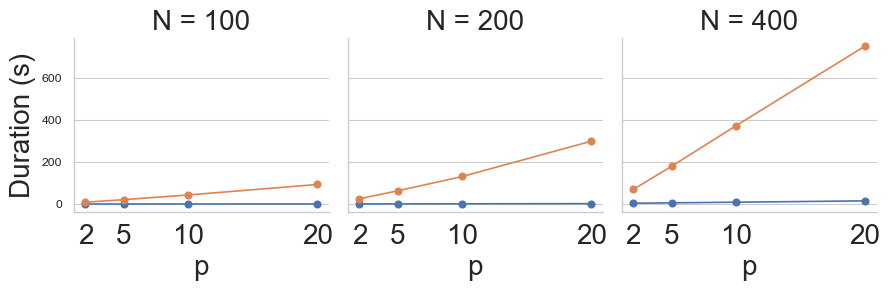

In [13]:
from plot_bench import *
forest_df = make_forest_df(df)
plot_forest_df(forest_df)
plt.savefig("./plots/runtime_phase.pdf")

## MSE CART vs Medoid

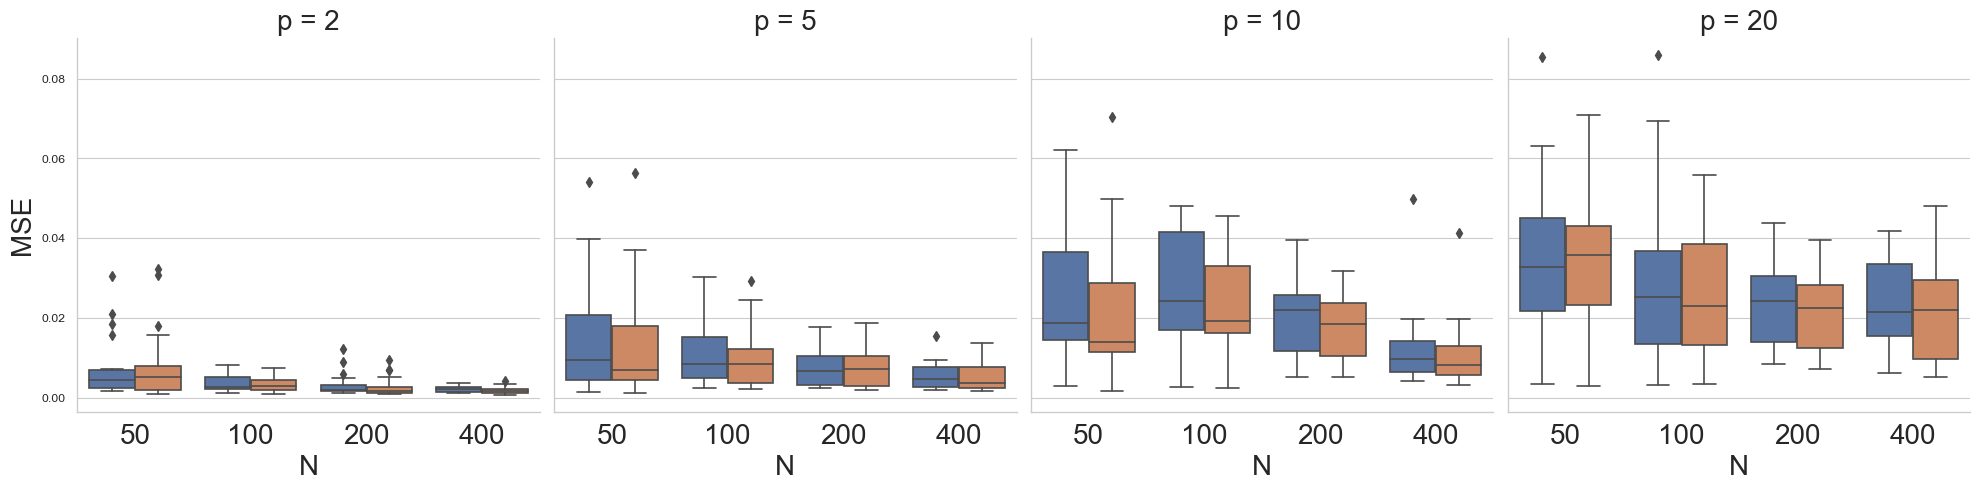

In [14]:
from plot_bench import *
plot_errors(df)
plt.savefig("./plots/error_phase.pdf")

([<matplotlib.patches.Rectangle object at 0x172111f10>, <matplotlib.patches.Rectangle object at 0x177fb56d0>], ['MRF', 'RFWLCFR'])


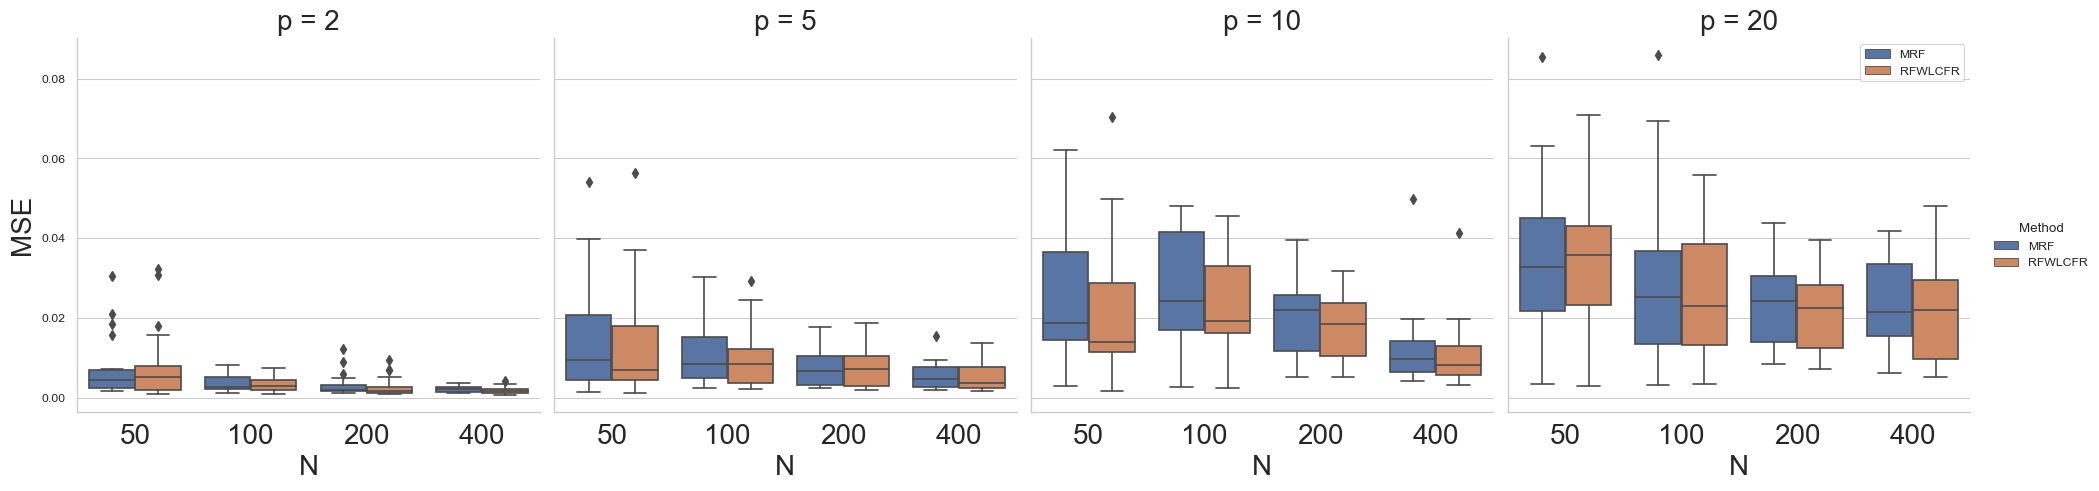

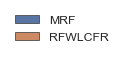

In [12]:
def make_legend(df, expand=[-5,-5,5,5]):
    df = df.copy().rename(columns={ 'err': 'MSE' })
    df['Method'] = df.method.map({'cart_2means': 'RFWLCFR', 'medoid_greedy': 'MRF' })
    sns.set_style("whitegrid")
    sns.set_context("paper", rc={
        "axes.labelsize": 20,
        "xtick.labelsize": 20
    })
    grid = sns.catplot(df,
        x='N', y='MSE',
        col="p",
        hue="Method",
        kind='box', hue_order=['MRF', 'RFWLCFR'])

    legend = plt.legend()
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    print(grid.axes[0][0].get_legend_handles_labels(),)
    legend_squared = legend_ax.legend(
        *grid.axes[0][0].get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncol=1,
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig(
        './plots/legend.pdf',
        bbox_inches='tight',
        bbox_extra_artists=[legend_squared],)


make_legend(df)


## Runtime CART vs Medoid

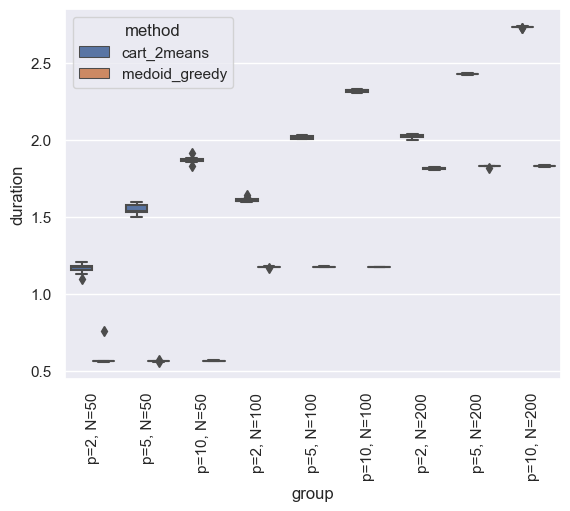

In [8]:
sns.boxplot(df, y=np.log10(df['duration']), x='group', hue='method')
plt.xticks(rotation=90);